# Import libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:,.4f}'.format) 
# pd.options.display.
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
from tqdm import tqdm
from itertools import combinations, permutations
import copy
import re
import math
import scipy.stats as ss
import missingno as msno

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score, mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer, PowerTransformer
from sklearn.utils import parallel_backend
from scipy.stats import randint, uniform, loguniform
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

# packages for data_preparation pipeline
from scipy.stats import zscore
from matplotlib.patches import Rectangle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score, average_precision_score
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
import sklearn
sklearn.set_config(display='diagram')

# packages for classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier

# packages for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score


import copy
from collections import Counter
import os
import time
from datetime import datetime
from joblib import dump, load
from tempfile import mkdtemp
from shutil import rmtree

import shap

# Import functions

## custom_division()

In [ ]:
def custom_division(numerator, denominator, default_value = np.nan): # default value for ZeroDivisionError, SUM should be $0 if there are no transactions
  # = numerator / denominator
  # = 0 if both = 0
  # = default_value if only denominator = 0 (ZeroDivisionError)
  return np.where((numerator == 0) & (denominator == 0), 0, np.where(denominator == 0, default_value, numerator / denominator))

# Import custom estimators

## ExtendedBinary() and FnHClassifier()

In [ ]:
# create customized classifier wrapper
class ExtendedBinary(BaseEstimator, ClassifierMixin):
  def __init__(self, estimator, decomposition_method = 'OrderedPartitions', proba_calculation = None):
    self.estimator = estimator
    self.decomposition_method = decomposition_method
    self.proba_calculation = proba_calculation
  
  def fit(self, X, y = None, sample_weight = None):
    if self.decomposition_method == 'OrderedPartitions':
      # Low vs Medium, High
      set1_filter = np.nonzero(y > -1) # include all 3 classes
      set1_threshold = 0
      # Low, Medium vs High
      set2_filter = np.nonzero(y > -1) # include all 3 classes
      set2_threshold = 1
    elif self.decomposition_method == 'OneVsNext':
      # Low vs Medium
      set1_filter = np.nonzero(y < 2)
      set1_threshold = 0
      # Medium vs High
      set2_filter = np.nonzero(y > 0)
      set2_threshold = 1
    elif self.decomposition_method == 'OneVsFollowers':
      # Low vs Medium, High
      set1_filter = np.nonzero(y > -1)
      set1_threshold = 0
      # Medium vs High
      set2_filter = np.nonzero(y > 0)
      set2_threshold = 1
    elif self.decomposition_method == 'OneVsPrevious':
      # Low, Medium vs High
      set1_filter = np.nonzero(y > -1)
      set1_threshold = 1
      # Low vs Medium
      set2_filter = np.nonzero(y < 2)
      set2_threshold = 0
    
    if type(X) is pd.DataFrame:
      column_names = X.columns
      X = X.to_numpy()
      set1 = pd.DataFrame(X[set1_filter], columns = column_names) 
      set2 = pd.DataFrame(X[set2_filter], columns = column_names) 
    else:
      set1 = X[set1_filter]
      set2 = X[set2_filter]
    y_extend = np.append((y[set1_filter] > set1_threshold).astype(int), (y[set2_filter] > set2_threshold).astype(int))
    if sample_weight is not None:
      sample_weight = np.append(sample_weight[set1_filter], sample_weight[set2_filter])   
    
    X_extend = pd.concat([set1, set2], axis = 0)
    X_extend['set_num'] = np.append(np.zeros(set1.shape[0]), np.ones(set2.shape[0]))
    
    try:
      self.estimator.fit(X_extend, y_extend, sample_weight = sample_weight)
    except TypeError:
      self.estimator.fit(X_extend, y_extend)

    self.classes_ = np.sort(np.unique(y_extend))
    return self
  
  def predict_proba(self, X):
    X_extend = pd.concat([X, X], axis = 0)
    X_extend['set_num'] = np.append(np.zeros(X.shape[0]), np.ones(X.shape[0]))
    proba = self.estimator.predict_proba(X_extend)[:,1].reshape(-1,2, order = 'F')
    if self.proba_calculation is None:
      if self.decomposition_method == 'OrderedPartitions':
        # Low vs Medium, High
        # Low, Medium vs High
        proba_recal = np.c_[[1 - proba[:,0], proba[:,0] - proba[:, 1], proba[:, 1]]].T
      elif self.decomposition_method == 'OneVsNext':
        # Low vs Medium
        # Medium vs High
        proba_recal = np.c_[[1 - proba[:,0], 1 / 2 * (proba[:,0] + 1 - proba[:, 1]), proba[:, 1]]].T # P(Medium) = average of 2 
      elif self.decomposition_method == 'OneVsFollowers':
        # Low vs Medium, High
        # Medium vs High
        proba_recal = np.c_[[1 - proba[:,0], proba[:,0] * (1 - proba[:, 1]), proba[:,0] * proba[:, 1]]].T # 2007 Cardoso conditional probability 
      elif self.decomposition_method == 'OneVsPrevious':
        # Low, Medium vs High
        # Low vs Medium
        proba_recal = np.c_[[(1 - proba[:,0]) * (1 - proba[:, 1]), proba[:,1] * (1 - proba[:, 0]), proba[:, 0]]].T
    else:
      # simple sum
      proba_recal = np.c_[[1 - proba[:,0] + 1 - proba[:,1], proba[:,0] + 1 - proba[:,1], proba[:,0] + proba[:,1]]].T
    return proba_recal

  def predict(self, X):
    proba = self.predict_proba(X)
    return proba.argmax(axis = 1)

# create customized classifier wrapper
class FnHClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, estimator0, estimator1, decomposition_method = 'OrderedPartitions'):
    self.estimator0 = estimator0
    self.estimator1 = estimator1
    self.decomposition_method = decomposition_method
  
  def fit(self, X, y = None, sample_weight = None):
    if self.decomposition_method == 'OrderedPartitions':
      # Low vs Medium, High
      set1_filter = np.nonzero(y > -1) # include all 3 classes
      set1_threshold = 0
      # Low, Medium vs High
      set2_filter = np.nonzero(y > -1) # include all 3 classes
      set2_threshold = 1
    elif self.decomposition_method == 'OneVsNext':
      # Low vs Medium
      set1_filter = np.nonzero(y < 2)
      set1_threshold = 0
      # Medium vs High
      set2_filter = np.nonzero(y > 0)
      set2_threshold = 1
    elif self.decomposition_method == 'OneVsFollowers':
      # Low vs Medium, High
      set1_filter = np.nonzero(y > -1)
      set1_threshold = 0
      # Medium vs High
      set2_filter = np.nonzero(y > 0)
      set2_threshold = 1
    elif self.decomposition_method == 'OneVsPrevious':
      # Low, Medium vs High
      set1_filter = np.nonzero(y > -1)
      set1_threshold = 1
      # Low vs Medium
      set2_filter = np.nonzero(y < 2)
      set2_threshold = 0
    
    if type(X) is pd.DataFrame:
      column_names = X.columns
      X = X.to_numpy()
      set1 = pd.DataFrame(X[set1_filter], columns = column_names) 
      set2 = pd.DataFrame(X[set2_filter], columns = column_names) 
    else:
      set1 = X[set1_filter]
      set2 = X[set2_filter]
    y_1 = (y[set1_filter] > set1_threshold).astype(int)
    y_2 = (y[set2_filter] > set2_threshold).astype(int)
    
    if sample_weight is not None:
      try:
        # assign sample weights if possible
        self.estimator0.fit(set1, y_1, sample_weight = sample_weight[set1_filter])
        self.estimator1.fit(set2, y_2, sample_weight = sample_weight[set2_filter])
      except:
        self.estimator0.fit(set1, y_1)
        self.estimator1.fit(set2, y_2)
    else:
      try:
        self.estimator0.fit(set1, y_1, sample_weight = None)
        self.estimator1.fit(set2, y_2, sample_weight = None)
      except:
        self.estimator0.fit(set1, y_1)
        self.estimator1.fit(set2, y_2)
    
    # average feature importance if possible
    try:
      self.feature_importances_ = (self.estimator0.feature_importances_ + self.estimator1.feature_importances_)/2
    except AttributeError:
      # average coefficients
      try:
        self.coef_ = (self.estimator0.coef_ + self.estimator1.coef_)/2
      except:
        pass
    
    self.classes_ = np.sort(np.unique(y))
    return self
  
  def predict_proba(self, X):
    proba_0 = self.estimator0.predict_proba(X)
    proba_1 = self.estimator1.predict_proba(X)
    if self.decomposition_method == 'OrderedPartitions':
      # Low vs Medium, High
      # Low, Medium vs High
      proba_recal = np.c_[[1 - proba_0[:,1], proba_0[:,1] - proba_1[:,1], proba_1[:,1]]].T
    elif self.decomposition_method == 'OneVsNext':
      # Low vs Medium
      # Medium vs High
      proba_recal = np.c_[[1 - proba_0[:,1], 1 / 2 * (proba_0[:,1] + 1 - proba_1[:,1]), proba_1[:,1]]].T # P(Medium) = average of 2 
    elif self.decomposition_method == 'OneVsFollowers':
      # Low vs Medium, High
      # Medium vs High
      proba_recal = np.c_[[1 - proba_0[:,1], proba_0[:,1] * (1 - proba_1[:,1]), proba_0[:,1] * proba_1[:,1]]].T # 2007 Cardoso conditional probability 
    elif self.decomposition_method == 'OneVsPrevious':
      # Low, Medium vs High
      # Low vs Medium
      proba_recal = np.c_[[(1 - proba_0[:,1]) * (1 - proba_1[:,1]), proba_1[:,1] * (1 - proba_0[:,1]), proba_0[:,1]]].T
    return proba_recal
  
  def predict(self, X):
    proba = self.predict_proba(X)
    return proba.argmax(axis = 1)

# Import custom transformers

## ManualTransformer()

In [ ]:
# FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
class ManualTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    
    output = copy.deepcopy(X)

    # flag variables for missingness (red flag if a person can open an account without providing a name)
    output['MISSING_NAME'] = output.NAME.isna().astype(int).astype('category')
    # let's not have these as we will take a look at missingness
    # output['MISSING_GENDER'] = output.GENDER.isna().astype(int).astype('category')
    # output['MISSING_CUST_ADD_DT'] = output.CUST_ADD_DT.isna().astype(int).astype('category')
    # output['MISSING_occupation_risk'] = output.occupation_risk.isna().astype(int).astype('category')

    output['DIFF_CNTRY'] = (output['RES_CNTRY_CA'] != output['CNTRY_OF_INCOME_CA']).astype(int).astype('category')

    today = pd.Timestamp('2023-01-01')
    # Age = Today - BIRTH_DT (does not take leap years into account)
    output['AGE'] = (today - output.BIRTH_DT).dt.days / 365.25
    # Days since customer joined = Today - CUST_ADD_DT
    output['HIST_JOIN'] = (today - output.CUST_ADD_DT).dt.days / 365.25
    
    # $ Average transaction amt = SUM / CNT for both incoming and outgoing cash flows
    output['WIRES_AVG_IN'] = custom_division(output.WIRES_SUM_IN, 
                                             output.WIRES_CNT_IN, 
                                             default_value=999_999_999)
    output['WIRES_AVG_OUT'] = custom_division(output.WIRES_SUM_OUT, 
                                              output.WIRES_CNT_OUT, 
                                              default_value=999_999_999)
    output['CASH_AVG_IN'] = custom_division(output.CASH_SUM_IN, 
                                            output.CASH_CNT_IN, 
                                            default_value=999_999_999)
    output['CASH_AVG_OUT'] = custom_division(output.CASH_SUM_OUT, 
                                             output.CASH_CNT_OUT, 
                                             default_value=999_999_999)
    
    
    # Remove rows with invalid data entry (CNT == 0 while SUM != 0)
    EntryError_df = output.loc[(output == 999_999_999).any(axis=1), [x for x in output.columns if ('_SUM_' in x) | ('_CNT_' in x) | (x == 'RISK')]]
    # add dummy variable to indicate data entry error
    output['DATA_ENTRY_ERROR'] = 0
    output.loc[output.index.isin(EntryError_df.index), 'DATA_ENTRY_ERROR'] = 1
    output['DATA_ENTRY_ERROR'] = output['DATA_ENTRY_ERROR'].astype(int).astype('category')
    # replace 999_999_999 with 0
    output.replace(999_999_999, 0, inplace=True)

    # helper columns for ease of calculation to be dropped later
    output['TOTAL_SUM'] = (output.WIRES_SUM_IN + output.WIRES_SUM_OUT + output.CASH_SUM_IN + output.CASH_SUM_OUT)
    output['TOTAL_IN_SUM'] = (output.WIRES_SUM_IN + output.CASH_SUM_IN)
    output['TOTAL_OUT_SUM'] = (output.WIRES_SUM_OUT + output.CASH_SUM_OUT)
    output['TOTAL_WIRES_SUM'] = (output.WIRES_SUM_IN + output.WIRES_SUM_OUT)
    output['TOTAL_CASH_SUM'] = (output.CASH_SUM_IN + output.CASH_SUM_OUT)

    output['TOTAL_CNT'] = (output.WIRES_CNT_IN + output.WIRES_CNT_OUT + output.CASH_CNT_IN + output.CASH_CNT_OUT)
    output['TOTAL_IN_CNT'] = (output.WIRES_CNT_IN + output.CASH_CNT_IN)
    output['TOTAL_OUT_CNT'] = (output.WIRES_CNT_OUT + output.CASH_CNT_OUT)
    output['TOTAL_WIRES_CNT'] = (output.WIRES_CNT_IN + output.WIRES_CNT_OUT)
    output['TOTAL_CASH_CNT'] = (output.CASH_CNT_IN + output.CASH_CNT_OUT)

    output['TOTAL_AVG'] = custom_division(output.TOTAL_SUM, output.TOTAL_CNT, 0)
    output['TOTAL_IN_AVG'] = custom_division(output.TOTAL_IN_SUM, output.TOTAL_IN_CNT, 0)
    output['TOTAL_OUT_AVG'] = custom_division(output.TOTAL_OUT_SUM, output.TOTAL_OUT_CNT, 0)
    output['TOTAL_WIRES_AVG'] = custom_division(output.TOTAL_WIRES_SUM, output.TOTAL_WIRES_CNT, 0)
    output['TOTAL_CASH_AVG'] = custom_division(output.TOTAL_CASH_SUM, output.TOTAL_CASH_CNT, 0)
    

    # WIRES_AVG >> CASH_AVG
    output['WIRES_VS_CASH_AVG'] = custom_division(output.TOTAL_WIRES_AVG, output.TOTAL_CASH_AVG, 0) #output.TOTAL_AVG)
    # ratio of IN_AVG vs OUT_AVG for WIRES and CASH
    output['IN_VS_OUT_WIRES_AVG'] = custom_division(output.WIRES_AVG_IN, output.WIRES_AVG_OUT, 0) #output.TOTAL_WIRES_AVG)
    output['IN_VS_OUT_CASH_AVG'] = custom_division(output.CASH_AVG_IN, output.CASH_AVG_OUT, 0) #output.TOTAL_CASH_AVG)

    # don't compare WIRES_AVG with CASH_AVG as WIRES_AVG >> CASH_AVG
    # output['WIRES_IN_pct_AVG'] = custom_division(output.WIRES_AVG_IN, output.TOTAL_AVG)
    # output['WIRES_OUT_pct_AVG'] = custom_division(output.WIRES_AVG_OUT, output.TOTAL_AVG) 
    # output['CASH_IN_pct_AVG'] = custom_division(output.CASH_AVG_IN, output.TOTAL_AVG)
    # output['WIRES_pct_IN_AVG'] = custom_division(output.WIRES_AVG_IN, output.TOTAL_IN_AVG)
    # output['WIRES_pct_OUT_AVG'] = custom_division(output.WIRES_AVG_OUT, output.TOTAL_OUT_AVG)
      

    # WIRES_CNT contribute for a majority % of TOTAL_CNT
    output['WIRES_pct_CNT'] = custom_division(output.TOTAL_WIRES_CNT, output.TOTAL_CNT)
    # % of TOTAL_WIRES_CNT and TOTAL_CASH_CNT
    output['IN_pct_WIRES_CNT'] = custom_division(output.WIRES_CNT_IN, output.TOTAL_WIRES_CNT)
    output['IN_pct_CASH_CNT'] = custom_division(output.CASH_CNT_IN, output.TOTAL_CASH_CNT)

    # don't compare WIRES_CNT with CASH_CNT as WIRES_CNT >> CASH_CNT
    # output['WIRES_IN_pct_CNT'] = custom_division(output.WIRES_CNT_IN, output.TOTAL_CNT)
    # output['WIRES_OUT_pct_CNT'] = custom_division(output.WIRES_CNT_OUT, output.TOTAL_CNT)
    # output['CASH_IN_pct_CNT'] = custom_division(output.CASH_CNT_IN, output.TOTAL_CNT)
    # output['WIRES_pct_IN_CNT'] = custom_division(output.WIRES_CNT_IN, output.TOTAL_IN_CNT)
    # output['WIRES_pct_OUT_CNT'] = custom_division(output.WIRES_CNT_OUT, output.TOTAL_OUT_CNT) # similar to WIRES_pct_CNT
    


    # ratio of CNT VS AVG
    output['WIRES_IN_CNT_VS_AVG'] = custom_division(output.WIRES_CNT_IN, output.WIRES_AVG_IN)
    output['WIRES_OUT_CNT_VS_AVG'] = custom_division(output.WIRES_CNT_OUT, output.WIRES_AVG_OUT)
    output['CASH_IN_CNT_VS_AVG'] = custom_division(output.CASH_CNT_IN, output.CASH_AVG_IN)
    output['CASH_OUT_CNT_VS_AVG'] = custom_division(output.CASH_CNT_OUT, output.CASH_AVG_OUT)

    # change in balance within last 12 months due to cash and wires transactions
    output["CASH_BALANCE"] = output["CASH_SUM_IN"] - output["CASH_SUM_OUT"]
    output["WIRES_BALANCE"] = output["WIRES_SUM_IN"] - output["WIRES_SUM_OUT"]

    
    output.drop(columns = [
        # drop BIRTH_DT, CUST_ADD_DT
        'NAME', 'BIRTH_DT', 'CUST_ADD_DT',
        # drop helper TOTAL columns (only created for ease of calculation)
        # keep TOTAL_SUM for sample_weights
        'TOTAL_IN_SUM', 'TOTAL_OUT_SUM', 'TOTAL_WIRES_SUM', 'TOTAL_CASH_SUM',
        'TOTAL_CNT', 'TOTAL_IN_CNT', 'TOTAL_OUT_CNT', 'TOTAL_WIRES_CNT', 'TOTAL_CASH_CNT',
        # drop SUM 
        'WIRES_SUM_IN', 'WIRES_SUM_OUT', 'CASH_SUM_IN', 'CASH_SUM_OUT',
        # drop AVG: similar to WIRES_AVG_IN, WIRES_AVG_OUT, CASH_AVG_IN, CASH_AVG_OUT
        'TOTAL_AVG', 'TOTAL_WIRES_AVG', 'TOTAL_CASH_AVG', 'TOTAL_IN_AVG', 'TOTAL_OUT_AVG'
        ], inplace = True)

    
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

## OutlierRemoval()

In [ ]:
# FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
class OutlierRemoval(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    
    output = copy.deepcopy(X)
    output = output.loc[~(output.AGE >= 118)] # remove customers with AGE >= 118 years old
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

## MyMinMaxScaler(), MyQuantileTransformer(), ThermometerEncoder(), MyOneHotEncoder(), RandomImputer(), MySimpleImputer()

In [ ]:
# create customer transformer to pass as df instead of array
class MyMinMaxScaler(BaseEstimator, TransformerMixin):
  def __init__(self, feature_range = (0,1)):
    self.feature_range = feature_range
  
  def fit(self, X, y = None):
    self.MinMaxScaler_ = MinMaxScaler(feature_range = self.feature_range).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.MinMaxScaler_.transform(output),
                          columns = output.columns)
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to pass as df instead of array
class MyPowerTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, random_state=42):
    self.random_state=42
  
  def fit(self, X, y = None):
    self.PowerTransformer_ = PowerTransformer().fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.PowerTransformer_.transform(output),
                          columns = output.columns)
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    try:
      self.output_names = X.columns
    except AttributeError: 
      pass
    output = self.QuantileTransformer.transform(output)
    return output
  
  def get_feature_names_out(self, names = None):
    try: 
      return self.output_names
    except AttributeError:
      pass

# create customer transformer to pass as df instead of array
class ThermometerEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    
    output = copy.deepcopy(X)

    output_final = pd.DataFrame()

    for col in output.columns:
      
      temp = []
      for code in sorted(output[col].cat.codes.unique())[:-1]:
        temp.append((output[col].cat.codes > code).astype(int))
      temp = pd.DataFrame(np.array(temp).T)
      temp.columns = [col + '_' + str(x) for x in output[col].cat.categories.unique()[1:]]
      output_final = pd.concat([output_final, temp], axis = 1)

    self.output_names = output_final.columns
    return output_final
  
  def get_feature_names_out(self, names = None):
    return self.output_names

class MyOneHotEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, drop = None, sparse = True):
    self.drop = drop
    self.sparse = sparse
  
  def fit(self, X, y = None):
    self.OneHotEncoder_ = OneHotEncoder(drop = self.drop, sparse = self.sparse).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.OneHotEncoder_.transform(output),
                          columns = self.OneHotEncoder_.get_feature_names_out())
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to pass as df instead of array
class RandomImputer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    
    output = copy.deepcopy(X)

    for na_col in ['GENDER', 'HIST_JOIN', 'occupation_risk']:
      if na_col in output.columns:
        if na_col == 'GENDER':
          try:
            # sample GENDER within MISSING_NAME == 1
            output.loc[output[na_col].isna(), na_col] = output.loc[(output[na_col].notnull()) & (output.MISSING_NAME == 1), na_col].sample(output[na_col].isna().sum(), random_state = 42, replace = True).to_numpy()
          except ValueError:
            # pass if there is no missing
            pass
        else:
          try:
            # sample HIST_JOIN and occupation_risk randomly
            output.loc[output[na_col].isna(), na_col] = output.loc[output[na_col].notnull(), na_col].sample(output[na_col].isna().sum(), random_state = 42, replace = True).to_numpy()
          except ValueError:
            # pass if there is no missing
            pass

    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to pass as df instead of array
class MySimpleImputer(BaseEstimator, TransformerMixin):
  def __init__(self, strategy = 'mean', random_state=42):
    self.random_state=42
    self.strategy = strategy
  
  def fit(self, X, y = None):
    self.SimpleImputer_ = SimpleImputer(strategy=self.strategy).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    if self.strategy == 'most_frequent':
      output = pd.DataFrame(self.SimpleImputer_.transform(output),
                            columns = output.columns).astype('category')
    else:
      output = pd.DataFrame(self.SimpleImputer_.transform(output),
                            columns = output.columns)
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# Import custom scorers

## macro_avg_MAE(), multipartite_AUC()

### asymmetric cost structure reflected in multipartite_AUC()

In [ ]:
def macro_avg_MAE(y_true, y_pred):
  MAEs = [mean_absolute_error(y_true[y_true == true_val], y_pred[y_true == true_val]) for true_val in np.unique(y_true)]
  print([f"{MAE:0.2f}" for MAE in MAEs])
  return np.mean(MAEs)

macro_avg_MAE_scorer = make_scorer(macro_avg_MAE)

def multipartite_AUC(y_true, y_score, average = 'macro'):
  # (2009, Furnkranz, Hullermeier, Vanderlooy) Binary Decomposition Methods for Multipartite Ranking (https://link.springer.com/content/pdf/10.1007/978-3-642-04180-8_41.pdf)
  # sklearn _average_multiclass_ovo_score https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/metrics/_base.py
  y_true_unique = np.sort(np.unique(y_true))
  n_classes = y_true_unique.shape[0]
  n_pairs = n_classes * (n_classes - 1) // 2
  pair_scores = np.empty(n_pairs)

  is_weighted = average == "weighted"
  prevalence = np.empty(n_pairs) if is_weighted else None

  # Compute scores treating a as positive class and b as negative class,
  # then b as positive class and a as negative class
  for ix, (a, b) in enumerate(combinations(y_true_unique, 2)):
      a_mask = y_true == a
      b_mask = y_true == b
      ab_mask = np.logical_or(a_mask, b_mask)

      a_true = a_mask[ab_mask]
      b_true = b_mask[ab_mask]

      if is_weighted:
        prevalence[ix] = np.average(ab_mask)
      
      a_true_score = roc_auc_score(a_true, y_score[ab_mask, a])
      b_true_score = roc_auc_score(b_true, y_score[ab_mask, b]) * 2 # reflect the asymmetric misclassification cost of classifiying a higher risk rating as lower risk rating > that of classifying a lower risk rating as a higher risk rating
      print(f"{a_true_score:0.2f}, {b_true_score:0.2f}")
      pair_scores[ix] = (a_true_score + b_true_score) / 3
      # add a line to print the scores 
      
  print([f"Classes {a}, {b}: {pair_score:0.2f}" for (a, b), pair_score in zip(combinations(y_true_unique, 2), pair_scores)])
  return np.average(pair_scores, weights=prevalence)

multipartite_AUC_scorer = make_scorer(multipartite_AUC, needs_proba=True)

### visualization of 3 bipartite ranking problems

In [ ]:
def hide_zero(v):
  if v == 0:
    return 0
  else:
    return f""

def style_zero(v, props=''):
    return props if v == 0 else None

pd.DataFrame({
    ('AUC(Medium > Low)', 'Medium (1) > Low (0)'): np.concatenate((np.arange(0.1,1.1,0.1), np.zeros(5))),
    # ('AUC(Medium > Low)', 'Medium (0) > Low (1)'): np.concatenate((np.arange(1,0,-0.1), np.zeros(5))),
    ('AUC(High > Low)', 'High (1) > Low (0)'): np.concatenate((np.arange(0.1,0.6,0.1), np.zeros(5), np.arange(0.6,1.01,0.1))),
    # ('AUC(High > Low)', 'High (0) > Low (1)'): np.concatenate((np.arange(1,0.5,-0.1), np.zeros(5), np.arange(0.5,0,-0.1))),
    ('AUC(High > Medium)', 'High (1) > Medium (0)'): np.concatenate((np.zeros(5), np.arange(0.1,1.1,0.1))),
    # ('AUC(High > Medium)', 'High (0) > Medium (1)'): np.concatenate((np.zeros(5), np.arange(1,0,-0.1))),
}, index= pd.MultiIndex.from_tuples([('Risk = Low', i) if idx <= 4 else ('Risk = Medium', i) if idx <= 9 else ('Risk = High', i) for i, idx in enumerate(np.arange(0,15,1))])).T.\
style.\
background_gradient(cmap = 'Reds', axis = 1).\
format(hide_zero).\
applymap(style_zero, props='background-color:white; color: white').\
set_table_styles([
    {'selector': 'th.row_heading', 'props': 'min-height: 500px; min-width: 200px; max-width: 100px; text-align: left'},
    {'selector': 'td', 'props': 'min-height: 500px; max-height: 500px; min-width: 20px; max-width: 20px; text-align: center'},
], overwrite=False).\
hide(level = 1).\
hide(level = 1, axis=1)

# Import files

## UofT_nodes (customer features)

- BIRTH_DT (Date): date of birth
- CUST_ADD_DT (Date): date of joining the bank
- OCPTN_NM (int): occupation code -> occupation risk
- RES_CNTRY_CA (Bool): whether customer lives in Canada
- CNTRY_OF_INCOME_CA (Bool): whether customer receives income in Canada
- PEP_FL (Bool): whether person is PEP
- CASH_SUM_IN (float): sum of cash in LTM
- CASH_CNT_IN (int): count of cash in LTM
- CASH_SUM_OUT (float): sum of cash out LTM
- CASH_CNT_OUT (int): count of cash out LTM
- WIRES_SUM_IN (float): sum of wire in LTM
- WIRES_CNT_IN (int): count of wire in LTM
- WIRES_SUM_OUT (float): sum of wire out LTM
- WIRES_CNT_OUT (int): count of wire out LTM
- COUNTRY_RISK_INCOME (int): country of income risk rating
- COUNTRY_RISK_RESIDENCY (int): country of residency risk rating
- RISK (str, categorical): customer risk rating <font color='red'> (target) </font>
- NAME (str): name of customer
- Gender (bool): gender of customer
- CUSTOMER_ID (int): customer_id <font color='red'> (unique identifier) </font>

In [ ]:
nodes_df = pd.read_csv('../UofT_nodes.csv')
nodes_df

BIRTH_DT CUST_ADD_DT  OCPTN_NM  RES_CNTRY_CA  CNTRY_OF_INCOME_CA  \
0       1981-09-01  2007-07-05   89.0000             1                   1   
1       1994-02-21  2019-05-19   89.0000             1                   1   
2       1962-11-16  2011-08-02   89.0000             1                   1   
3       1998-06-20  2001-08-15   89.0000             1                   1   
4       1942-01-24  2012-10-28   89.0000             1                   1   
...            ...         ...       ...           ...                 ...   
999995  1939-01-16  1994-03-19  467.0000             0                   1   
999996  1970-12-13  1995-12-22  467.0000             0                   1   
999997  1958-09-09  2010-11-03   65.0000             0                   1   
999998  1983-09-15  2013-01-30  231.0000             0                   1   
999999  1962-01-23  2017-03-07   89.0000             0                   0   

        PEP_FL  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  CASH_CNT_OUT  \
0       0.0000   2,577.7850       2.0000    2,851.6630        7.0000   
1       0.0000   3,035.5020       2.0000    4,805.9970       15.0000   
2       0.0000   1,617.5710       1.0000    3,482.8090       11.0000   
3       0.0000   3,587.0420       5.0000    1,940.9430        8.0000   
4       0.0000   1,725.5240       2.0000   13,197.1690       43.0000   
...        ...          ...          ...           ...           ...   
999995  0.0000  18,945.1080      10.0000   32,210.0000       21.0000   
999996  0.0000   5,775.6010       7.0000    5,015.7410       15.0000   
999997  0.0000   2,351.2550       2.0000   15,997.0000       19.0000   
999998  0.0000  27,312.6130       8.0000    3,399.0000        5.0000   
999999  0.0000   1,421.3630       1.0000    1,276.0000        1.0000   

         WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  WIRES_CNT_OUT  \
0         70,774.0000       62.0000    24,244.0000        35.0000   
1        282,929.0000       76.0000   196,439.0000       152.0000   
2          7,632.0000        6.0000    33,598.0000        20.0000   
3        149,253.0000       71.0000   105,896.0000       238.0000   
4         92,318.0000       96.0000   187,403.0000       180.0000   
...               ...           ...            ...            ...   
999995 1,186,467.0000       25.0000 2,550,098.0000       174.0000   
999996   244,504.0000       53.0000   417,992.0000       337.0000   
999997 3,024,271.0000       68.0000   948,981.0000       124.0000   
999998   943,477.0000        9.0000   376,429.0000        12.0000   
999999   683,797.0000        5.0000   617,628.0000        12.0000   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  RISK  \
0                      Low                    Low   low   
1                      Low                    Low   low   
2                      Low                    Low   low   
3                      Low                    Low   low   
4                      Low                    Low   low   
...                    ...                    ...   ...   
999995                 Low                   High  high   
999996                 Low                    Low   low   
999997                 Low                   High  high   
999998                 Low                   High  high   
999999                High                   High  high   

                                  NAME  GENDER  CUSTOMER_ID  
0         Young, Marie Mildren Coleman  Female 935,382.0000  
1                     Mark Stupar Lecy    Male   2,305.0000  
2           Dean Glasper Wendel Reeves    Male 472,403.0000  
3                  Hulsey, Linda Rauth  Female 227,994.0000  
4           Carolyn Washington Roberts  Female 418,265.0000  
...                                ...     ...          ...  
999995               Bret* Dove Gainey    Male 420,884.0000  
999996       Anthony Ray Montano Gomez    Male 429,418.0000  
999997  Bernadette Schofield Pace Mile  Female 731,360.0000  
999998         Wasson, Russell Terrell    Male 837

In [ ]:
nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   BIRTH_DT                1000000 non-null  object 
 1   CUST_ADD_DT             995822 non-null   object 
 2   OCPTN_NM                993616 non-null   float64
 3   RES_CNTRY_CA            1000000 non-null  int64  
 4   CNTRY_OF_INCOME_CA      1000000 non-null  int64  
 5   PEP_FL                  1000000 non-null  float64
 6   CASH_SUM_IN             1000000 non-null  float64
 7   CASH_CNT_IN             1000000 non-null  float64
 8   CASH_SUM_OUT            1000000 non-null  float64
 9   CASH_CNT_OUT            1000000 non-null  float64
 10  WIRES_SUM_IN            1000000 non-null  float64
 11  WIRES_CNT_IN            1000000 non-null  float64
 12  WIRES_SUM_OUT           1000000 non-null  float64
 13  WIRES_CNT_OUT           1000000 non-null  float64
 14  COU

In [ ]:
# CUSTOMER_ID = unique identifier 
assert nodes_df.CUSTOMER_ID.nunique() == nodes_df.shape[0]

### fix datatypes
- datetime
  - BIRTH_DT 
  - CUST_ADD_DT
- int -> str
  - CUSTOMER_ID
- unordered category
  - OCPTN_NM (contains NA so wait until train test split)
  - PEP_FL
  - RES_CNTRY_CA
  - CNTRY_OF_INCOME_CA
  - GENDER
- ordered category
  - COUNTRY_RISK_INCOME
  - COUNTRY_RISK_RESIDENCY
  - RISK

In [ ]:
# datetime
nodes_df.BIRTH_DT = pd.to_datetime(nodes_df.BIRTH_DT)
nodes_df.CUST_ADD_DT = pd.to_datetime(nodes_df.CUST_ADD_DT)

# string identifier
nodes_df.CUSTOMER_ID = nodes_df.CUSTOMER_ID.astype(int).astype(str)

# unordered category
nodes_df.PEP_FL = nodes_df.PEP_FL.astype(int).astype('category')
nodes_df.RES_CNTRY_CA = nodes_df.RES_CNTRY_CA.astype(int).astype('category')
nodes_df.CNTRY_OF_INCOME_CA = nodes_df.CNTRY_OF_INCOME_CA.astype(int).astype('category')
nodes_df.GENDER = nodes_df.GENDER.astype('category')

# dtype as ordered category
from pandas.api.types import CategoricalDtype
nodes_df.COUNTRY_RISK_INCOME = nodes_df.COUNTRY_RISK_INCOME.astype(CategoricalDtype(['Low', 'Moderate', 'High'], ordered=True))
nodes_df.COUNTRY_RISK_RESIDENCY = nodes_df.COUNTRY_RISK_RESIDENCY.astype(CategoricalDtype(['Low', 'Moderate', 'High'], ordered=True))
nodes_df.RISK = nodes_df.RISK.astype(CategoricalDtype(['low', 'medium', 'high'], ordered=True))

In [ ]:
nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   BIRTH_DT                1000000 non-null  datetime64[ns]
 1   CUST_ADD_DT             995822 non-null   datetime64[ns]
 2   OCPTN_NM                993616 non-null   float64       
 3   RES_CNTRY_CA            1000000 non-null  category      
 4   CNTRY_OF_INCOME_CA      1000000 non-null  category      
 5   PEP_FL                  1000000 non-null  category      
 6   CASH_SUM_IN             1000000 non-null  float64       
 7   CASH_CNT_IN             1000000 non-null  float64       
 8   CASH_SUM_OUT            1000000 non-null  float64       
 9   CASH_CNT_OUT            1000000 non-null  float64       
 10  WIRES_SUM_IN            1000000 non-null  float64       
 11  WIRES_CNT_IN            1000000 non-null  float64       
 12  WIRES_SUM_OUT  

### class imbalance -> stratified shuffle split

- stratified + shuffle for train test split and CV

In [ ]:
# class imbalance
nodes_df.RISK.value_counts(normalize=True)

low      0.6000
medium   0.3500
high     0.0500
Name: RISK, dtype: float64

## UofT_occupation_risk
- code (int)
- risk (str, categorical)

In [ ]:
occupation_risk_df = pd.read_csv('../UofT_occupation_risk.csv')
occupation_risk_df

code occupation_risk
0       0             Low
1       1            High
2       2             Low
3       3             Low
4       4             Low
..    ...             ...
836   836             Low
837   837             Low
838   838             Low
839   839            High
840   840            High

[841 rows x 2 columns]

In [ ]:
occupation_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   code             841 non-null    int64 
 1   occupation_risk  841 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.3+ KB


In [ ]:
# code = unique identifier 
assert occupation_risk_df.code.nunique() == occupation_risk_df.shape[0]

In [ ]:
occupation_risk_df.occupation_risk.unique()

array(['Low', 'High', 'Moderate'], dtype=object)

In [ ]:
# ordered category
occupation_risk_df.occupation_risk = occupation_risk_df.occupation_risk.astype(CategoricalDtype(['Low', 'Moderate', 'High'], ordered=True))

## Merge into nodes_full
- drop NAME, CUSTOMER_ID (unique identifier)
- drop OCPTN_NM, code after merging with occupation_risk_df

In [ ]:
# left join to keep NA on OCPTN_NM, code and occupation_risk
nodes_full = nodes_df.merge(occupation_risk_df, left_on = 'OCPTN_NM', right_on = 'code', how = 'left') 

# drop OCPTN_NM, code after merging with occupation_risk_df
nodes_full = nodes_full.drop(columns = ['CUSTOMER_ID', 'OCPTN_NM', 'code'])
# recorder columns
nodes_full = nodes_full[[
    # personal information
    'NAME', 'GENDER', 'occupation_risk', 'BIRTH_DT', 'CUST_ADD_DT', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 
    # financial transactions
    'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT',
    'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 
    # target label
    'RISK']]
  
nodes_full

NAME  GENDER occupation_risk   BIRTH_DT  \
0         Young, Marie Mildren Coleman  Female            High 1981-09-01   
1                     Mark Stupar Lecy    Male            High 1994-02-21   
2           Dean Glasper Wendel Reeves    Male            High 1962-11-16   
3                  Hulsey, Linda Rauth  Female            High 1998-06-20   
4           Carolyn Washington Roberts  Female            High 1942-01-24   
...                                ...     ...             ...        ...   
999995               Bret* Dove Gainey    Male             Low 1939-01-16   
999996       Anthony Ray Montano Gomez    Male             Low 1970-12-13   
999997  Bernadette Schofield Pace Mile  Female            High 1958-09-09   
999998         Wasson, Russell Terrell    Male            High 1983-09-15   
999999                Daniel Mckeighan    Male            High 1962-01-23   

       CUST_ADD_DT RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL COUNTRY_RISK_INCOME  \
0       2007-07-05            1                  1      0                 Low   
1       2019-05-19            1                  1      0                 Low   
2       2011-08-02            1                  1      0                 Low   
3       2001-08-15            1                  1      0                 Low   
4       2012-10-28            1                  1      0                 Low   
...            ...          ...                ...    ...                 ...   
999995  1994-03-19            0                  1      0                 Low   
999996  1995-12-22            0                  1      0                 Low   
999997  2010-11-03            0                  1      0                 Low   
999998  2013-01-30            0                  1      0                 Low   
999999  2017-03-07            0                  0      0                High   

       COUNTRY_RISK_RESIDENCY  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  \
0                         Low   2,577.7850       2.0000    2,851.6630   
1                         Low   3,035.5020       2.0000    4,805.9970   
2                         Low   1,617.5710       1.0000    3,482.8090   
3                         Low   3,587.0420       5.0000    1,940.9430   
4                         Low   1,725.5240       2.0000   13,197.1690   
...                       ...          ...          ...           ...   
999995                   High  18,945.1080      10.0000   32,210.0000   
999996                    Low   5,775.6010       7.0000    5,015.7410   
999997                   High   2,351.2550       2.0000   15,997.0000   
999998                   High  27,312.6130       8.0000    3,399.0000   
999999                   High   1,421.3630       1.0000    1,276.0000   

        CASH_CNT_OUT   WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
0             7.0000    70,774.0000       62.0000    24,244.0000   
1            15.0000   282,929.0000       76.0000   196,439.0000   
2            11.0000     7,632.0000        6.0000    33,598.0000   
3             8.0000   149,253.0000       71.0000   105,896.0000   
4            43.0000    92,318.0000       96.0000   187,403.0000   
...              ...            ...           ...            ...   
999995       21.0000 1,186,467.0000       25.0000 2,550,098.0000   
999996       15.0000   244,504.0000       53.0000   417,992.0000   
999997       19.0000 3,024,271.0000       68.0000   948,981.0000   
999998        5.0000   943,477.0000        9.0000   376,429.0000   
999999        1.0000   683,797.0000        5.0000   617,628.0000   

        WIRES_CNT_OUT  RISK  
0             35.0000   low  
1            152.0000   low  
2             20.0000   low  
3            238.0000   low  
4            180.0000   low  
...               ...   ...  
999995       174.0000  high  
999996       337.0000   low  
999997       124.0000  high  
999998        12.0000  high  
999999        12.0000  high  

[1000000 rows x 19 columns]

In [ ]:
nodes_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   NAME                    999340 non-null   object        
 1   GENDER                  999372 non-null   category      
 2   occupation_risk         993616 non-null   category      
 3   BIRTH_DT                1000000 non-null  datetime64[ns]
 4   CUST_ADD_DT             995822 non-null   datetime64[ns]
 5   RES_CNTRY_CA            1000000 non-null  category      
 6   CNTRY_OF_INCOME_CA      1000000 non-null  category      
 7   PEP_FL                  1000000 non-null  category      
 8   COUNTRY_RISK_INCOME     1000000 non-null  category      
 9   COUNTRY_RISK_RESIDENCY  1000000 non-null  category      
 10  CASH_SUM_IN             1000000 non-null  float64       
 11  CASH_CNT_IN             1000000 non-null  float64       
 12  CASH_SUM_OUT   

# Train test split (Stratified Shuffle Split)

In [ ]:
train_set, test_set = train_test_split(nodes_full, test_size = 0.2, random_state = 42, shuffle = True, stratify = nodes_full.RISK)

In [ ]:
print(f"size of full dataset: {nodes_full.shape}")
print(f"size of train dataset: {train_set.shape}")
print(f"size of test dataset: {test_set.shape}")
print(f"train-test ratio: {train_set.shape[0] / nodes_full.shape[0]:0.2} / {test_set.shape[0] / nodes_full.shape[0]:0.2}")

size of full dataset: (1000000, 19)
size of train dataset: (800000, 19)
size of test dataset: (200000, 19)
train-test ratio: 0.8 / 0.2


<AxesSubplot:ylabel='RISK'>

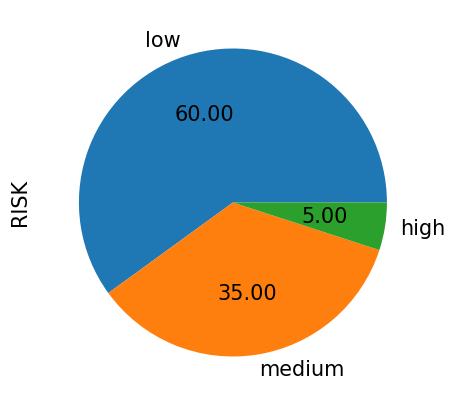

In [ ]:
# maintain same class % in train set
train_set.RISK.value_counts(normalize=True).plot(kind = 'pie', autopct='%.2f')

In [ ]:
# output
train_set.reset_index(drop=True).to_pickle('Task_2A_train.pkl')
test_set.reset_index(drop=True).to_pickle('Task_2A_test.pkl')

## Read train set

In [ ]:
train_set = pd.read_pickle("Task_2A_train.pkl")
train_set

NAME  GENDER occupation_risk   BIRTH_DT  \
0                Mary McenaXney Woods  Female             Low 1986-10-28   
1           Jason Hagen Liles Jackson    Male             Low 1950-10-12   
2        chris Pritt Robinson Daniels    Male             Low 1996-12-24   
3                 Schultz, erc Henand    Male            High 1965-05-04   
4               Tesoriero, Olen Burns    Male             Low 1926-07-13   
...                               ...     ...             ...        ...   
799995  Shepard, Betty Mercado Boesen  Female        Moderate 2005-01-07   
799996    Huffman, Terry White Mellis    Male             Low 1953-12-15   
799997     Jerome, Gene Ferraro White    Male             Low 1951-07-16   
799998               Lois Brand Lemon  Female             Low 2000-01-11   
799999             harle Howell Gomez    Male             Low 1983-10-17   

       CUST_ADD_DT RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL COUNTRY_RISK_INCOME  \
0       2011-03-03            1                  1      0                 Low   
1       2008-05-28            1                  1      0                 Low   
2       2017-01-12            1                  1      0                 Low   
3       2013-09-12            1                  1      0                 Low   
4       1985-09-26            1                  1      1                 Low   
...            ...          ...                ...    ...                 ...   
799995  2008-04-10            1                  1      0                 Low   
799996  1983-01-23            1                  1      1                 Low   
799997  1987-04-28            1                  1      0                 Low   
799998  2007-01-31            1                  1      0                 Low   
799999  2017-09-29            1                  1      0                 Low   

       COUNTRY_RISK_RESIDENCY  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  \
0                         Low   3,854.9780       6.0000    6,795.6240   
1                         Low  60,350.0000      25.0000   30,701.0000   
2                         Low     165.6070       0.0000    5,834.1380   
3                         Low  26,259.0000      13.0000   35,922.0000   
4                         Low  15,688.0000       7.0000    2,433.0000   
...                       ...          ...          ...           ...   
799995                    Low     799.7210       2.0000    7,823.5630   
799996                    Low  23,739.7710      13.0000   41,542.0000   
799997                    Low   9,859.1690       9.0000    3,361.7150   
799998                    Low     397.1000       2.0000    1,043.1940   
799999                    Low   2,796.8330       3.0000    5,452.3470   

        CASH_CNT_OUT   WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
0            18.0000   303,060.0000      115.0000   261,828.0000   
1            18.0000 6,207,312.0000       14.0000 4,834,893.0000   
2            18.0000    35,042.0000       21.0000     6,698.0000   
3            15.0000 3,517,833.0000       68.0000 2,429,213.0000   
4             3.0000   951,087.0000       15.0000 1,479,541.0000   
...              ...            ...           ...            ...   
799995       17.0000   169,347.0000       73.0000   128,734.0000   
799996       50.0000 3,541,579.0000      181.0000   648,732.0000   
799997        9.0000   157,329.0000       56.0000    97,755.0000   
799998        4.0000    90,755.0000       75.0000    72,317.0000   
799999       18.0000    94,843.0000       30.0000   130,327.0000   

        WIRES_CNT_OUT    RISK  
0            209.0000     low  
1             90.0000  medium  
2             10.0000     low  
3            116.0000  medium  
4             20.0000  medium  
...               ...     ...  
799995        92.0000     low  
799996       110.0000    high  
799997        69.0000     low  
799998       118.0000     low  
799999        77.0000     low  

[800000 rows x 19 columns]

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   NAME                    799450 non-null  object        
 1   GENDER                  799474 non-null  category      
 2   occupation_risk         794888 non-null  category      
 3   BIRTH_DT                800000 non-null  datetime64[ns]
 4   CUST_ADD_DT             796725 non-null  datetime64[ns]
 5   RES_CNTRY_CA            800000 non-null  category      
 6   CNTRY_OF_INCOME_CA      800000 non-null  category      
 7   PEP_FL                  800000 non-null  category      
 8   COUNTRY_RISK_INCOME     800000 non-null  category      
 9   COUNTRY_RISK_RESIDENCY  800000 non-null  category      
 10  CASH_SUM_IN             800000 non-null  float64       
 11  CASH_CNT_IN             800000 non-null  float64       
 12  CASH_SUM_OUT            800000

# Dataset preparation

## Manual transformers on df
- manual transformers on entire train_set, not X_train
- involve row remvoal

### Inconsistency: Detect Entry Error


Add
- Average transaction amt ($) = SUM / CNT for both incoming and outgoing cash flows (size of transaction, as a large sum can be due to a large count)
  - CASH_AVG_IN = CASH_SUM_IN / CASH_CNT_IN
  - CASH_AVG_OUT = CASH_SUM_OUT / CASH_CNT_OUT
  - WIRES_AVG_IN = WIRES_SUM_IN / WIRES_CNT_IN
  - WIRES_AVG_OUT = WIRES_SUM_OUT / WIRES_CNT_OUT

Entry error
  - if any AVG = 999_999_999 (default value when CNT = 0 but SUM != 0), the record is invalid due to data entry error

In [ ]:
train_clean = copy.deepcopy(train_set)
# $ Average transaction amt = SUM / CNT for both incoming and outgoing cash flows
train_clean['WIRES_AVG_IN'] = custom_division(train_clean.WIRES_SUM_IN, train_clean.WIRES_CNT_IN, default_value=999_999_999)
train_clean['WIRES_AVG_OUT'] = custom_division(train_clean.WIRES_SUM_OUT, train_clean.WIRES_CNT_OUT, default_value=999_999_999)
train_clean['CASH_AVG_IN'] = custom_division(train_clean.CASH_SUM_IN, train_clean.CASH_CNT_IN, default_value=999_999_999)
train_clean['CASH_AVG_OUT'] = custom_division(train_clean.CASH_SUM_OUT, train_clean.CASH_CNT_OUT, default_value=999_999_999)
train_clean

NAME  GENDER occupation_risk   BIRTH_DT  \
0                Mary McenaXney Woods  Female             Low 1986-10-28   
1           Jason Hagen Liles Jackson    Male             Low 1950-10-12   
2        chris Pritt Robinson Daniels    Male             Low 1996-12-24   
3                 Schultz, erc Henand    Male            High 1965-05-04   
4               Tesoriero, Olen Burns    Male             Low 1926-07-13   
...                               ...     ...             ...        ...   
799995  Shepard, Betty Mercado Boesen  Female        Moderate 2005-01-07   
799996    Huffman, Terry White Mellis    Male             Low 1953-12-15   
799997     Jerome, Gene Ferraro White    Male             Low 1951-07-16   
799998               Lois Brand Lemon  Female             Low 2000-01-11   
799999             harle Howell Gomez    Male             Low 1983-10-17   

       CUST_ADD_DT RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL COUNTRY_RISK_INCOME  \
0       2011-03-03            1                  1      0                 Low   
1       2008-05-28            1                  1      0                 Low   
2       2017-01-12            1                  1      0                 Low   
3       2013-09-12            1                  1      0                 Low   
4       1985-09-26            1                  1      1                 Low   
...            ...          ...                ...    ...                 ...   
799995  2008-04-10            1                  1      0                 Low   
799996  1983-01-23            1                  1      1                 Low   
799997  1987-04-28            1                  1      0                 Low   
799998  2007-01-31            1                  1      0                 Low   
799999  2017-09-29            1                  1      0                 Low   

       COUNTRY_RISK_RESIDENCY  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  \
0                         Low   3,854.9780       6.0000    6,795.6240   
1                         Low  60,350.0000      25.0000   30,701.0000   
2                         Low     165.6070       0.0000    5,834.1380   
3                         Low  26,259.0000      13.0000   35,922.0000   
4                         Low  15,688.0000       7.0000    2,433.0000   
...                       ...          ...          ...           ...   
799995                    Low     799.7210       2.0000    7,823.5630   
799996                    Low  23,739.7710      13.0000   41,542.0000   
799997                    Low   9,859.1690       9.0000    3,361.7150   
799998                    Low     397.1000       2.0000    1,043.1940   
799999                    Low   2,796.8330       3.0000    5,452.3470   

        CASH_CNT_OUT   WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
0            18.0000   303,060.0000      115.0000   261,828.0000   
1            18.0000 6,207,312.0000       14.0000 4,834,893.0000   
2            18.0000    35,042.0000       21.0000     6,698.0000   
3            15.0000 3,517,833.0000       68.0000 2,429,213.0000   
4             3.0000   951,087.0000       15.0000 1,479,541.0000   
...              ...            ...           ...            ...   
799995       17.0000   169,347.0000       73.0000   128,734.0000   
799996       50.0000 3,541,579.0000      181.0000   648,732.0000   
799997        9.0000   157,329.0000       56.0000    97,755.0000   
799998        4.0000    90,755.0000       75.0000    72,317.0000   
799999       18.0000    94,843.0000       30.0000   130,327.0000   

        WIRES_CNT_OUT    RISK  WIRES_AVG_IN  WIRES_AVG_OUT      CASH_AVG_IN  \
0            209.0000     low    2,635.3043     1,252.7656         642.4963   
1             90.0000  medium  443,379.4286    53,721.0333       2,414.0000   
2             10.0000     low    1,668.6667       669.8000 999,999,999.0000   
3            116.0000  medium   51,732.8382    20,941.4914       2,019.9231   
4             20.0000  medium   63,405.8000    73,977.0500

### Add dummy to indicate 999,999,999
- Add dummy variable to indicate 999_999_999 due to data entry error (CNT == 0 while SUM != 0)

In [ ]:
# rows with invalid data entry (CNT == 0 while SUM != 0)
EntryError_df = train_clean.loc[(train_clean == 999_999_999).any(axis=1), [x for x in train_clean.columns if ('_SUM_' in x) | ('_CNT_' in x) | (x == 'RISK')]]
EntryError_df

CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  CASH_CNT_OUT   WIRES_SUM_IN  \
2          165.6070       0.0000    5,834.1380       18.0000    35,042.0000   
27       1,191.7050       0.0000    2,989.4020        9.0000   149,033.0000   
35         446.1770       1.0000       78.1460        0.0000    21,369.0000   
38       4,349.4720       4.0000       90.3800        0.0000    96,388.0000   
52         644.4940       1.0000      160.5650        0.0000    17,892.0000   
...             ...          ...           ...           ...            ...   
799921   1,784.4490       1.0000       10.7950        0.0000     5,239.0000   
799923     103.4910       0.0000      181.4510        1.0000   146,424.0000   
799968     828.0440       0.0000    2,727.0570        8.0000    60,823.0000   
799970      97.0000       0.0000   50,582.0000       55.0000 9,168,951.0000   
799989     598.4980       0.0000   12,805.6890       29.0000   345,856.0000   

        WIRES_CNT_IN  WIRES_SUM_OUT  WIRES_CNT_OUT    RISK  
2            21.0000     6,698.0000        10.0000     low  
27           72.0000    26,017.0000        65.0000     low  
35            9.0000     1,814.0000         3.0000     low  
38           22.0000    78,030.0000       116.0000     low  
52            1.0000     1,783.0000         0.0000     low  
...              ...            ...            ...     ...  
799921       22.0000    40,393.0000        28.0000     low  
799923       33.0000   164,748.0000       141.0000     low  
799968       38.0000   110,670.0000        83.0000     low  
799970      189.0000 1,689,542.0000        89.0000  medium  
799989       34.0000   222,501.0000        75.0000     low  

[50127 rows x 9 columns]

In [ ]:
EntryError_df.RISK.value_counts(normalize=True)

low      0.7794
medium   0.1927
high     0.0279
Name: RISK, dtype: float64

In [ ]:
# CNT is not recorded as 0 due to threshold in SUM but due to data entry error
for CNT_col, SUM_col in [('CASH_CNT_IN', 'CASH_SUM_IN'), ('CASH_CNT_OUT', 'CASH_SUM_OUT'), ('WIRES_CNT_IN', 'WIRES_SUM_IN'), ('WIRES_CNT_OUT', 'WIRES_SUM_OUT')]:
  print(f'when {CNT_col} == 0, max({SUM_col}) = {EntryError_df[EntryError_df[CNT_col] == 0][SUM_col].max():,.2f}')
  print(f'when {CNT_col} != 0, min({SUM_col}) = {train_clean[train_clean[CNT_col] != 0][SUM_col].min():,.2f}')

when CASH_CNT_IN == 0, max(CASH_SUM_IN) = 12,030.00
when CASH_CNT_IN != 0, min(CASH_SUM_IN) = 40.43
when CASH_CNT_OUT == 0, max(CASH_SUM_OUT) = 12,557.00
when CASH_CNT_OUT != 0, min(CASH_SUM_OUT) = 9.00
when WIRES_CNT_IN == 0, max(WIRES_SUM_IN) = 14,805,018.00
when WIRES_CNT_IN != 0, min(WIRES_SUM_IN) = 2.00
when WIRES_CNT_OUT == 0, max(WIRES_SUM_OUT) = 4,464,132.00
when WIRES_CNT_OUT != 0, min(WIRES_SUM_OUT) = 10.00


In [ ]:
# add dummy variable to indicate data entry error
train_clean['DATA_ENTRY_ERROR'] = 0
train_clean.loc[train_clean.index.isin(EntryError_df.index), 'DATA_ENTRY_ERROR'] = 1
# replace 999_999_999 with 0
train_clean.replace(999_999_999, 0, inplace=True)
train_clean

NAME  GENDER occupation_risk   BIRTH_DT  \
0                Mary McenaXney Woods  Female             Low 1986-10-28   
1           Jason Hagen Liles Jackson    Male             Low 1950-10-12   
2        chris Pritt Robinson Daniels    Male             Low 1996-12-24   
3                 Schultz, erc Henand    Male            High 1965-05-04   
4               Tesoriero, Olen Burns    Male             Low 1926-07-13   
...                               ...     ...             ...        ...   
799995  Shepard, Betty Mercado Boesen  Female        Moderate 2005-01-07   
799996    Huffman, Terry White Mellis    Male             Low 1953-12-15   
799997     Jerome, Gene Ferraro White    Male             Low 1951-07-16   
799998               Lois Brand Lemon  Female             Low 2000-01-11   
799999             harle Howell Gomez    Male             Low 1983-10-17   

       CUST_ADD_DT RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL COUNTRY_RISK_INCOME  \
0       2011-03-03            1                  1      0                 Low   
1       2008-05-28            1                  1      0                 Low   
2       2017-01-12            1                  1      0                 Low   
3       2013-09-12            1                  1      0                 Low   
4       1985-09-26            1                  1      1                 Low   
...            ...          ...                ...    ...                 ...   
799995  2008-04-10            1                  1      0                 Low   
799996  1983-01-23            1                  1      1                 Low   
799997  1987-04-28            1                  1      0                 Low   
799998  2007-01-31            1                  1      0                 Low   
799999  2017-09-29            1                  1      0                 Low   

       COUNTRY_RISK_RESIDENCY  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  \
0                         Low   3,854.9780       6.0000    6,795.6240   
1                         Low  60,350.0000      25.0000   30,701.0000   
2                         Low     165.6070       0.0000    5,834.1380   
3                         Low  26,259.0000      13.0000   35,922.0000   
4                         Low  15,688.0000       7.0000    2,433.0000   
...                       ...          ...          ...           ...   
799995                    Low     799.7210       2.0000    7,823.5630   
799996                    Low  23,739.7710      13.0000   41,542.0000   
799997                    Low   9,859.1690       9.0000    3,361.7150   
799998                    Low     397.1000       2.0000    1,043.1940   
799999                    Low   2,796.8330       3.0000    5,452.3470   

        CASH_CNT_OUT   WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
0            18.0000   303,060.0000      115.0000   261,828.0000   
1            18.0000 6,207,312.0000       14.0000 4,834,893.0000   
2            18.0000    35,042.0000       21.0000     6,698.0000   
3            15.0000 3,517,833.0000       68.0000 2,429,213.0000   
4             3.0000   951,087.0000       15.0000 1,479,541.0000   
...              ...            ...           ...            ...   
799995       17.0000   169,347.0000       73.0000   128,734.0000   
799996       50.0000 3,541,579.0000      181.0000   648,732.0000   
799997        9.0000   157,329.0000       56.0000    97,755.0000   
799998        4.0000    90,755.0000       75.0000    72,317.0000   
799999       18.0000    94,843.0000       30.0000   130,327.0000   

        WIRES_CNT_OUT    RISK  WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  \
0            209.0000     low    2,635.3043     1,252.7656     642.4963   
1             90.0000  medium  443,379.4286    53,721.0333   2,414.0000   
2             10.0000     low    1,668.6667       669.8000       0.0000   
3            116.0000  medium   51,732.8382    20,941.4914   2,019.9231   
4             20.0000  medium   63,405.8000    73,977.0500   2,241.1429   
...

### Feature Engineering

*Placement: sum / count of cash flow*

• Example: customer deposits a total of $20,000 in cash using multiple transactions to
avoid reporting and detection of large cash deposits

*Layering*

• Customer receives an incoming wire from Country A for
$20,000, then sends an outgoing wire in the same
amount to Country B, or

• Customer makes a deposit to their account, then
transfers the funds to another of their accounts with
another financial institution

*Integration*

• Use illicit proceeds to purchase luxury assets such as real
estate, high end artwork, jewelry or vehicles

• A client opens an offshore bank account with a debit or credit
card to access the account. They wire illicit proceeds to this
offshore account, which are used for withdrawals or purchases

In [ ]:
def plot_percentiles(df, col_select = '', col_drop = None):
  fig, axes = plt.subplots(1,3, sharex = True, sharey = False, figsize = (20,5))

  # col_select = 'AVG'
  if col_select != '':
    if col_drop is None:
      norm_clean = pd.concat([
          df.select_dtypes(np.number)[[x for x in df.columns if col_select in x]].apply(lambda x: (x - x.mean()) / x.std()),
          df.RISK], axis = 1)
    else:
      norm_clean = pd.concat([
          df.select_dtypes(np.number)[[x for x in df.drop(columns = col_drop).columns if col_select in x]].apply(lambda x: (x - x.mean()) / x.std()),
          df.RISK], axis = 1)
  else:
    norm_clean = pd.concat([
        df.select_dtypes(np.number).apply(lambda x: (x - x.mean()) / x.std()),
        df.RISK], axis = 1)

  for ax, risk in zip(axes.flatten(), norm_clean.RISK.unique()):
    # norm_clean[norm_clean.RISK == risk].describe(percentiles = [.05, .25, .5, .75, .95], exclude=['category', 'object'], datetime_is_numeric=True).loc['25%':'75%',:].T.plot(kind = 'barh', ax = ax, legend = False)
    norm_clean[norm_clean.RISK == risk].select_dtypes(np.number).plot(kind='box', vert=False, showfliers=False, ax = ax)
    ax.set_title(f"Risk = {risk}")
    # ax.set_yticks(ticks = np.arange(1,6,1), labels = [])
    ax.axvline(0, ls = '--')
    ax.axvline(1, ls = '--')
    ax.axvline(-1, ls = '--')
    ax.set_xlim(-1.5, 1.5)

  plt.subplots_adjust(hspace = 0.2)
  plt.suptitle('25th percentile, median, 75th percentile and 1.5 x IQR', fontsize = 20)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

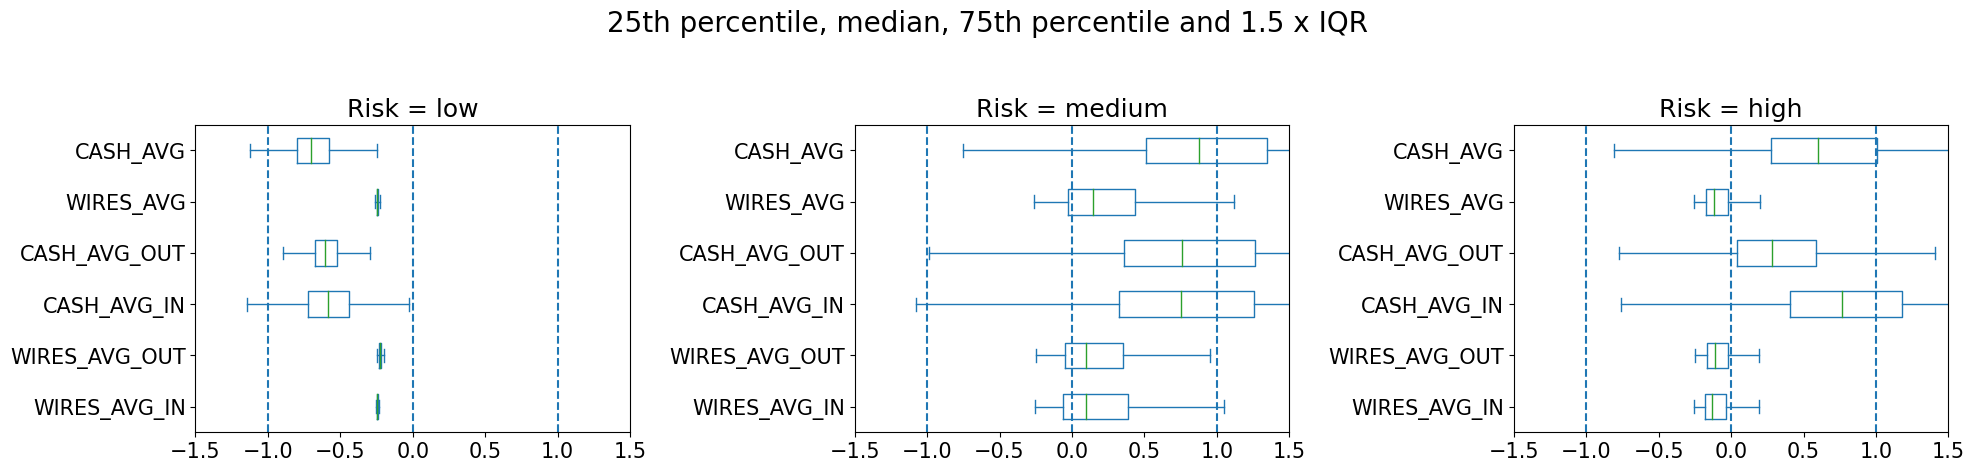

In [ ]:
train_clean2 = copy.deepcopy(train_clean)

train_clean2['TOTAL_AVG'] = custom_division((train_clean2.WIRES_SUM_IN + train_clean2.WIRES_SUM_OUT + train_clean2.CASH_SUM_IN + train_clean2.CASH_SUM_OUT),
                                            (train_clean2.WIRES_CNT_IN + train_clean2.WIRES_CNT_OUT + train_clean2.CASH_CNT_IN + train_clean2.CASH_CNT_OUT))
train_clean2['WIRES_AVG'] = custom_division((train_clean2.WIRES_SUM_IN + train_clean2.WIRES_SUM_OUT),
                                            (train_clean2.WIRES_CNT_IN + train_clean2.WIRES_CNT_OUT))
train_clean2['CASH_AVG'] = custom_division((train_clean2.CASH_SUM_IN + train_clean2.CASH_SUM_OUT),
                                            (train_clean2.CASH_CNT_IN + train_clean2.CASH_CNT_OUT))
train_clean2['IN_AVG'] = custom_division((train_clean2.WIRES_SUM_IN + train_clean2.CASH_SUM_IN),
                                            (train_clean2.WIRES_CNT_IN + train_clean2.CASH_CNT_IN))
train_clean2['OUT_AVG'] = custom_division((train_clean2.WIRES_SUM_OUT + train_clean2.CASH_SUM_OUT),
                                            (train_clean2.WIRES_CNT_OUT + train_clean2.CASH_CNT_OUT))
train_clean2.drop(columns = [
    # need to split between WIRES and CASH (magnitude)
    'TOTAL_AVG', 'IN_AVG', 'OUT_AVG',
], inplace = True)

plot_percentiles(train_clean2, 'AVG')

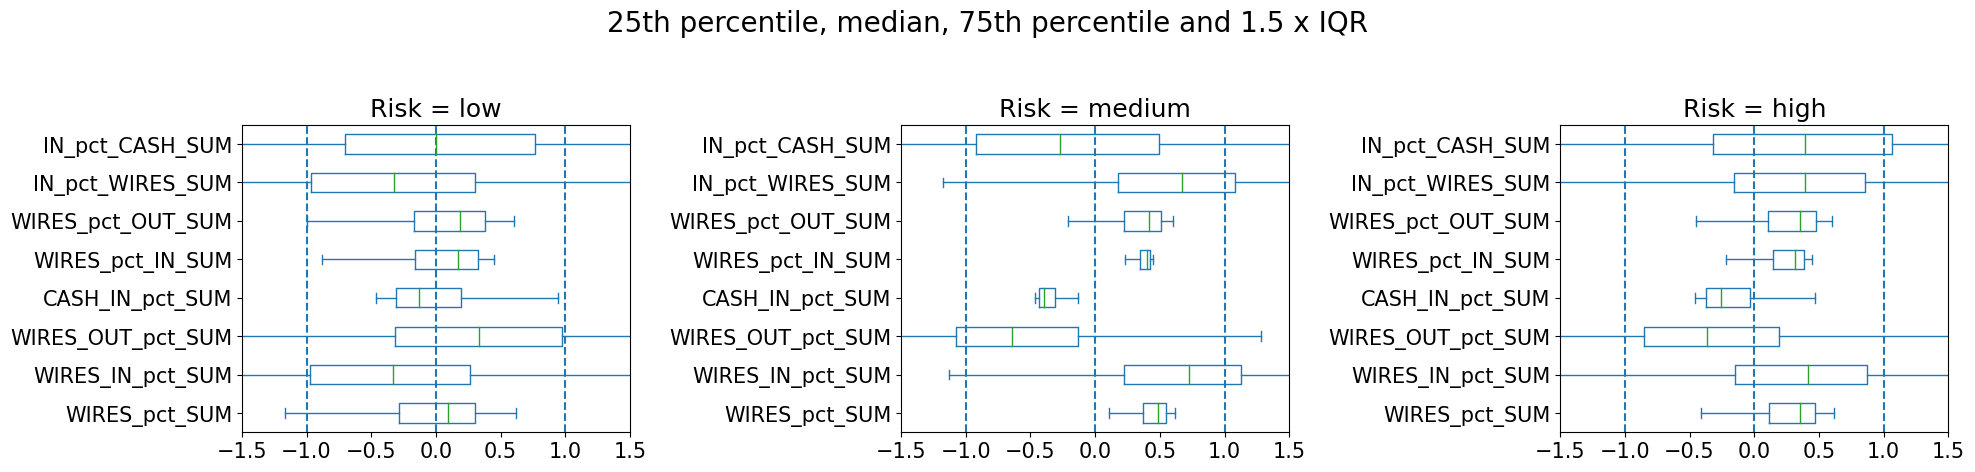

In [ ]:
train_clean2 = copy.deepcopy(train_clean)

train_clean2['TOTAL_SUM'] = (train_clean2.WIRES_SUM_IN + train_clean2.WIRES_SUM_OUT + train_clean2.CASH_SUM_IN + train_clean2.CASH_SUM_OUT)
train_clean2['TOTAL_IN_SUM'] = (train_clean2.WIRES_SUM_IN + train_clean2.CASH_SUM_IN)
train_clean2['TOTAL_OUT_SUM'] = (train_clean2.WIRES_SUM_OUT + train_clean2.CASH_SUM_OUT)
train_clean2['TOTAL_WIRES_SUM'] = (train_clean2.WIRES_SUM_IN + train_clean2.WIRES_SUM_OUT)
train_clean2['TOTAL_CASH_SUM'] = (train_clean2.CASH_SUM_IN + train_clean2.CASH_SUM_OUT)

train_clean2['WIRES_pct_SUM'] = custom_division(train_clean2.TOTAL_WIRES_SUM, train_clean2.TOTAL_SUM)

train_clean2['WIRES_IN_pct_SUM'] = custom_division(train_clean2.WIRES_SUM_IN, train_clean2.TOTAL_SUM)
train_clean2['WIRES_OUT_pct_SUM'] = custom_division(train_clean2.WIRES_SUM_OUT, train_clean2.TOTAL_SUM)
train_clean2['CASH_IN_pct_SUM'] = custom_division(train_clean2.CASH_SUM_IN, train_clean2.TOTAL_SUM)

train_clean2['WIRES_pct_IN_SUM'] = custom_division(train_clean2.WIRES_SUM_IN, train_clean2.TOTAL_IN_SUM)
train_clean2['WIRES_pct_OUT_SUM'] = custom_division(train_clean2.WIRES_SUM_OUT, train_clean2.TOTAL_OUT_SUM)

train_clean2['IN_pct_WIRES_SUM'] = custom_division(train_clean2.WIRES_SUM_IN, train_clean2.TOTAL_WIRES_SUM)
train_clean2['IN_pct_CASH_SUM'] = custom_division(train_clean2.CASH_SUM_IN, train_clean2.TOTAL_CASH_SUM)


train_clean2.drop(columns = [
    # drop TOTAL (only created for ease of calculation)
    'TOTAL_SUM', 'TOTAL_IN_SUM', 'TOTAL_OUT_SUM', 'TOTAL_WIRES_SUM', 'TOTAL_CASH_SUM',
    # drop SUM 
    'WIRES_SUM_IN', 'WIRES_SUM_OUT', 'CASH_SUM_IN', 'CASH_SUM_OUT'

], inplace = True)

plot_percentiles(train_clean2, 'SUM')

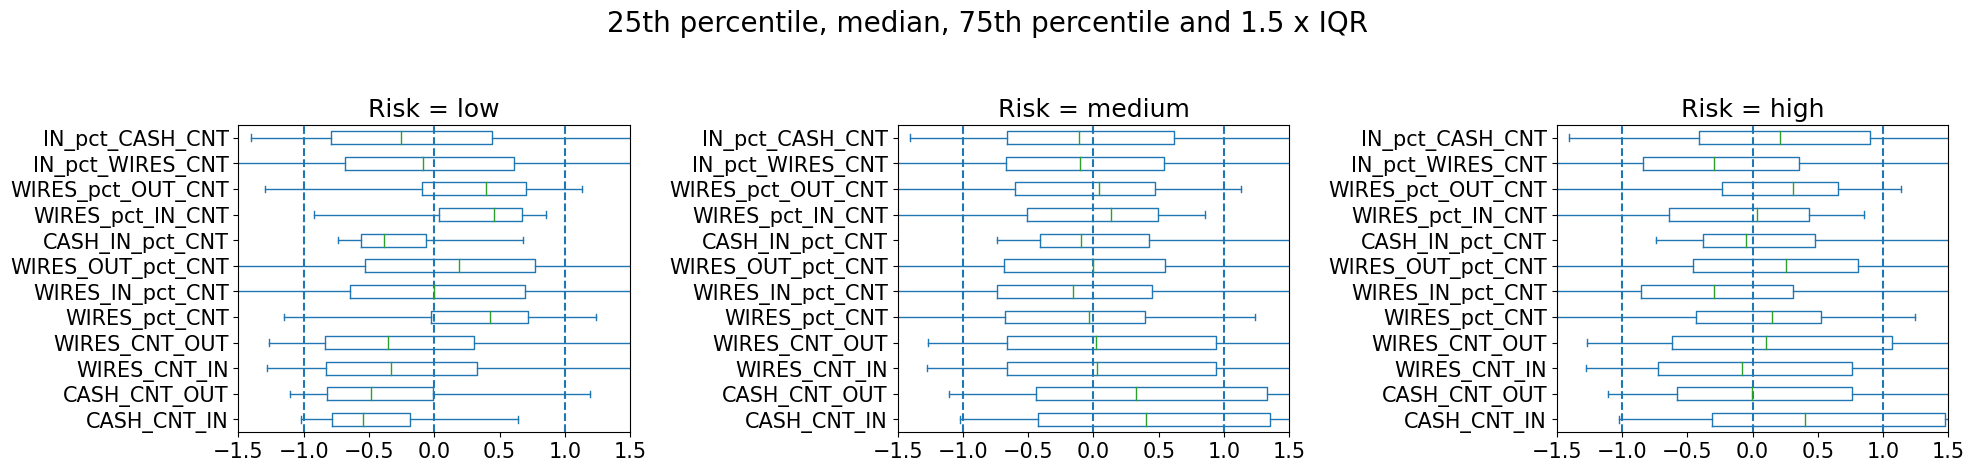

In [ ]:
train_clean2 = copy.deepcopy(train_clean)

train_clean2['TOTAL_CNT'] = (train_clean2.WIRES_CNT_IN + train_clean2.WIRES_CNT_OUT + train_clean2.CASH_CNT_IN + train_clean2.CASH_CNT_OUT)
train_clean2['TOTAL_IN_CNT'] = (train_clean2.WIRES_CNT_IN + train_clean2.CASH_CNT_IN)
train_clean2['TOTAL_OUT_CNT'] = (train_clean2.WIRES_CNT_OUT + train_clean2.CASH_CNT_OUT)
train_clean2['TOTAL_WIRES_CNT'] = (train_clean2.WIRES_CNT_IN + train_clean2.WIRES_CNT_OUT)
train_clean2['TOTAL_CASH_CNT'] = (train_clean2.CASH_CNT_IN + train_clean2.CASH_CNT_OUT)

train_clean2['WIRES_pct_CNT'] = custom_division(train_clean2.TOTAL_WIRES_CNT, train_clean2.TOTAL_CNT)

train_clean2['WIRES_IN_pct_CNT'] = custom_division(train_clean2.WIRES_CNT_IN, train_clean2.TOTAL_CNT)
train_clean2['WIRES_OUT_pct_CNT'] = custom_division(train_clean2.WIRES_CNT_OUT, train_clean2.TOTAL_CNT)
train_clean2['CASH_IN_pct_CNT'] = custom_division(train_clean2.CASH_CNT_IN, train_clean2.TOTAL_CNT)

train_clean2['WIRES_pct_IN_CNT'] = custom_division(train_clean2.WIRES_CNT_IN, train_clean2.TOTAL_IN_CNT)
train_clean2['WIRES_pct_OUT_CNT'] = custom_division(train_clean2.WIRES_CNT_OUT, train_clean2.TOTAL_OUT_CNT)

train_clean2['IN_pct_WIRES_CNT'] = custom_division(train_clean2.WIRES_CNT_IN, train_clean2.TOTAL_WIRES_CNT)
train_clean2['IN_pct_CASH_CNT'] = custom_division(train_clean2.CASH_CNT_IN, train_clean2.TOTAL_CASH_CNT)


train_clean2.drop(columns = [
    # 
    'TOTAL_CNT', 'TOTAL_IN_CNT', 'TOTAL_OUT_CNT', 'TOTAL_WIRES_CNT', 'TOTAL_CASH_CNT'
], inplace = True)

plot_percentiles(train_clean2, 'CNT', ['RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA'])

### ManualTransformer

Normal cost-efficient but slow transactions
- use EMT for small amount
- use wires transfer for large amount
- use as few transactions as possible to save transaction fee
- maximize EMT limit before using wires transfer

Abnormal cost-inefficient but fast transactions
- use as many transactions as possible
- use wires transfer to avoid caps in EMT

Transfer limit
- EMT trasnfer: minimum = CAD0.01, maximum = CAD25k per transaction
- Wire transfer limit: minimum = CAD100
- https://help.scotiabank.com/article/how-much-can-i-send-with-scotia-international-money-transfer?origin=help-center


Money Laundering indicators involving transactions (https://fintrac-canafe.canada.ca/guidance-directives/transaction-operation/indicators-indicateurs/fin_mltf-eng)
- Client frequents multiple locations utilizing cash, prepaid credit cards or money orders/cheques/drafts to send wire transfers overseas.
  - high count of transactions
- Funds are deposited or received into several accounts and then consolidated into one before transferring the funds outside the country.
  - multiple IN_CNT
  - there are no limits in accepting e-transfer https://help.scotiabank.com/article/are-there-interac-e-transfer-limits?origin=scotia-connect
- Immediately after transferred funds have cleared, the client moves funds, to another account or to another person or entity.
  - IN_SUM similar to OUT_SUM
- Client sending to, or receiving wire transfers from, multiple clients.
  - high IN_CNT, high OUT_CNT

Feature creation
- missingness in NAME
  - inability to properly identify the client or there are questions surrounding the client's identity
- AGE (float) = (Today (2023 Jan 01) - BIRTH_DT) / 365.25
- HIST_JOIN (float) = Age when customer joined = (CUST_ADD_DT - BIRTH_DT) / 365.25
- AVG
  - WIRES_AVG_IN
  - WIRES_AVG_OUT
  - CASH_AVG_IN
  - CASH_AVG_OUT
  - drop data entry errors

- ratio of AVG
  - WIRES vs CASH
    - WIRES_VS_CASH_AVG
  - WIRES_IN vs WIRES_OUT
    - IN_VS_OUT_WIRES_AVG
  - CASH_IN vs CASH_OUT
    - IN_VS_OUT_CASH_AVG
- % of CNT
  - % of TOTAL_CNT
    - WIRES_pct_CNT
  - % of TOTAL_WIRES_CNT
    - IN_pct_WIRES_CNT
  - % of TOTAL_CASH_CNT
    - IN_pct_CASH_CNT
- ratio of CNT vs AVG
  - WIRES_IN_CNT_VS_AVG
  - WIRES_OUT_CNT_VS_AVG
  - CASH_IN_CNT_VS_AVG
  - CASH_OUT_CNT_VS_AVG

Drop
  - NAME, BIRTH_DT, CUST_ADD_DT
  - SUM: CASH_SUM_IN, CASH_SUM_OUT, WIRES_SUM_IN, WIRES_SUM_OUT
  - helper columns for SUM, CNT and AVG



In [ ]:
dataset_preparation = make_pipeline(
    ManualTransformer()
)

In [ ]:
train_clean = dataset_preparation.fit_transform(train_set)
train_clean

GENDER occupation_risk RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  \
0       Female             Low            1                  1      0   
1         Male             Low            1                  1      0   
2         Male             Low            1                  1      0   
3         Male            High            1                  1      0   
4         Male             Low            1                  1      1   
...        ...             ...          ...                ...    ...   
799995  Female        Moderate            1                  1      0   
799996    Male             Low            1                  1      1   
799997    Male             Low            1                  1      0   
799998  Female             Low            1                  1      0   
799999    Male             Low            1                  1      0   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  CASH_CNT_IN  CASH_CNT_OUT  \
0                      Low                    Low       6.0000       18.0000   
1                      Low                    Low      25.0000       18.0000   
2                      Low                    Low       0.0000       18.0000   
3                      Low                    Low      13.0000       15.0000   
4                      Low                    Low       7.0000        3.0000   
...                    ...                    ...          ...           ...   
799995                 Low                    Low       2.0000       17.0000   
799996                 Low                    Low      13.0000       50.0000   
799997                 Low                    Low       9.0000        9.0000   
799998                 Low                    Low       2.0000        4.0000   
799999                 Low                    Low       3.0000       18.0000   

        WIRES_CNT_IN  WIRES_CNT_OUT    RISK MISSING_NAME DIFF_CNTRY     AGE  \
0           115.0000       209.0000     low            0          0 36.1780   
1            14.0000        90.0000  medium            0          0 72.2218   
2            21.0000        10.0000     low            0          0 26.0205   
3            68.0000       116.0000  medium            0          0 57.6619   
4            15.0000        20.0000  medium            0          0 96.4709   
...              ...            ...     ...          ...        ...     ...   
799995       73.0000        92.0000     low            0          0 17.9822   
799996      181.0000       110.0000    high            0          0 69.0459   
799997       56.0000        69.0000     low            0          0 71.4634   
799998       75.0000       118.0000     low            0          0 22.9733   
799999       30.0000        77.0000     low            0          0 39.2088   

        HIST_JOIN  WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  CASH_AVG_OUT  \
0         11.8330    2,635.3043     1,252.7656     642.4963      377.5347   
1         14.5955  443,379.4286    53,721.0333   2,414.0000    1,705.6111   
2          5.9685    1,668.6667       669.8000       0.0000      324.1188   
3          9.3032   51,732.8382    20,941.4914   2,019.9231    2,394.8000   
4         37.2649   63,405.8000    73,977.0500   2,241.1429      811.0000   
...           ...           ...            ...          ...           ...   
799995    14.7269    2,319.8219     1,399.2826     399.8605      460.2096   
799996    39.9398   19,566.7348     5,897.5636   1,826.1362      830.8400   
799997    35.6797    2,809.4464     1,416.7391   1,095.4632      373.5239   
799998    15.9179    1,210.0667       612.8559     198.5500      260.7985   
799999     5.2567    3,161.4333     1,692.5584     932.2777      302.9082   

       DATA_ENTRY_ERROR       TOTAL_SUM  WIRES_VS_CASH_AVG  \
0                     0    575,538.6020             3.9288   
1                     0 11,133,256.0000            50.1425   
2                     1     47,739.7450             4.0395   
3                     0  6,009,227.0000         

## Outliers removal
- Check min, max or IQR
  - Alternative: isolation forest (less interpretable)
- Outliers
  - min and max AGE seems wrong (3 and 142 years old)
    - [Scotiabank: No limit in minimum age](https://www.scotiabank.com/ca/en/personal/bank-accounts/students/getting-there-savings-program-youth.html#:~:text=Children%20under%2012%20must%20be,able%20to%20provide%20adequate%20ID.) as children under 12 can open an account while being accompanied by a parent or legal guardian 
    - Oldest person living = [(Guineness Record) 118 years old](https://www.guinnessworldrecords.com/world-records/84549-oldest-person-living)
  - min WIRES_AVG_IN and WIRES_AVG_OUT should be at least CAD100? https://help.scotiabank.com/article/how-much-can-i-send-with-scotia-international-money-transfer?origin=help-center 
- Binning data with QuantileTransformer

In [ ]:
train_clean.describe()

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT          AGE  \
count 800,000.0000  800,000.0000  800,000.0000   800,000.0000 800,000.0000   
mean        8.5951       23.1592       85.3944       152.4242      50.8303   
std         8.4219       20.8901       66.7842       120.1834      18.2407   
min         0.0000        0.0000        0.0000         0.0000       3.2580   
25%         3.0000        8.0000       33.0000        59.0000      38.1328   
50%         6.0000       17.0000       71.0000       126.0000      50.7789   
75%        11.0000       32.0000      122.0000       218.0000      63.2854   
max        79.0000      198.0000      605.0000     1,083.0000     142.3053   

         HIST_JOIN    WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  CASH_AVG_OUT  \
count 796,725.0000    800,000.0000   800,000.0000 800,000.0000  800,000.0000   
mean       18.3914     63,414.8210    13,737.9933   1,422.3657      855.6668   
std         9.9371    246,922.3410    54,883.3854   1,097.5236      860.6347   
min         0.4353          0.0000         0.0000       0.0000        0.0000   
25%        10.8118      2,108.1064     1,099.1066     721.6862      315.4243   
50%        17.6591      4,240.4129     1,854.4873     982.0307      437.0512   
75%        25.0103     58,534.5541    13,293.7761   2,045.3333    1,286.0755   
max        73.8891 26,065,364.0000 6,227,514.0000  21,692.0000   28,133.0000   

            TOTAL_SUM  WIRES_VS_CASH_AVG  IN_VS_OUT_WIRES_AVG  \
count    800,000.0000       800,000.0000         800,000.0000   
mean   4,832,731.6247            16.9538               3.8296   
std    7,736,555.0512            51.2572               5.4781   
min          300.7650             0.0000               0.0000   
25%      253,612.2502             3.1037               1.6726   
50%      558,998.6025             5.3212               2.5272   
75%    7,030,392.5000            17.5187               4.3858   
max   62,600,692.0000         9,785.2173           1,001.0068   

       IN_VS_OUT_CASH_AVG  WIRES_pct_CNT  IN_pct_WIRES_CNT  IN_pct_CASH_CNT  \
count        800,000.0000   800,000.0000      800,000.0000     800,000.0000   
mean               2.1514         0.8554            0.3780           0.3048   
std                1.5801         0.1166            0.1790           0.2165   
min                0.0000         0.0000            0.0000           0.0000   
25%                1.3239         0.8211            0.2547           0.1429   
50%                1.9691         0.8869            0.3597           0.2593   
75%                2.7006         0.9291            0.4807           0.4194   
max              427.0222         1.0000            1.0000           1.0000   

       WIRES_IN_CNT_VS_AVG  WIRES_OUT_CNT_VS_AVG  CASH_IN_CNT_VS_AVG  \
count         800,000.0000          800,000.0000        800,000.0000   
mean                0.0266                0.0851              0.0067   
std                 0.0503                0.1174              0.0054   
min                 0.0000                0.0000              0.0000   
25%                 0.0014                0.0098              0.0025   
50%                 0.0083                0.0400              0.0055   
75%                 0.0371                0.1256              0.0098   
max                10.9700               22.7611              0.0506   

       CASH_OUT_CNT_VS_AVG  CASH_BALANCE   WIRES_BALANCE  
count         800,000.0000  800,000.0000    800,000.0000  
mean                0.0403   -8,323.3324  2,027,911.8426  
std                 0.0356   27,050.5428  4,030,526.5138  
min                 0.0000 -261,308.0000 -8,245,232.0000  
25%                 0.0130   -8,908.7952    -16,767.0000  
50%                 0.0307   -1,815.3900     82,362.5000  
75%                 0.0577    2,002.0110  2,318,966.0000  
max                 0.3934  149,791.4900 36,581,952.0000

In [ ]:
outlier_df = train_set.loc[train_clean[train_clean.AGE >= 118].index, ['NAME', 'BIRTH_DT', 'RISK']].sort_values('BIRTH_DT')
outlier_df

NAME   BIRTH_DT RISK
681659  Kessler, Sherry Dusel Vanmeter 1880-09-10  low
434473       Rebecca Mayne Newman Paik 1884-08-18  low
562348         Angel Minor paocs Marsh 1887-03-31  low
485288  Shane Robertson Gauted Denison 1887-07-14  low
78617              Sharon Eunabks Jobe 1891-07-16  low
...                                ...        ...  ...
749908     Dunaway, Joseph Mangon Shea 1904-11-06  low
164113          Colucci, Lora Yingling 1904-11-16  low
73398               Reese, Robert Tran 1904-11-23  low
387780       Jacqueline Manning Howard 1904-11-27  low
258430            Louise Reid Brentley 1904-12-06  low

[124 rows x 3 columns]

In [ ]:
outlier_df.RISK.value_counts()

low       124
medium      0
high        0
Name: RISK, dtype: int64

In [ ]:
dataset_preparation.steps.append(('outlierremoval', OutlierRemoval()))

In [ ]:
dataset_preparation

Pipeline(steps=[('manualtransformer', ManualTransformer()),
                ('outlierremoval', OutlierRemoval())])

In [ ]:
dataset_preparation.fit(train_set)
train_clean = dataset_preparation.transform(train_set)
train_clean

GENDER occupation_risk RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  \
0       Female             Low            1                  1      0   
1         Male             Low            1                  1      0   
2         Male             Low            1                  1      0   
3         Male            High            1                  1      0   
4         Male             Low            1                  1      1   
...        ...             ...          ...                ...    ...   
799995  Female        Moderate            1                  1      0   
799996    Male             Low            1                  1      1   
799997    Male             Low            1                  1      0   
799998  Female             Low            1                  1      0   
799999    Male             Low            1                  1      0   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  CASH_CNT_IN  CASH_CNT_OUT  \
0                      Low                    Low       6.0000       18.0000   
1                      Low                    Low      25.0000       18.0000   
2                      Low                    Low       0.0000       18.0000   
3                      Low                    Low      13.0000       15.0000   
4                      Low                    Low       7.0000        3.0000   
...                    ...                    ...          ...           ...   
799995                 Low                    Low       2.0000       17.0000   
799996                 Low                    Low      13.0000       50.0000   
799997                 Low                    Low       9.0000        9.0000   
799998                 Low                    Low       2.0000        4.0000   
799999                 Low                    Low       3.0000       18.0000   

        WIRES_CNT_IN  WIRES_CNT_OUT    RISK MISSING_NAME DIFF_CNTRY     AGE  \
0           115.0000       209.0000     low            0          0 36.1780   
1            14.0000        90.0000  medium            0          0 72.2218   
2            21.0000        10.0000     low            0          0 26.0205   
3            68.0000       116.0000  medium            0          0 57.6619   
4            15.0000        20.0000  medium            0          0 96.4709   
...              ...            ...     ...          ...        ...     ...   
799995       73.0000        92.0000     low            0          0 17.9822   
799996      181.0000       110.0000    high            0          0 69.0459   
799997       56.0000        69.0000     low            0          0 71.4634   
799998       75.0000       118.0000     low            0          0 22.9733   
799999       30.0000        77.0000     low            0          0 39.2088   

        HIST_JOIN  WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  CASH_AVG_OUT  \
0         11.8330    2,635.3043     1,252.7656     642.4963      377.5347   
1         14.5955  443,379.4286    53,721.0333   2,414.0000    1,705.6111   
2          5.9685    1,668.6667       669.8000       0.0000      324.1188   
3          9.3032   51,732.8382    20,941.4914   2,019.9231    2,394.8000   
4         37.2649   63,405.8000    73,977.0500   2,241.1429      811.0000   
...           ...           ...            ...          ...           ...   
799995    14.7269    2,319.8219     1,399.2826     399.8605      460.2096   
799996    39.9398   19,566.7348     5,897.5636   1,826.1362      830.8400   
799997    35.6797    2,809.4464     1,416.7391   1,095.4632      373.5239   
799998    15.9179    1,210.0667       612.8559     198.5500      260.7985   
799999     5.2567    3,161.4333     1,692.5584     932.2777      302.9082   

       DATA_ENTRY_ERROR       TOTAL_SUM  WIRES_VS_CASH_AVG  \
0                     0    575,538.6020             3.9288   
1                     0 11,133,256.0000            50.1425   
2                     1     47,739.7450             4.0395   
3                     0  6,009,227.0000         

## dump as dataset_preparation.joblib

In [ ]:
dump(dataset_preparation, f'dataset_preparation.joblib') 

['dataset_preparation.joblib']

## load dataset_preparation()

In [ ]:
dataset_preparation = load('dataset_preparation.joblib')
dataset_preparation

Pipeline(steps=[('manualtransformer', ManualTransformer()),
                ('outlierremoval', OutlierRemoval())])

# X, y, sample weights split()

In [ ]:
# make a copy and split X and y
X_train = train_clean.drop(columns = ["RISK", "TOTAL_SUM"]).reset_index(drop = True).copy(deep = True)
y_train = train_clean["RISK"].reset_index(drop = True)
sample_weights_train = train_clean["TOTAL_SUM"].reset_index(drop = True)

# Exploratory data analysis (EDA)
- Check if all the information needed (to solve the data mining goals) is actually available
- what additional information would be helpful?
- Analyze basic statistics and relate the results to their meaning in business terms

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799876 entries, 0 to 799875
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   GENDER                  799350 non-null  category
 1   occupation_risk         794764 non-null  category
 2   RES_CNTRY_CA            799876 non-null  category
 3   CNTRY_OF_INCOME_CA      799876 non-null  category
 4   PEP_FL                  799876 non-null  category
 5   COUNTRY_RISK_INCOME     799876 non-null  category
 6   COUNTRY_RISK_RESIDENCY  799876 non-null  category
 7   CASH_CNT_IN             799876 non-null  float64 
 8   CASH_CNT_OUT            799876 non-null  float64 
 9   WIRES_CNT_IN            799876 non-null  float64 
 10  WIRES_CNT_OUT           799876 non-null  float64 
 11  MISSING_NAME            799876 non-null  category
 12  DIFF_CNTRY              799876 non-null  category
 13  AGE                     799876 non-null  float64 
 14  HIST

## nominal, ordinal, ratio scale
- nominal
  - order doesn't matter
- ordinal
  - order matters but difference is not in fixed interval
- interval
  - order matters + fixed interval 
- ratio
  - order matters + fixed interval + only positive

## Univariate analysis
- compute basic statistics (e.g., compute distribution, average, max, min, standard deviation, variance, mode, skewness, etc.)
- histogram

### Numerical
- WIRES_AVG >> CASH_AVG
- WIRES_CNT >> CASH_CNT
- Outliers
  - min and max AGE seems wrong (3 and 142 years old)
  - min WIRES_AVG_IN and WIRES_AVG_OUT should be at least CAD100?

In [ ]:
# numeric columns
X_train.describe(exclude='category')

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT          AGE  \
count 799,876.0000  799,876.0000  799,876.0000   799,876.0000 799,876.0000   
mean        8.5958       23.1592       85.3958       152.4303      50.8193   
std         8.4222       20.8908       66.7855       120.1870      18.2205   
min         0.0000        0.0000        0.0000         0.0000       3.2580   
25%         3.0000        8.0000       33.0000        59.0000      38.1300   
50%         6.0000       17.0000       71.0000       126.0000      50.7734   
75%        11.0000       32.0000      122.0000       218.0000      63.2799   
max        79.0000      198.0000      605.0000     1,083.0000     117.9904   

         HIST_JOIN    WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  CASH_AVG_OUT  \
count 796,602.0000    799,876.0000   799,876.0000 799,876.0000  799,876.0000   
mean       18.3878     63,423.9817    13,739.8088   1,422.4778      855.7444   
std         9.9330    246,940.3777    54,887.4396   1,097.5609      860.6779   
min         0.4353          0.0000         0.0000       0.0000        0.0000   
25%        10.8118      2,108.0962     1,099.0915     721.7201      315.4328   
50%        17.6564      4,240.9693     1,854.5982     982.1253      437.0924   
75%        25.0048     58,549.2500    13,295.9467   2,045.5000    1,286.2131   
max        73.8891 26,065,364.0000 6,227,514.0000  21,692.0000   28,133.0000   

       WIRES_VS_CASH_AVG  IN_VS_OUT_WIRES_AVG  IN_VS_OUT_CASH_AVG  \
count       797,058.0000         799,876.0000        799,876.0000   
mean             17.0153               3.8299              2.1515   
std              51.3415               5.4785              1.5801   
min               0.0000               0.0000              0.0000   
25%               3.1218               1.6727              1.3239   
50%               5.3462               2.5274              1.9691   
75%              17.6065               4.3862              2.7006   
max           9,785.2173           1,001.0068            427.0222   

       WIRES_pct_CNT  IN_pct_WIRES_CNT  IN_pct_CASH_CNT  WIRES_IN_CNT_VS_AVG  \
count   799,876.0000      799,876.0000     799,876.0000         799,876.0000   
mean          0.8554            0.3780           0.3048               0.0266   
std           0.1166            0.1790           0.2165               0.0503   
min           0.0000            0.0000           0.0000               0.0000   
25%           0.8211            0.2547           0.1429               0.0014   
50%           0.8869            0.3597           0.2593               0.0083   
75%           0.9292            0.4807           0.4194               0.0371   
max           1.0000            1.0000           1.0000              10.9700   

       WIRES_OUT_CNT_VS_AVG  CASH_IN_CNT_VS_AVG  CASH_OUT_CNT_VS_AVG  \
count          799,876.0000        799,876.0000         799,876.0000   
mean                 0.0851              0.0067               0.0403   
std                  0.1174              0.0054               0.0356   
min                  0.0000              0.0000               0.0000   
25%                  0.0098              0.0025               0.0130   
50%                  0.0400              0.0055               0.0307   
75%                  0.1256              0.0098               0.0577   
max                 22.7611              0.0506               0.3934   

       CASH_BALANCE   WIRES_BALANCE  
count  799,876.0000    799,876.0000  
mean    -8,323.8690  2,028,216.5298  
std     27,052.5238  4,030,764.3958  
min   -261,308.0000 -8,245,232.0000  
25%     -8,909.0287    -16,769.7500  
50%     -1,814.9595     82,371.0000  
75%      2,002.6255  2,319,931.0000  
max    149,791.4900 36,581,952.0000

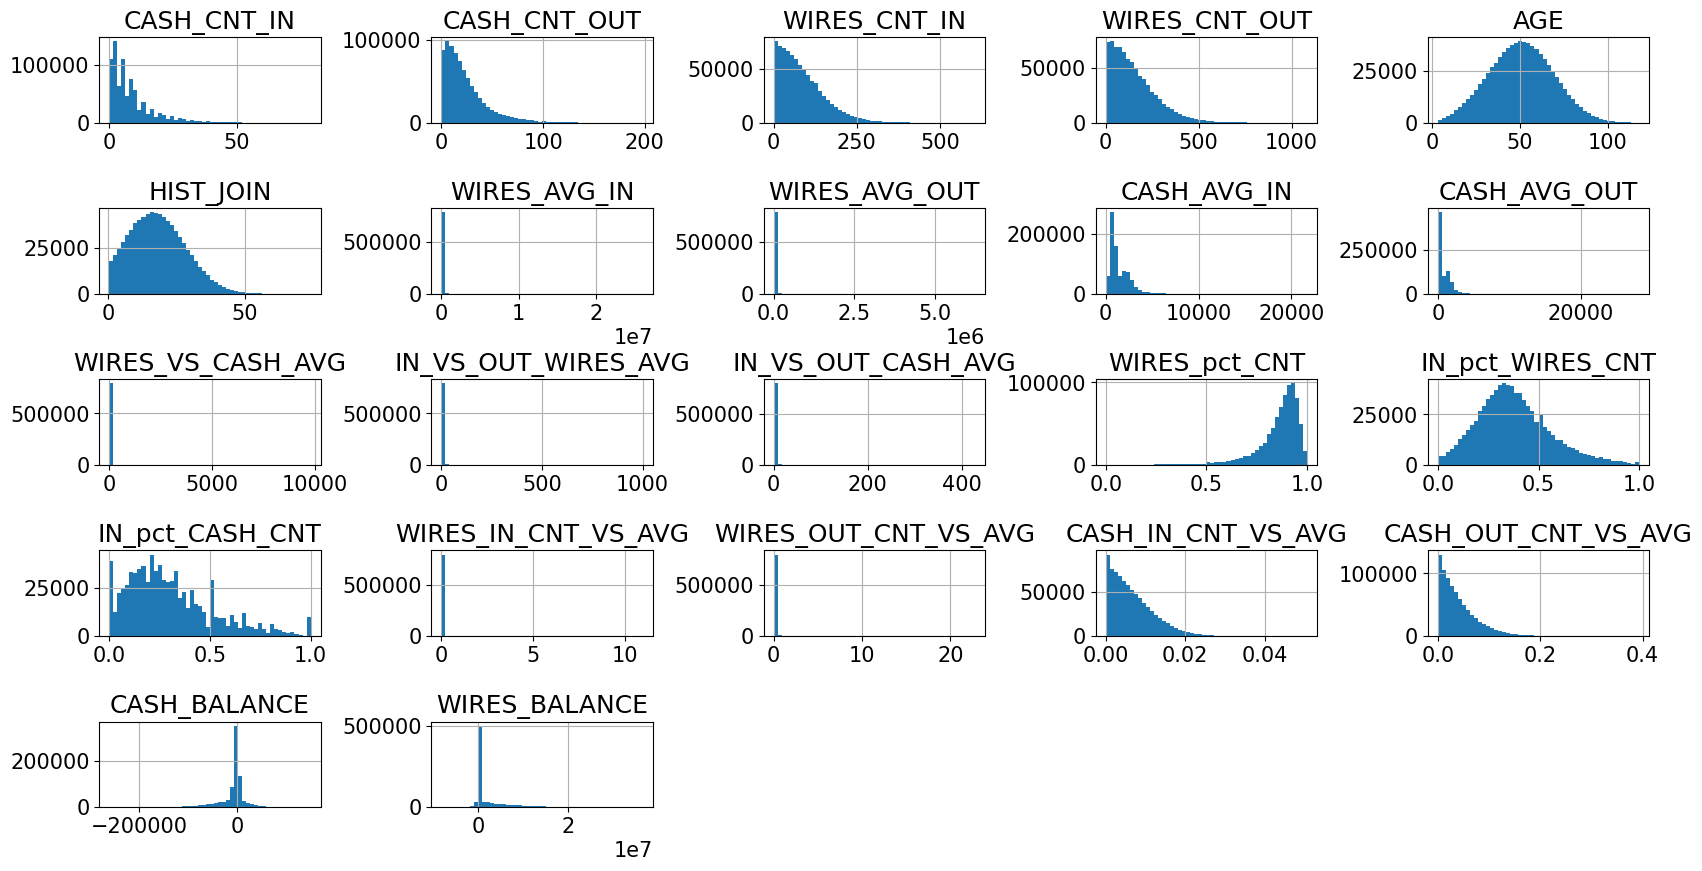

In [ ]:
X_train.hist(bins = 50, layout = (5, int(X_train.select_dtypes(include = np.number).shape[1] / 5) + 1), figsize= (20,10))
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

### Categorical
- These categorical features have > 90% in 1 category
  - RES_CNTRY_CA
  - CNTRY_OF_INCOME_CA
  - PEP_FL
  - COUNTRY_RISK_INCOME
  - COUNTRY_RISK_RESIDENCY

In [ ]:
# category columns
X_train.describe(include='category')

GENDER occupation_risk  RES_CNTRY_CA  CNTRY_OF_INCOME_CA  PEP_FL  \
count   799350          794764        799876              799876  799876   
unique       2               3             2                   2       2   
top     Female             Low             1                   1       0   
freq    438958          511951        788437              790701  721937   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  MISSING_NAME  DIFF_CNTRY  \
count               799876                 799876        799876      799876   
unique                   3                      3             2           2   
top                    Low                    Low             0           0   
freq                797091                 791961        799326      780134   

        DATA_ENTRY_ERROR  
count             799876  
unique                 2  
top                    0  
freq              749765

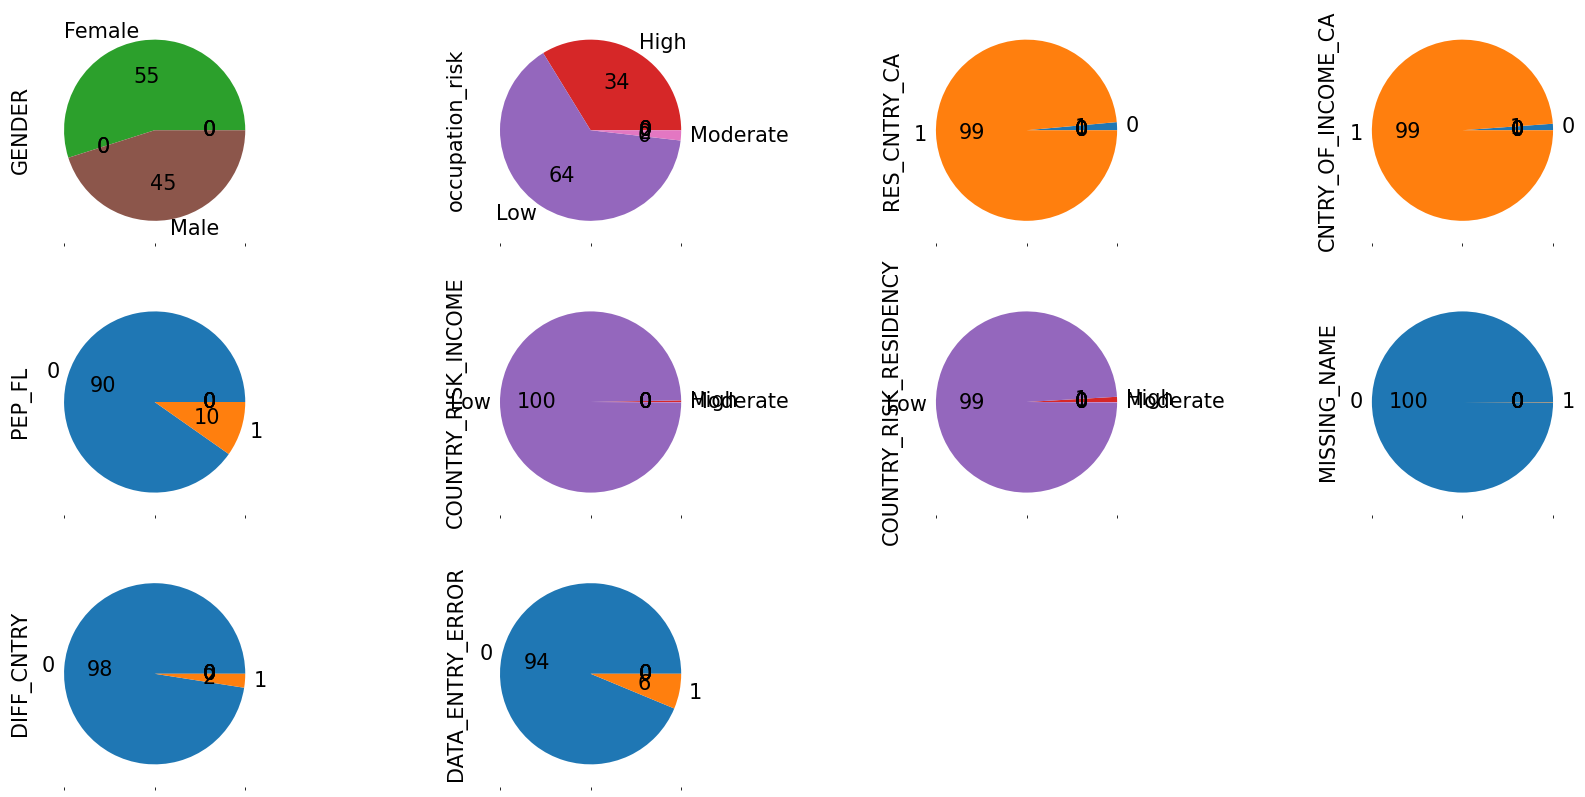

In [ ]:
X_train.select_dtypes(include = 'category').apply(lambda x: x.value_counts(normalize=True)).\
plot(kind = 'pie', subplots = True, autopct='%.0f', layout = (3,4), figsize = (20, 10), legend = False)
plt.subplots_adjust(wspace = 0.8)
plt.show()

### Class imbalance

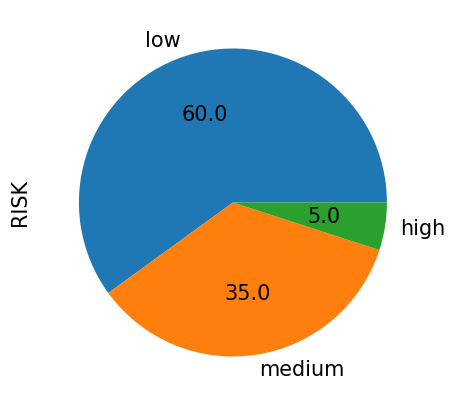

In [ ]:
y_train.value_counts(normalize=True).plot(kind = 'pie', autopct='%.1f', figsize = (5, 5), legend = False)
plt.show()

## Multivariate analysis



### Correlation
- numerical vs numerical
  - correlation matrix
  - sns pairplot
- categorical vs categorical
  - uncertainty coefficient (asymmetrical information)
- numerical vs categorical
  - grouped bar chart

#### Numerical

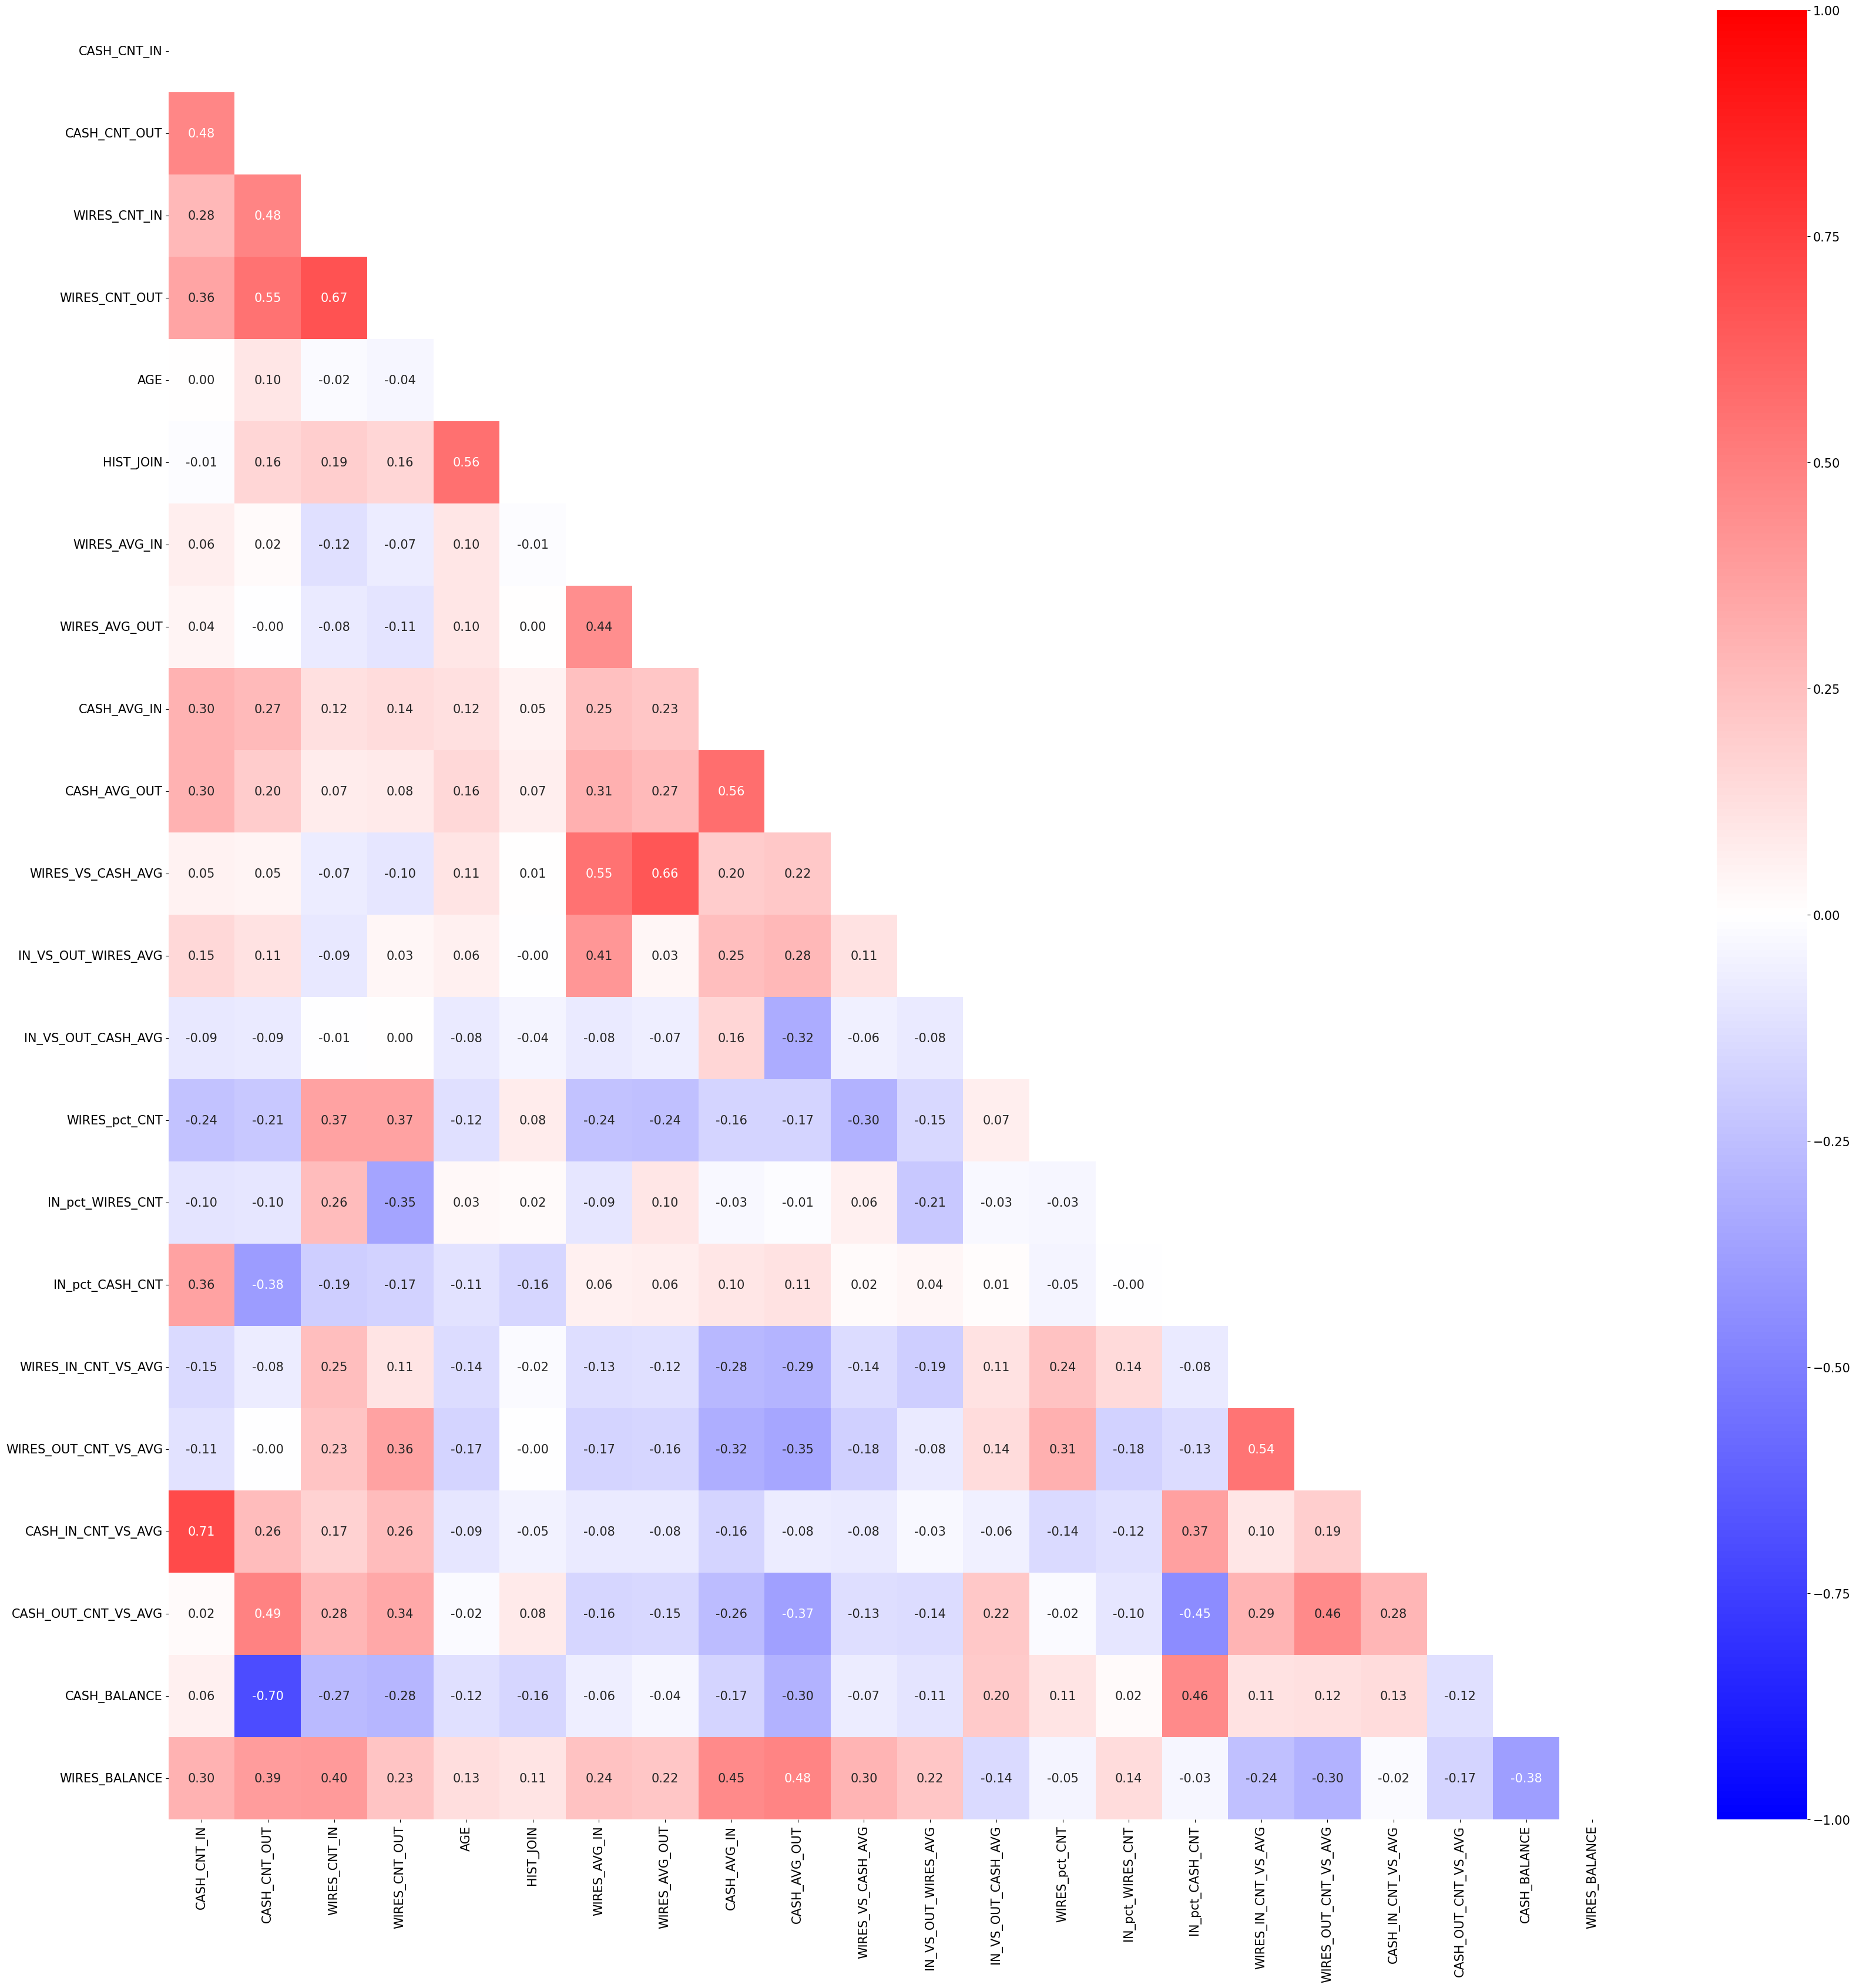

In [ ]:
corr_mat = X_train.corr()
plt.figure(figsize=(40,40))
sns.heatmap(
    corr_mat, 
    annot=True, 
    vmin=-1, vmax=1, 
    mask = np.triu(corr_mat),  # to show only lower triangle
    cmap = 'bwr',
    fmt = '.2f') 
plt.show()

#### Categorical

In [ ]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://www.kaggle.com/code/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival/notebook
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [ ]:
uncertainty_coef = pd.DataFrame([(col1, col2, theil_u(train_clean[col1], train_clean[col2])) for col1, col2 in permutations(pd.concat([X_train.select_dtypes('category'), y_train], axis=1), 2)],
                                columns =['if we know', 'do we know', 'theil_U'])

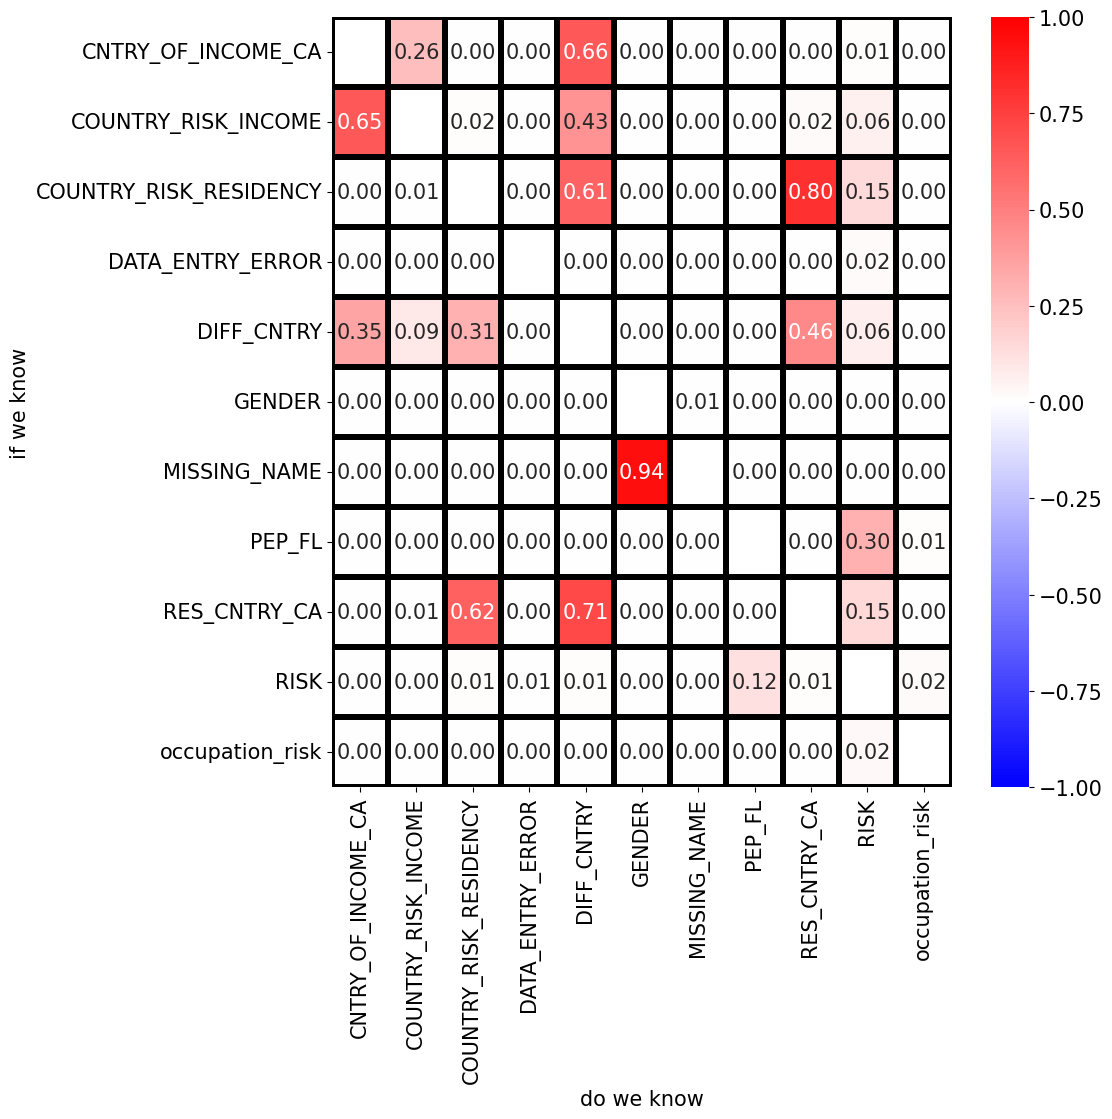

In [ ]:
uncertainty_coef = uncertainty_coef.pivot(index = 'if we know', columns = 'do we know', values = 'theil_U')
plt.figure(figsize=(10,10))
sns.heatmap(
    uncertainty_coef, 
    annot=True, 
    vmin=-1, vmax=1, 
    # mask = np.triu(corr_mat),  # asymmetrical dependence
    cmap = 'bwr',
    linewidths=4, 
    linecolor='black',
    fmt = '.2f') 
plt.show()

In [ ]:
pd.crosstab(X_train.MISSING_NAME, X_train.GENDER)

GENDER        Female    Male
MISSING_NAME                
0             438943  360383
1                 15       9

In [ ]:
pd.crosstab(X_train.COUNTRY_RISK_RESIDENCY, X_train.RES_CNTRY_CA)

RES_CNTRY_CA               0       1
COUNTRY_RISK_RESIDENCY              
Low                     3524  788437
Moderate                 545       0
High                    7370       0

### Correlation with target variable
- kde density plot with hue = target (stacked = True / False)
- hexagon plot of 2 numerical with hue = target
- numerical
  - cut into bins -> cross tab with y
- categorical 
  - cross tab with y

#### Without transformation

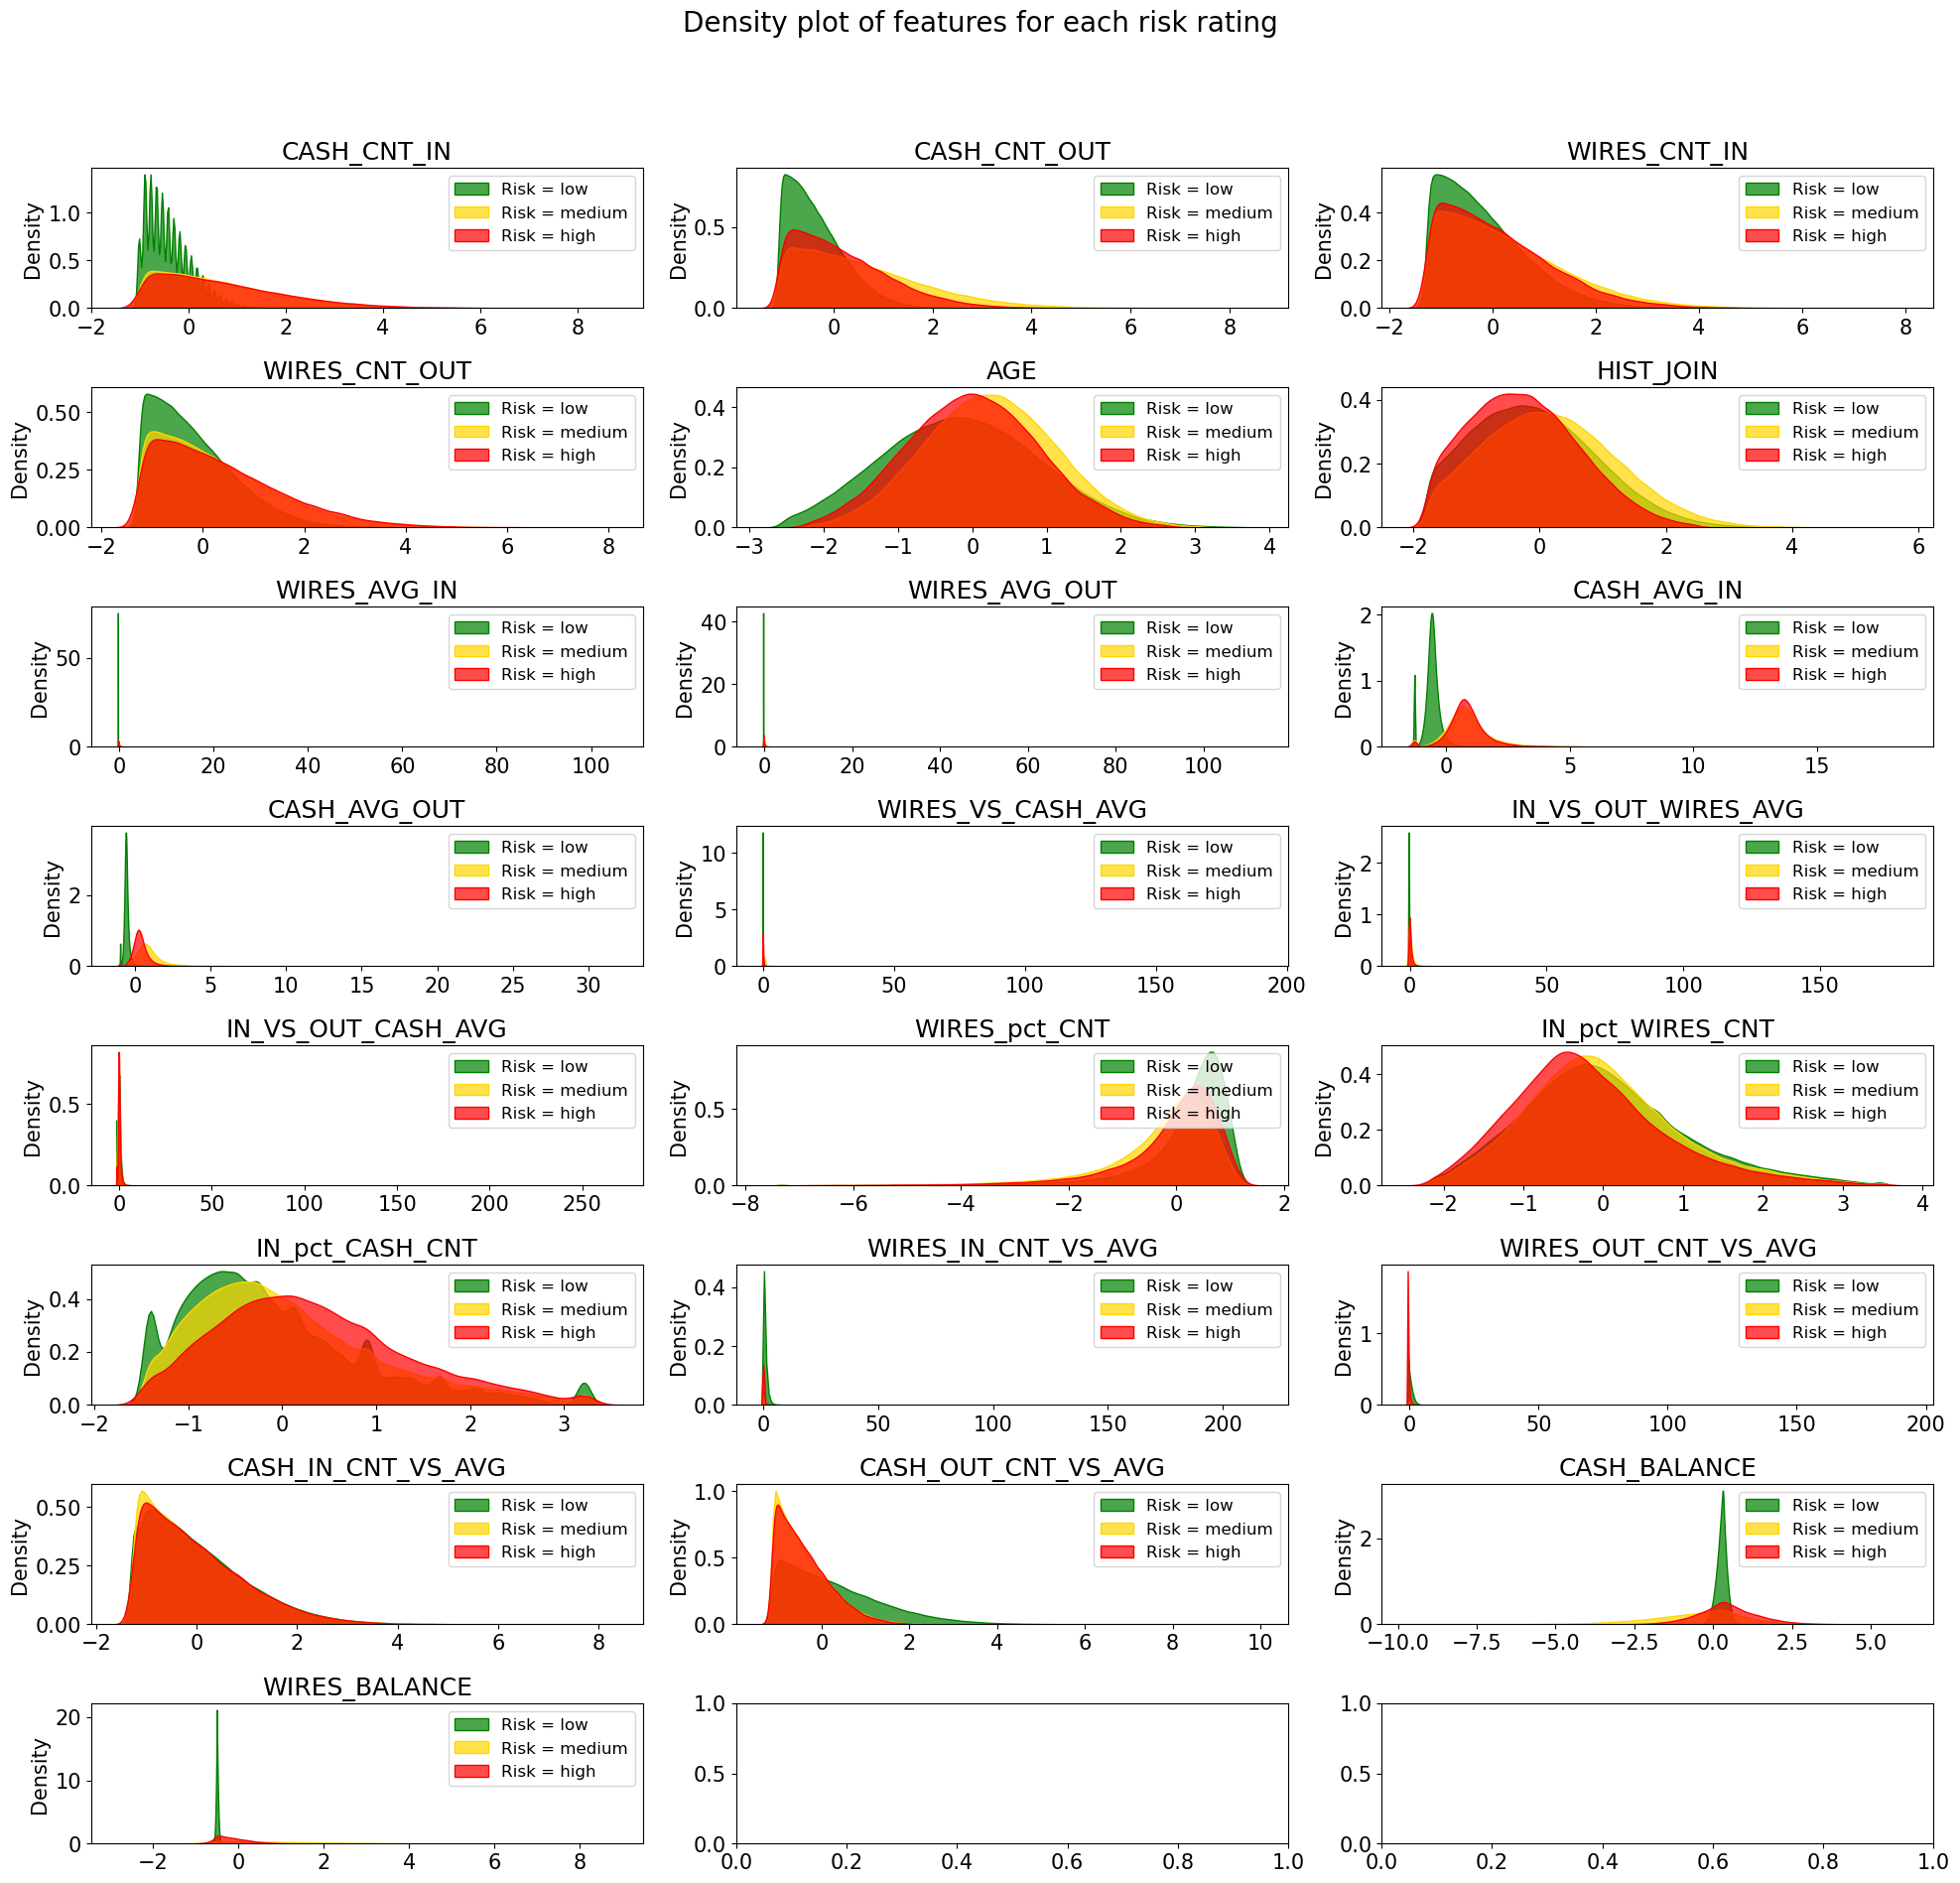

In [ ]:
# Univariate density plot by RISK rating
fig, axes = plt.subplots(8,int((X_train.select_dtypes(np.number).shape[1] - 2) // 8) + 1,figsize=(20,20))

norm_clean = pd.concat([
    X_train.select_dtypes(np.number).apply(lambda x: (x - x.mean()) / x.std()),
    y_train], axis = 1)

for ax, col in zip(axes.flatten(), X_train.select_dtypes(np.number).columns):
  for risk, color in zip(y_train.cat.categories, ['green', 'gold', 'red']):
    try:
      sns.kdeplot(norm_clean.loc[norm_clean['RISK'] == risk, col], fill=True, label=f"Risk = {risk}", alpha=.7, ax=ax, warn_singular=False, 
                  gridsize=200, legend = True, color = color)
    except LinAlgError:
      print(f"only 1 unique value of {norm_clean.loc[norm_clean['cluster'] == risk, col].unique()[0]:0.3f} for {col} in risk {risk}")
  ax.set_title(col)
  ax.legend(loc = 'upper right', prop={'size': 12})
  ax.set_xlabel('')

fig.suptitle('Density plot of features for each risk rating', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Normal distribution

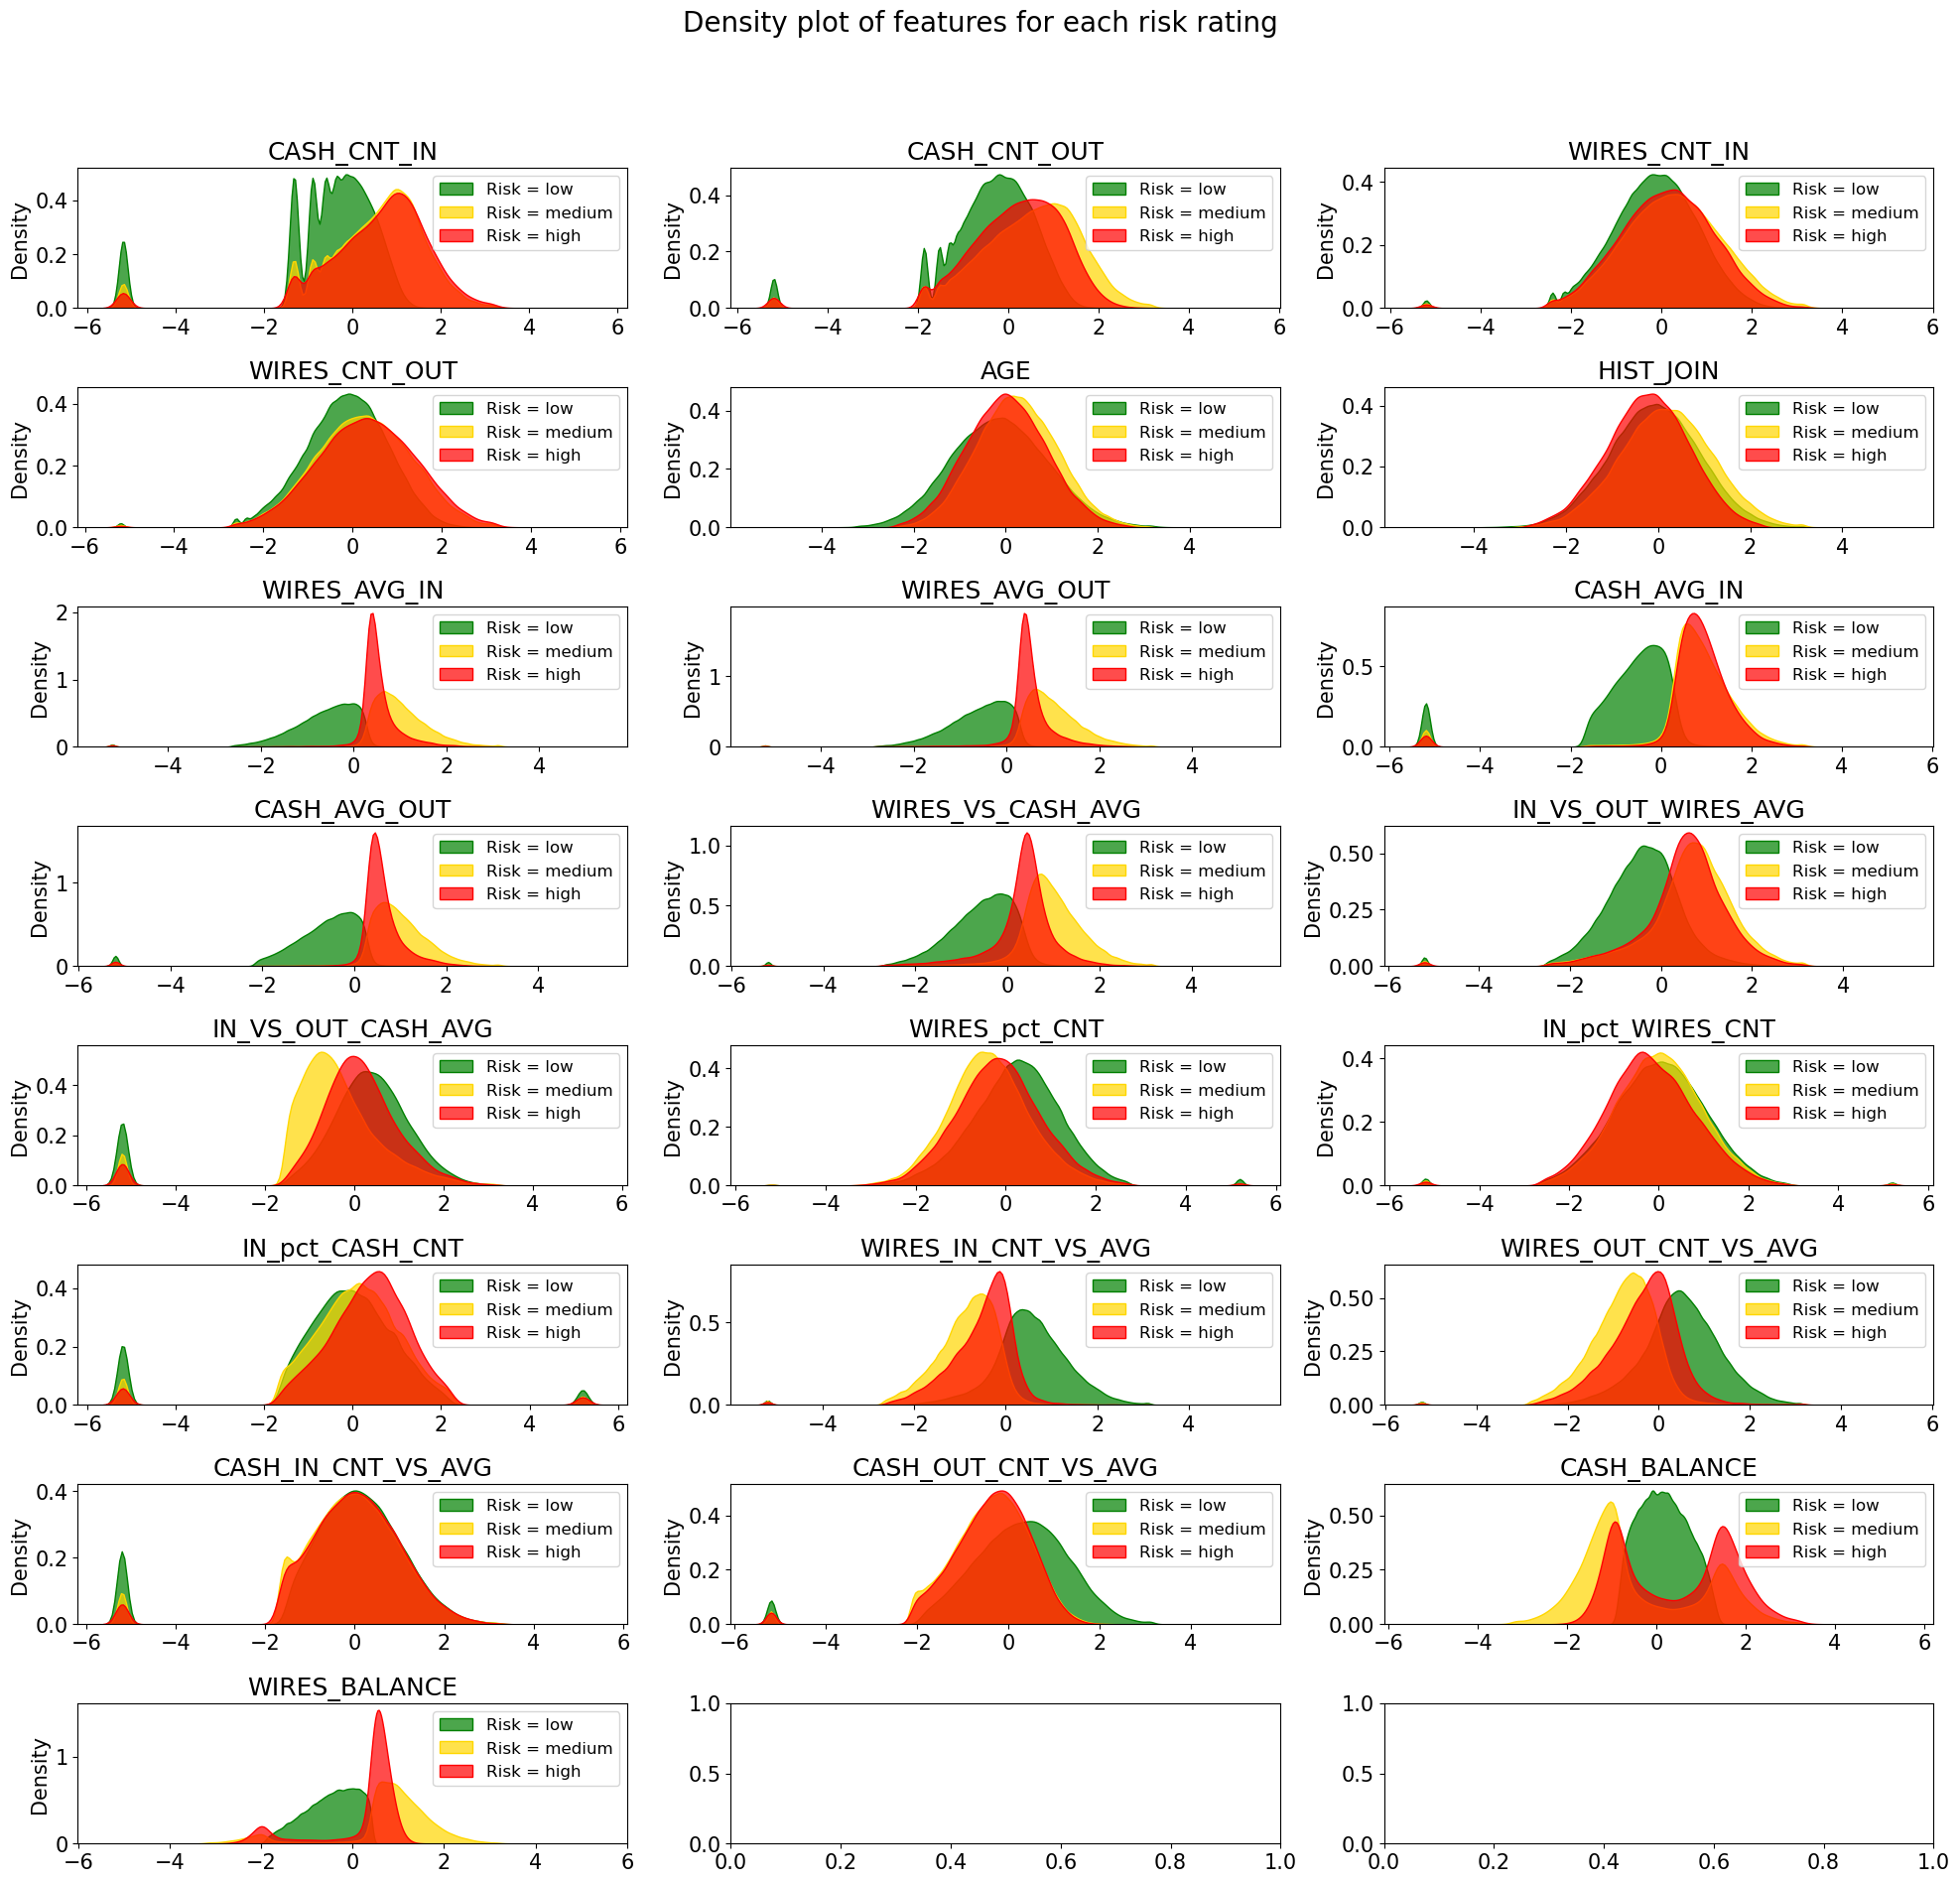

In [ ]:
# Univariate density plot by RISK rating
fig, axes = plt.subplots(8,int((X_train.select_dtypes(np.number).shape[1] - 2) // 8) + 1,figsize=(20,20))

abcd = MyQuantileTransformer(output_distribution='normal', random_state=42).fit(X_train.select_dtypes(np.number))

norm_clean = pd.concat([
    pd.DataFrame(abcd.transform(X_train.select_dtypes(np.number)),
                 columns = abcd.get_feature_names_out()),
    y_train], axis = 1)

for ax, col in zip(axes.flatten(), X_train.select_dtypes(np.number).columns):
  for risk, color in zip(y_train.cat.categories, ['green', 'gold', 'red']):
    try:
      sns.kdeplot(norm_clean.loc[norm_clean['RISK'] == risk, col], fill=True, label=f"Risk = {risk}", alpha=.7, ax=ax, warn_singular=False, 
                  gridsize=200, legend = True, color = color)
    except LinAlgError:
      print(f"only 1 unique value of {norm_clean.loc[norm_clean['cluster'] == risk, col].unique()[0]:0.3f} for {col} in risk {risk}")
  ax.set_title(col)
  ax.legend(loc = 'upper right', prop={'size': 12})
  ax.set_xlabel('')

fig.suptitle('Density plot of features for each risk rating', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Uniform distribution

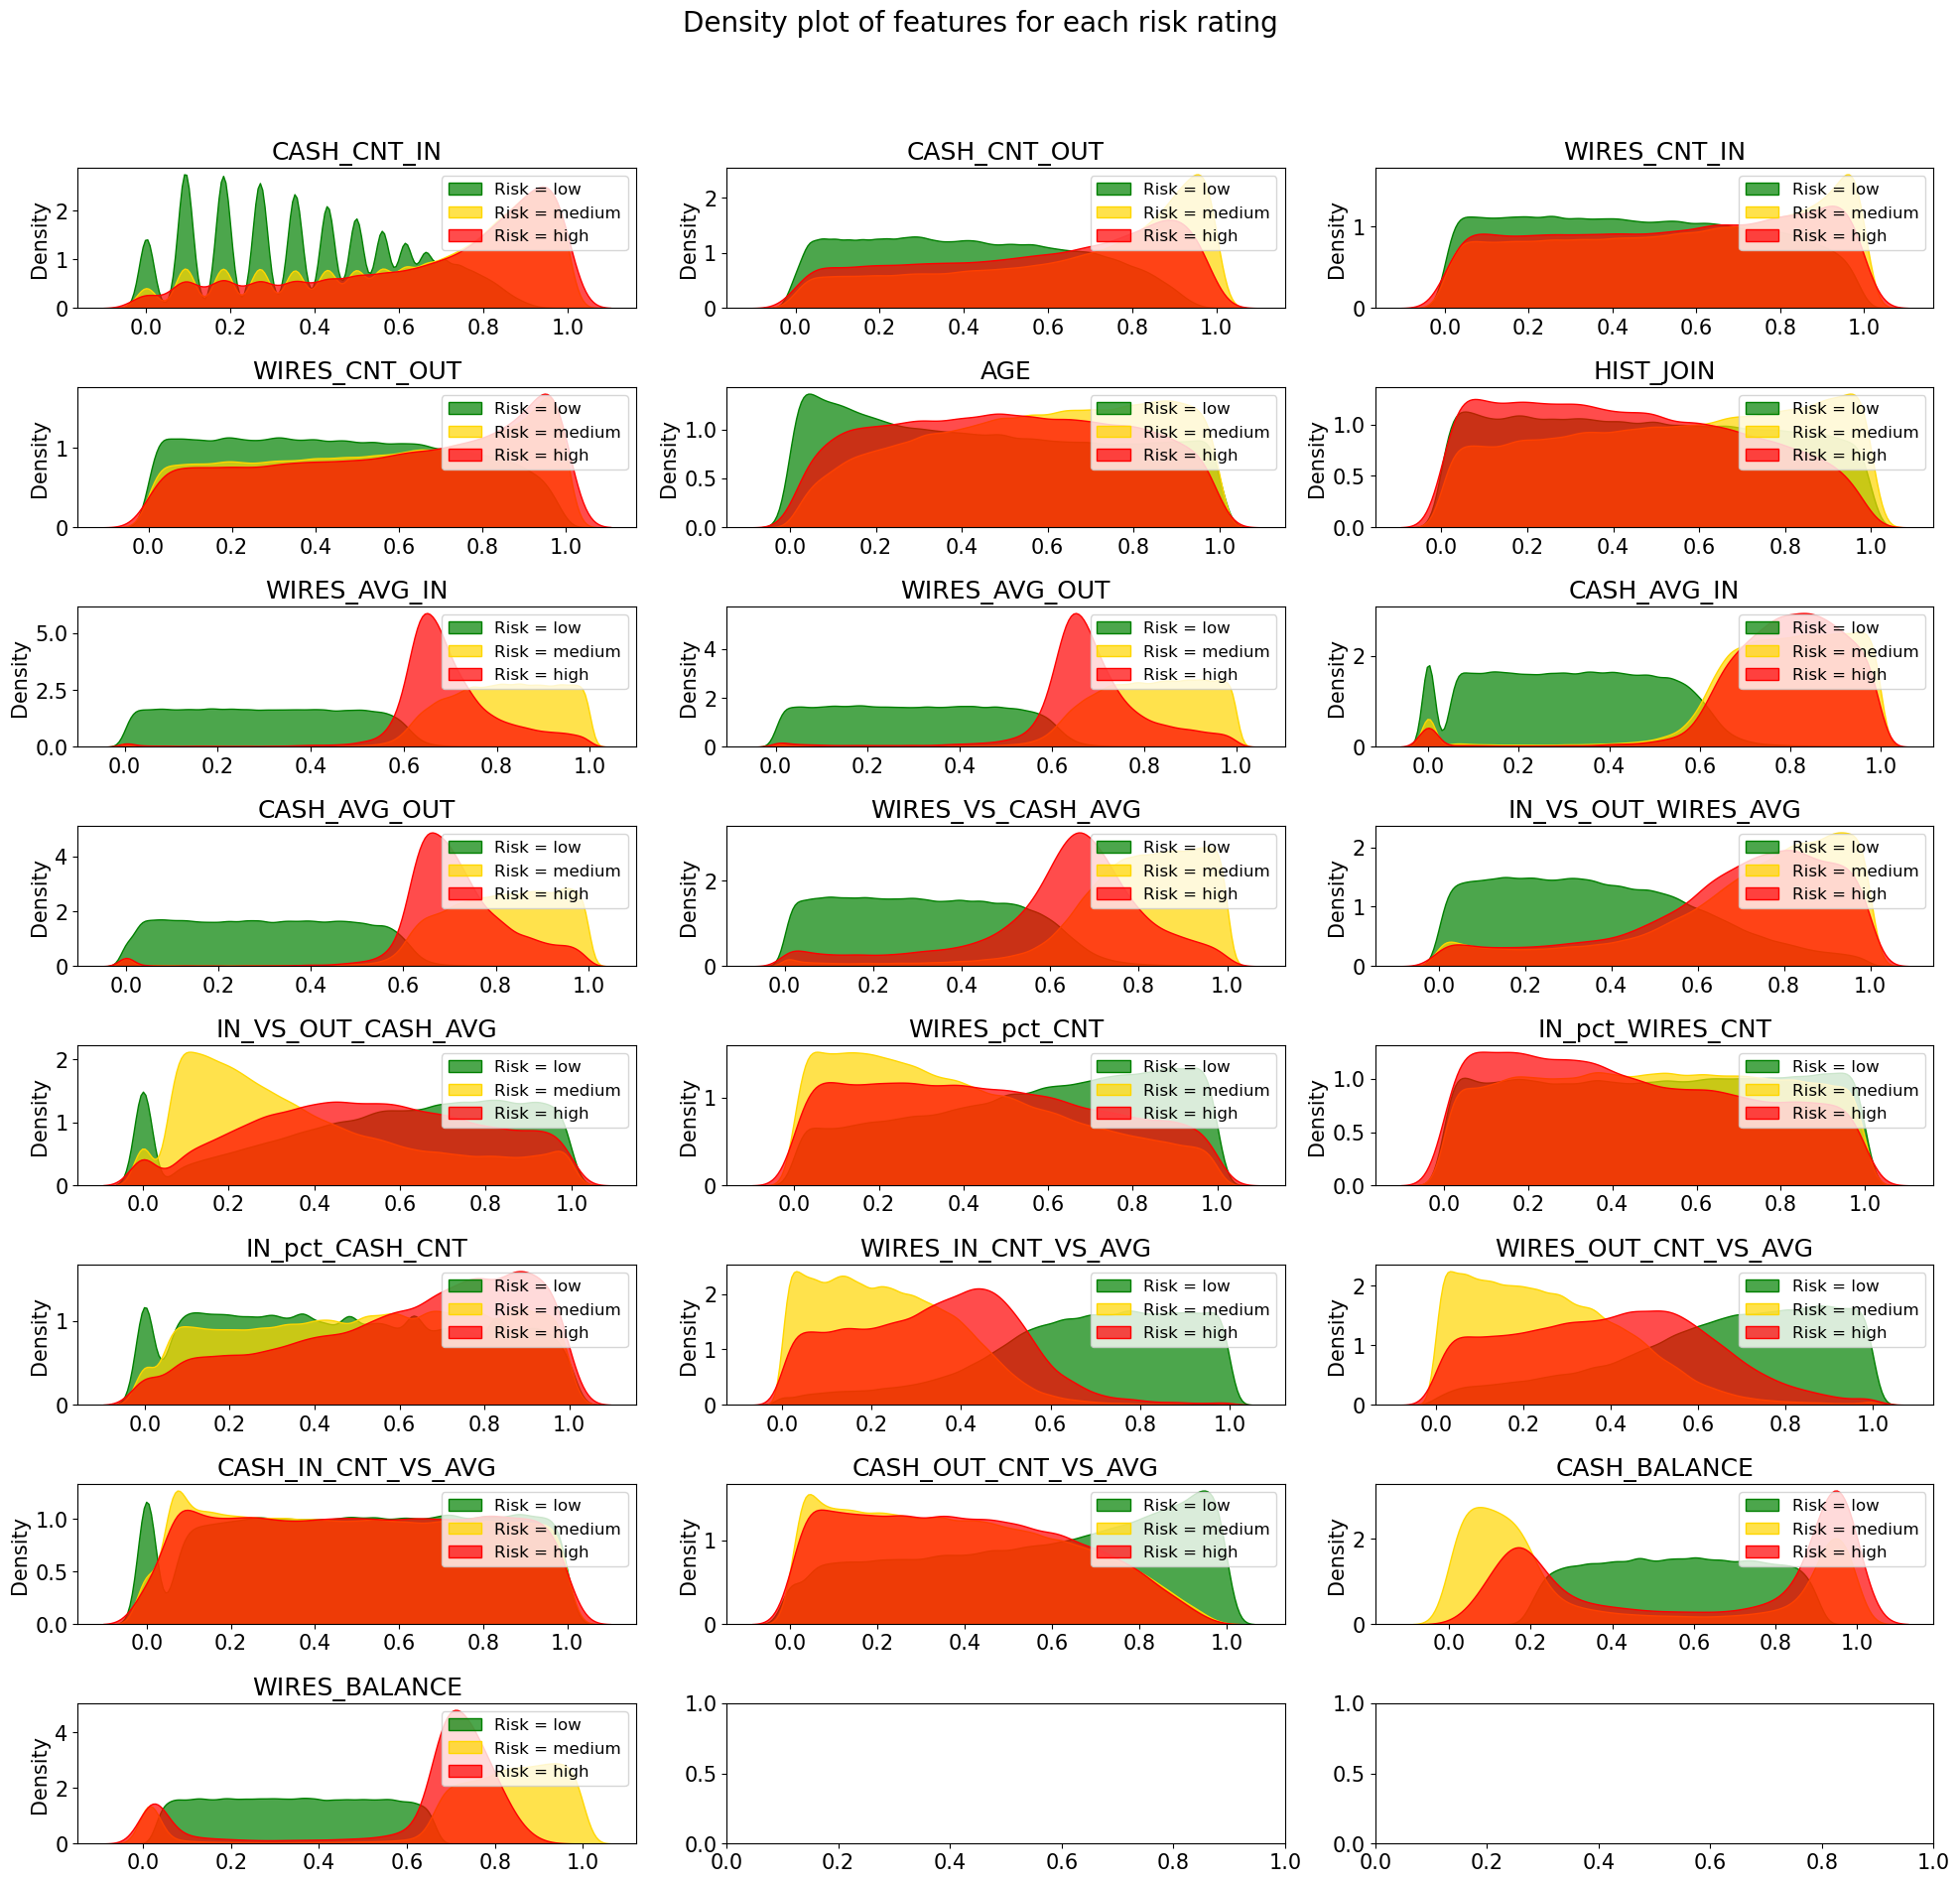

In [ ]:
# Univariate density plot by RISK rating
fig, axes = plt.subplots(8,int((X_train.select_dtypes(np.number).shape[1] - 2) // 8) + 1,figsize=(20,20))

abcd = MyQuantileTransformer(output_distribution='uniform', random_state=42).fit(X_train.select_dtypes(np.number))

norm_clean = pd.concat([
    pd.DataFrame(abcd.transform(X_train.select_dtypes(np.number)),
                 columns = abcd.get_feature_names_out()),
    y_train], axis = 1)

for ax, col in zip(axes.flatten(), X_train.select_dtypes(np.number).columns):
  for risk, color in zip(y_train.cat.categories, ['green', 'gold', 'red']):
    try:
      sns.kdeplot(norm_clean.loc[norm_clean['RISK'] == risk, col], fill=True, label=f"Risk = {risk}", alpha=.7, ax=ax, warn_singular=False, 
                  gridsize=200, legend = True, color = color)
    except LinAlgError:
      print(f"only 1 unique value of {norm_clean.loc[norm_clean['cluster'] == risk, col].unique()[0]:0.3f} for {col} in risk {risk}")
  ax.set_title(col)
  ax.legend(loc = 'upper right', prop={'size': 12})
  ax.set_xlabel('')

fig.suptitle('Density plot of features for each risk rating', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### pairplot

In [ ]:
# randomly select 10**4 samples for faster plotting with probability of being chosen based on 1 / class % split
class_weighted_sample = pd.concat([
    X_train.select_dtypes(np.number),
    y_train], 
    axis = 1).sample(10**2, weights = 1/(y_train.to_frame().groupby('RISK').RISK.transform('size') / y_train.shape[0]))

sns.pairplot(class_weighted_sample,
             # specify off-diagonal cells to be scatter
             kind='scatter',
             hue = 'RISK',
             # specify diagonal to be histogram, or "kde"
             diag_kind='kde',
             plot_kws={'alpha': 0.2},
             corner=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# randomly select samples for faster plotting with probability based on class % split
class_weighted_sample_Q = pd.concat([
  pd.DataFrame(
    QuantileTransformer(output_distribution='normal').fit_transform(class_weighted_sample.drop(columns=['RISK'])),
    columns = class_weighted_sample.drop(columns=['RISK']).columns),
  class_weighted_sample.RISK.reset_index(drop=True)
], axis = 1)

sns.pairplot(class_weighted_sample_Q,
             # specify off-diagonal cells to be scatter
             kind='scatter',
             hue = 'RISK',
             # specify diagonal to be histogram, or "kde"
             diag_kind='kde',
             plot_kws={'alpha': 0.2},
             corner=True)

Output hidden; open in https://colab.research.google.com to view.

#### categorical

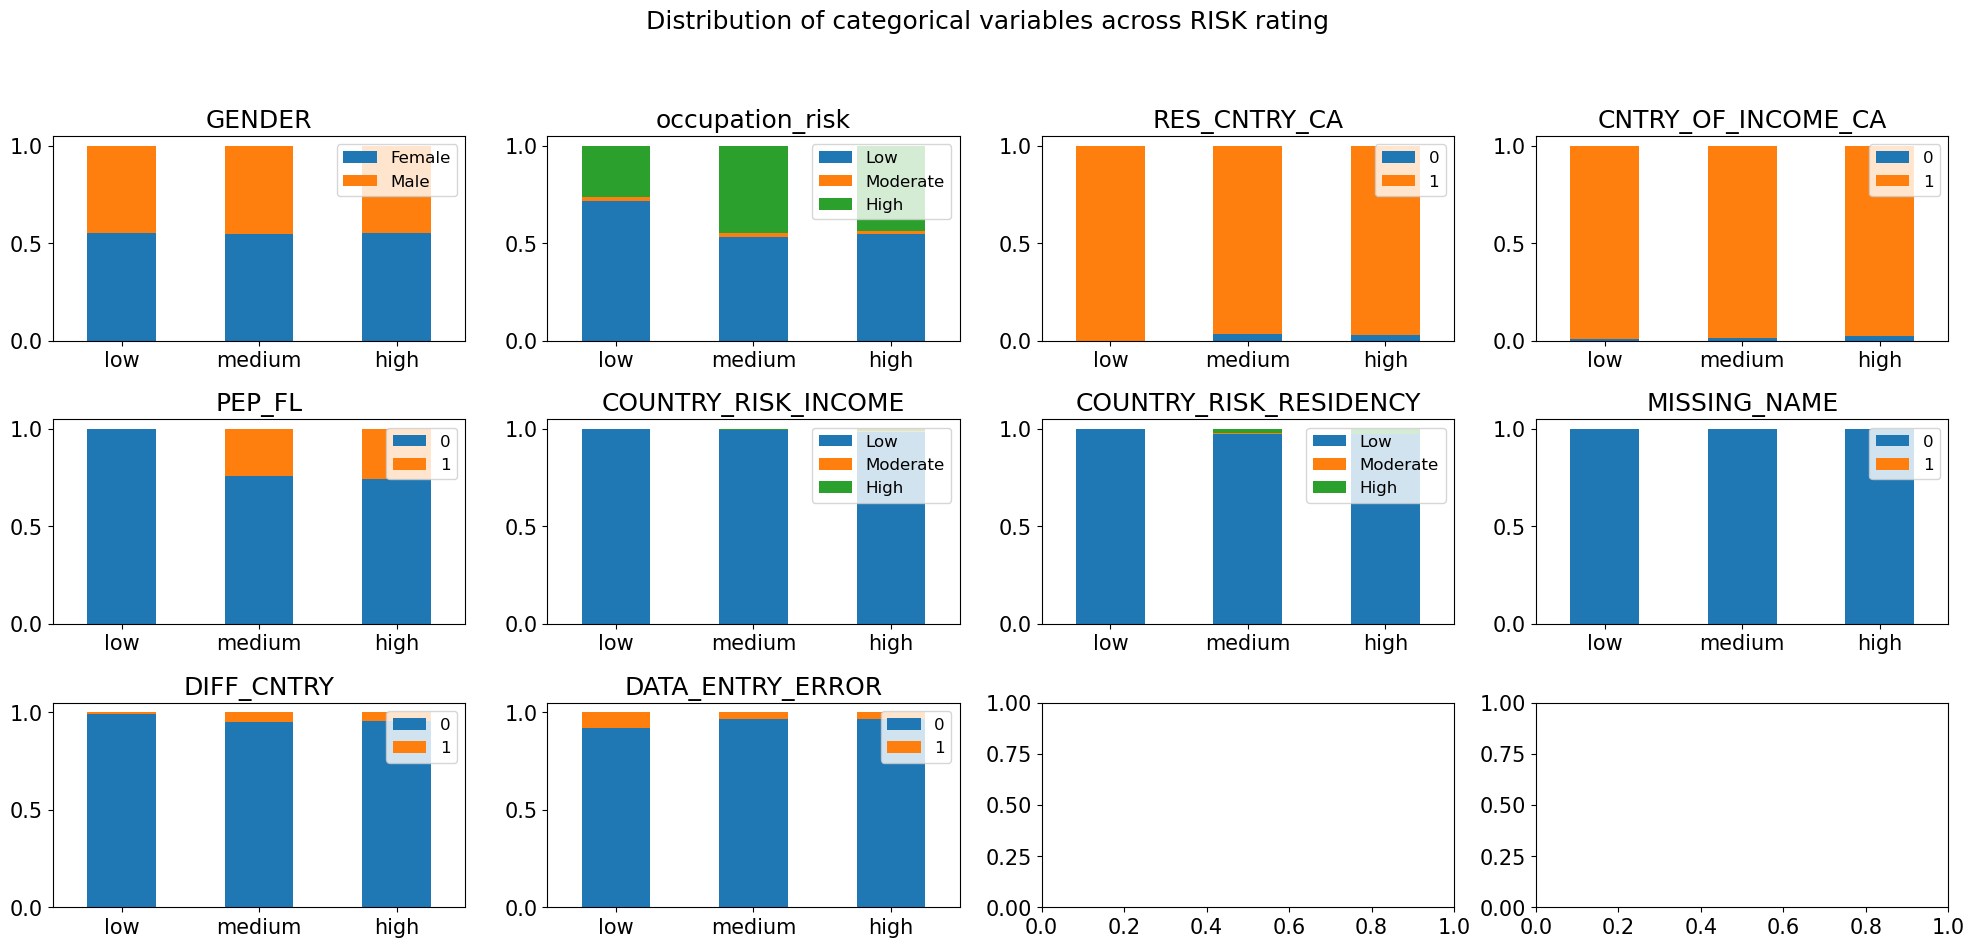

In [ ]:
# plot categorical variables
fig, axes = plt.subplots(3,4, figsize = (20,10))
for col, ax in zip(X_train.select_dtypes(include = ['category']), axes.flatten()):
  pd.crosstab(y_train, X_train[col], normalize = 'index').plot(kind = 'bar', stacked = True, title = col, legend=False, ax = ax)
  ax.set_xlabel('')
  ax.set_xticklabels(['low', 'medium', 'high'], rotation = 0)
  ax.legend(loc = 'upper right', prop={'size': 12})
plt.subplots_adjust(hspace=1, wspace=0.3)
plt.suptitle(f'Distribution of categorical variables across RISK rating')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Data preparation

## Missing values
- how are they represented, where do they occur, and 
  - occupation_riks and HIST_JOIN seems to appear at random
  - GENDER is missing when NAME is missing too
- how common are they?
  - not very common c.1%
- msno matrix
  - minimum complete columns = 35 columns
  - maximum = 37 columns
- missingness vs observed values
- missingness in GENDER, occupation risk
  - When opening an account, the client refuses or tries to avoid providing information required by the financial institution

In [ ]:
# count of missingness
X_train.isna().sum().sort_values(ascending=False).to_frame().T

occupation_risk  HIST_JOIN  GENDER  CASH_OUT_CNT_VS_AVG  \
0             5112       3274     526                    0   

   CASH_IN_CNT_VS_AVG  WIRES_OUT_CNT_VS_AVG  WIRES_IN_CNT_VS_AVG  \
0                   0                     0                    0   

   IN_pct_CASH_CNT  CASH_AVG_IN  WIRES_pct_CNT  IN_VS_OUT_CASH_AVG  \
0                0            0              0                   0   

   IN_VS_OUT_WIRES_AVG  WIRES_VS_CASH_AVG  DATA_ENTRY_ERROR  CASH_BALANCE  \
0                    0                  0                 0             0   

   CASH_AVG_OUT  IN_pct_WIRES_CNT  WIRES_AVG_OUT  WIRES_AVG_IN  AGE  \
0             0                 0              0             0    0   

   DIFF_CNTRY  MISSING_NAME  WIRES_CNT_OUT  WIRES_CNT_IN  CASH_CNT_OUT  \
0           0             0              0             0             0   

   CASH_CNT_IN  COUNTRY_RISK_RESIDENCY  COUNTRY_RISK_INCOME  PEP_FL  \
0            0                       0                    0       0   

   CNTRY_OF_INCOME_CA  RES_CNTRY_CA  WIRES_BALANCE  
0                   0             0              0

### missingness vs RISK

<AxesSubplot:ylabel='RISK'>

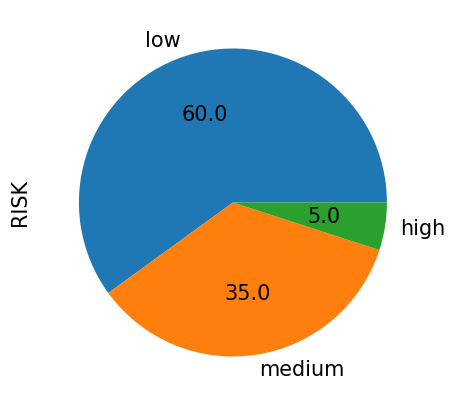

In [ ]:
# normal class %
y_train.value_counts(normalize=True).sort_index().plot(kind = 'pie', autopct='%.1f')

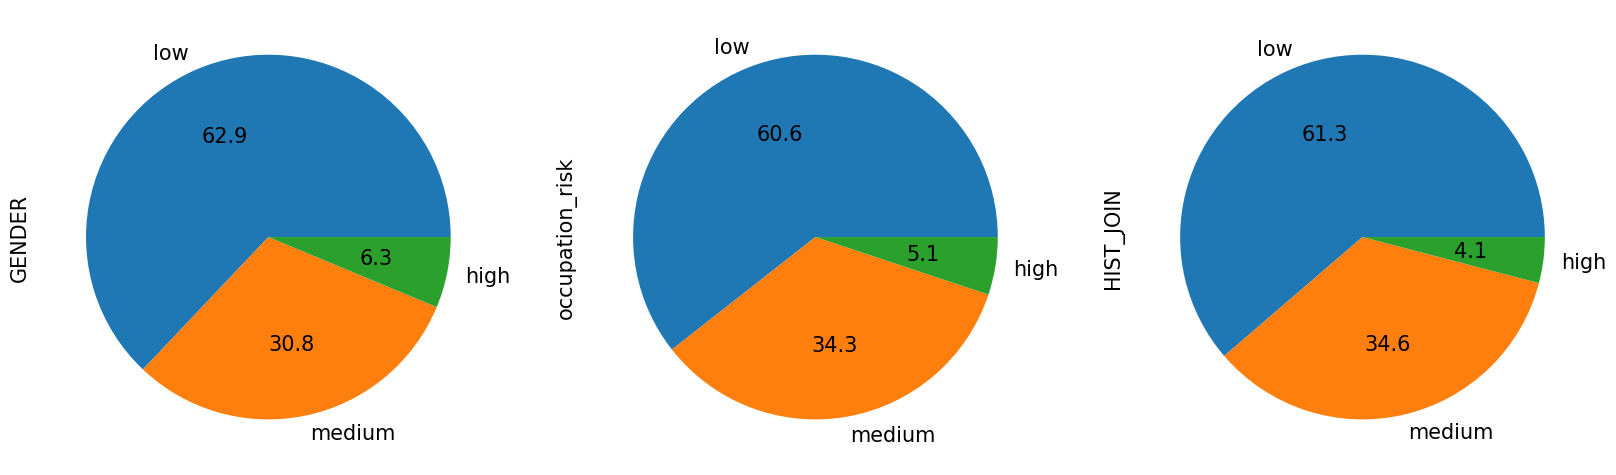

In [ ]:
# similar class % for rows with missing records
fig, axes = plt.subplots(1,sum(X_train.isna().sum() != 0), figsize = (20,10))
for i, na_col in enumerate(X_train.columns[X_train.isna().sum() != 0]):
  y_train[X_train[na_col].isna()].value_counts(normalize=True).sort_index().plot(kind = 'pie', autopct='%.1f', ylabel = na_col, ax = axes.flatten()[i])

plt.show()

### missingness vs Numerical

In [ ]:
# check the boxplots of those rows with NA and without NA in na_col to see if any pattern in X
def na_check(df, na_col):
  fig, axes = plt.subplots(1,2, sharex = True, sharey = False, figsize = (20,10))

  output = df.select_dtypes(np.number).apply(lambda x: (x - x.mean()) / x.std())
  
  output[df[na_col].isna()].plot(kind='box', vert=False, showfliers=False, ax = axes[0])
  output[~df[na_col].isna()].plot(kind='box', vert=False, showfliers=False, ax = axes[1])
  
  plt.suptitle(f'Distribution of records with')
  axes[0].set_title(f'NA in {na_col}')
  axes[0].axvline(2, ls = '--')
  axes[0].axvline(-2, ls = '--')
  axes[0].set_xlim(-2.5, 2.5)
  axes[1].set_title(f'non-NA in {na_col}')
  axes[1].axvline(2, ls = '--')
  axes[1].axvline(-2, ls = '--')
  axes[1].set_xlim(-2.5, 2.5)
  plt.subplots_adjust(hspace = 0.4, wspace=0.6)
  plt.show()

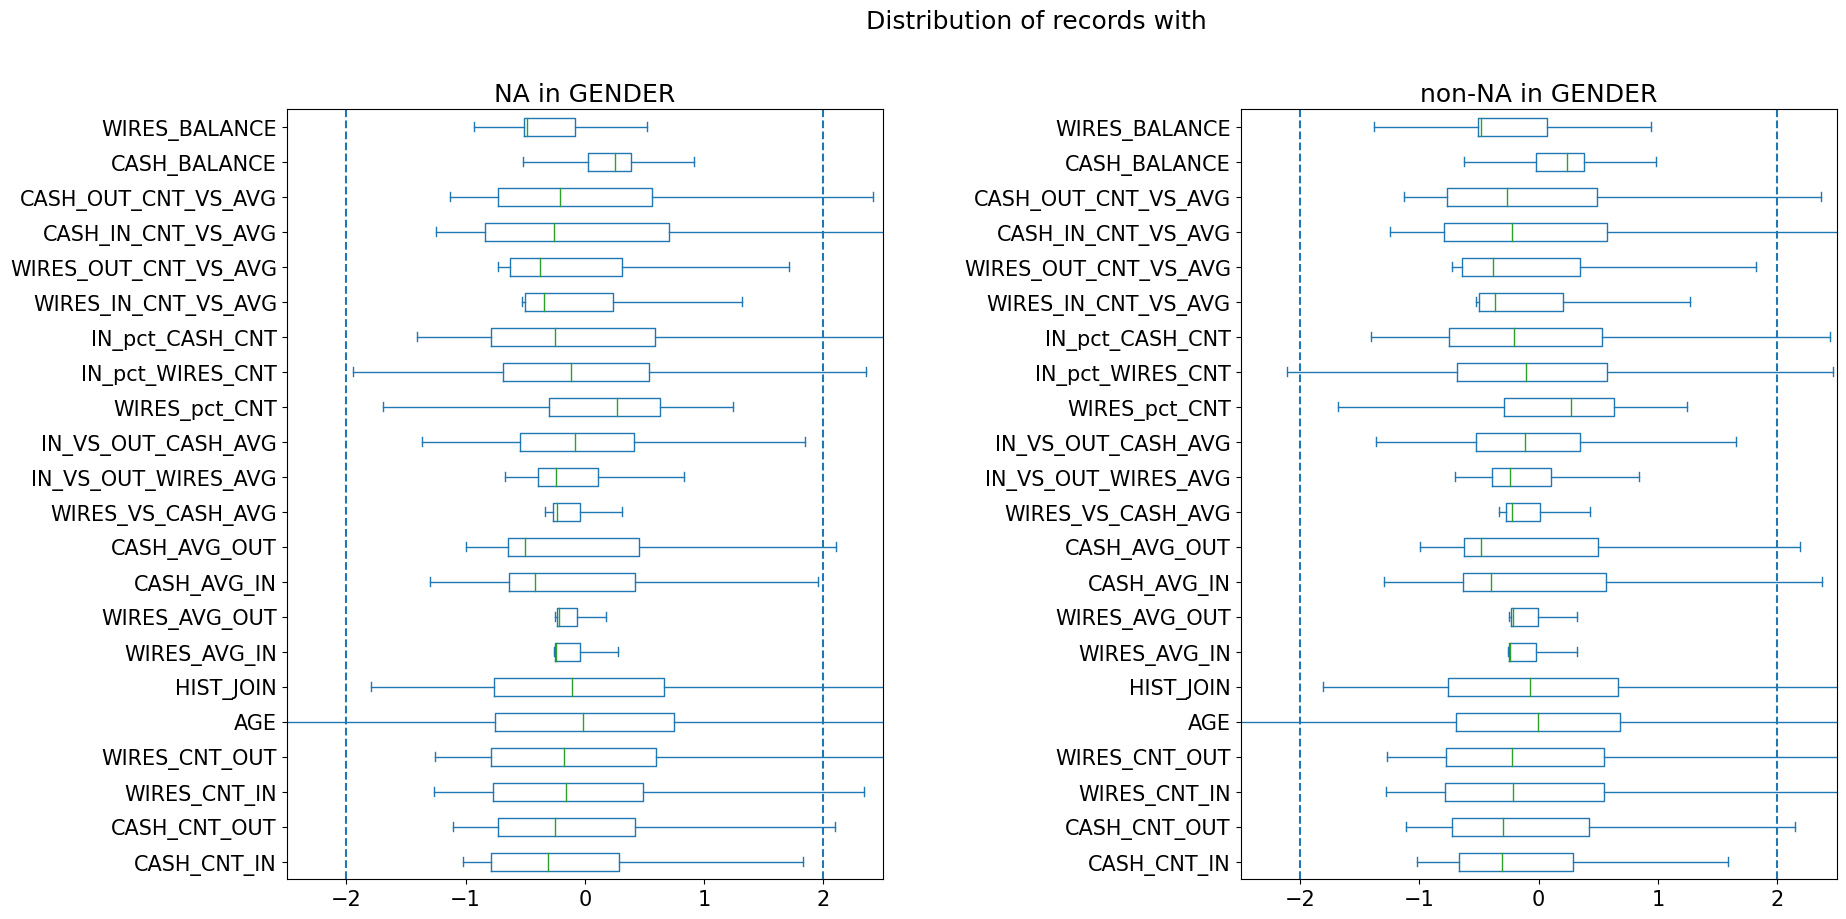

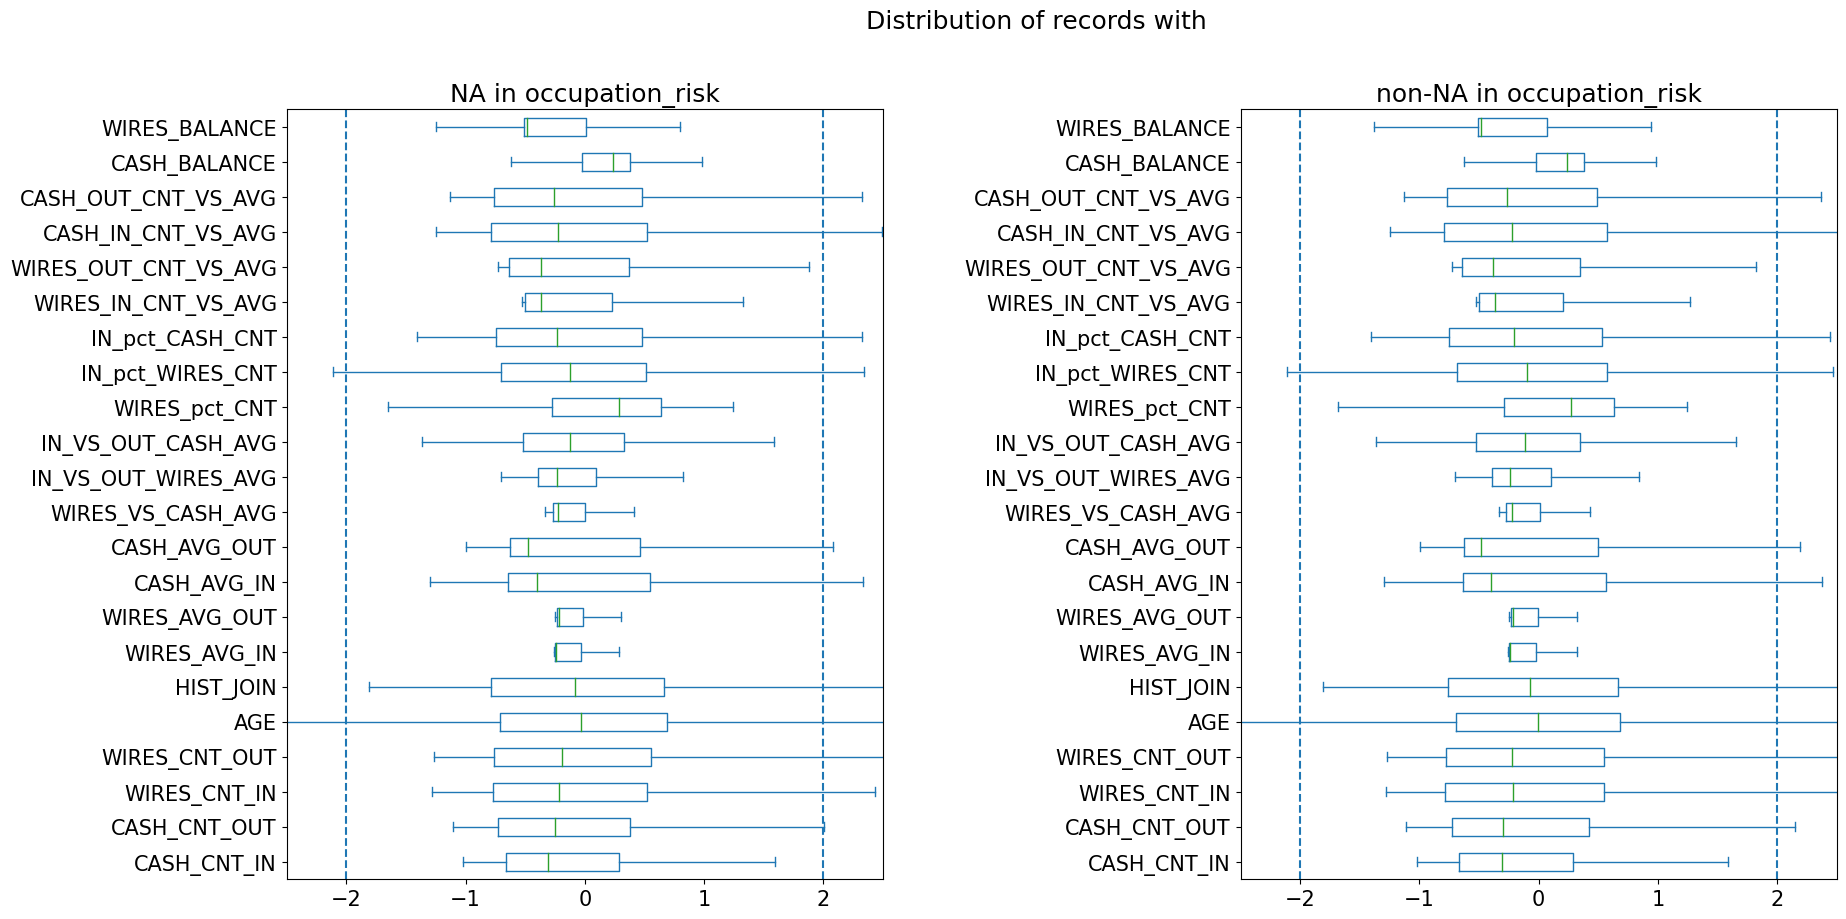

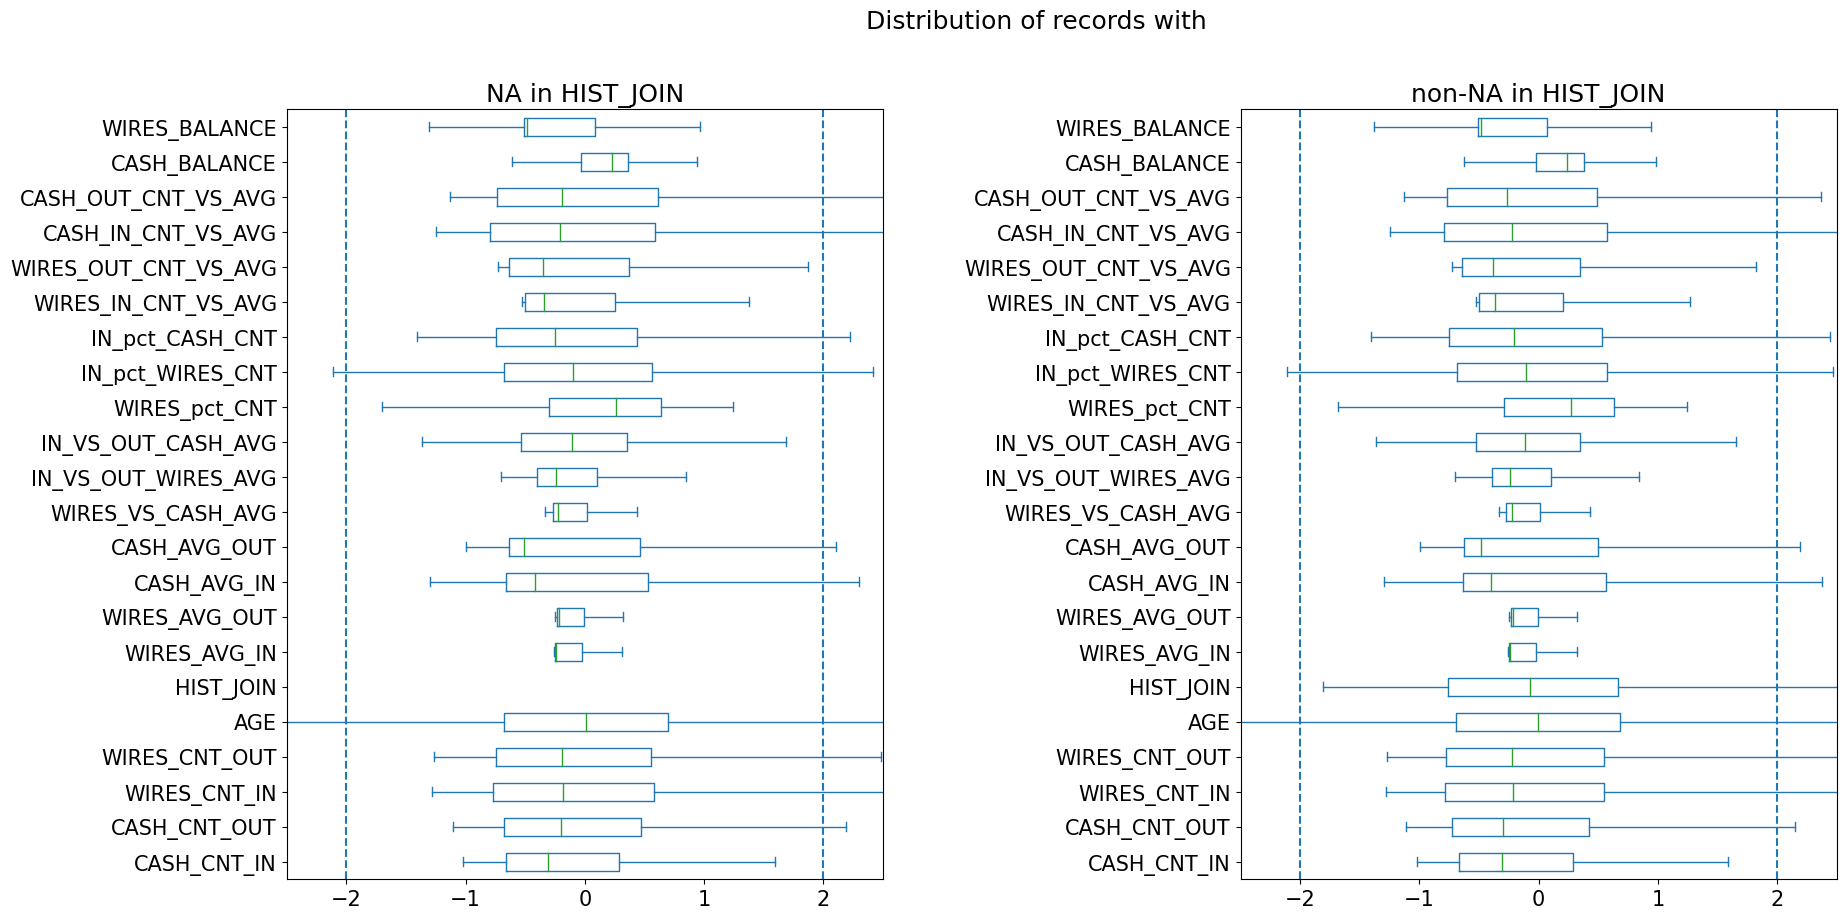

In [ ]:
for na_col in X_train.columns[X_train.isna().sum() != 0]:
  na_check(X_train, na_col)

### missingness vs Categorical

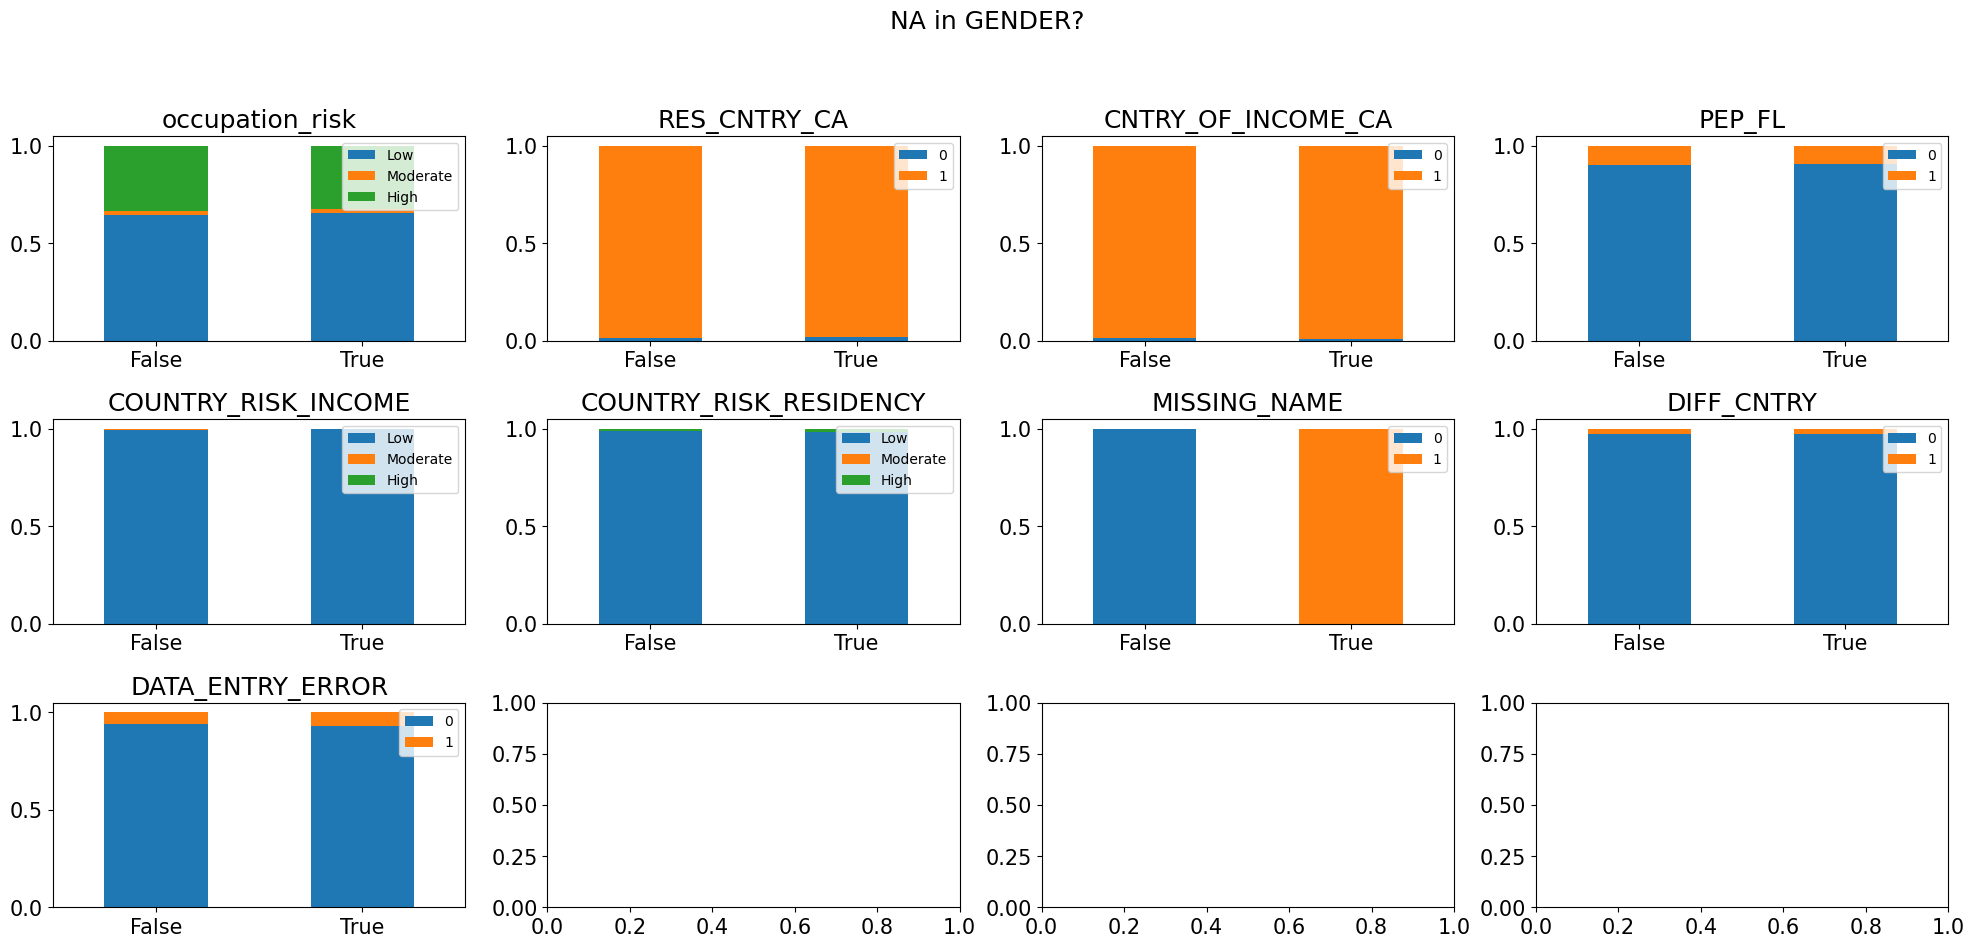

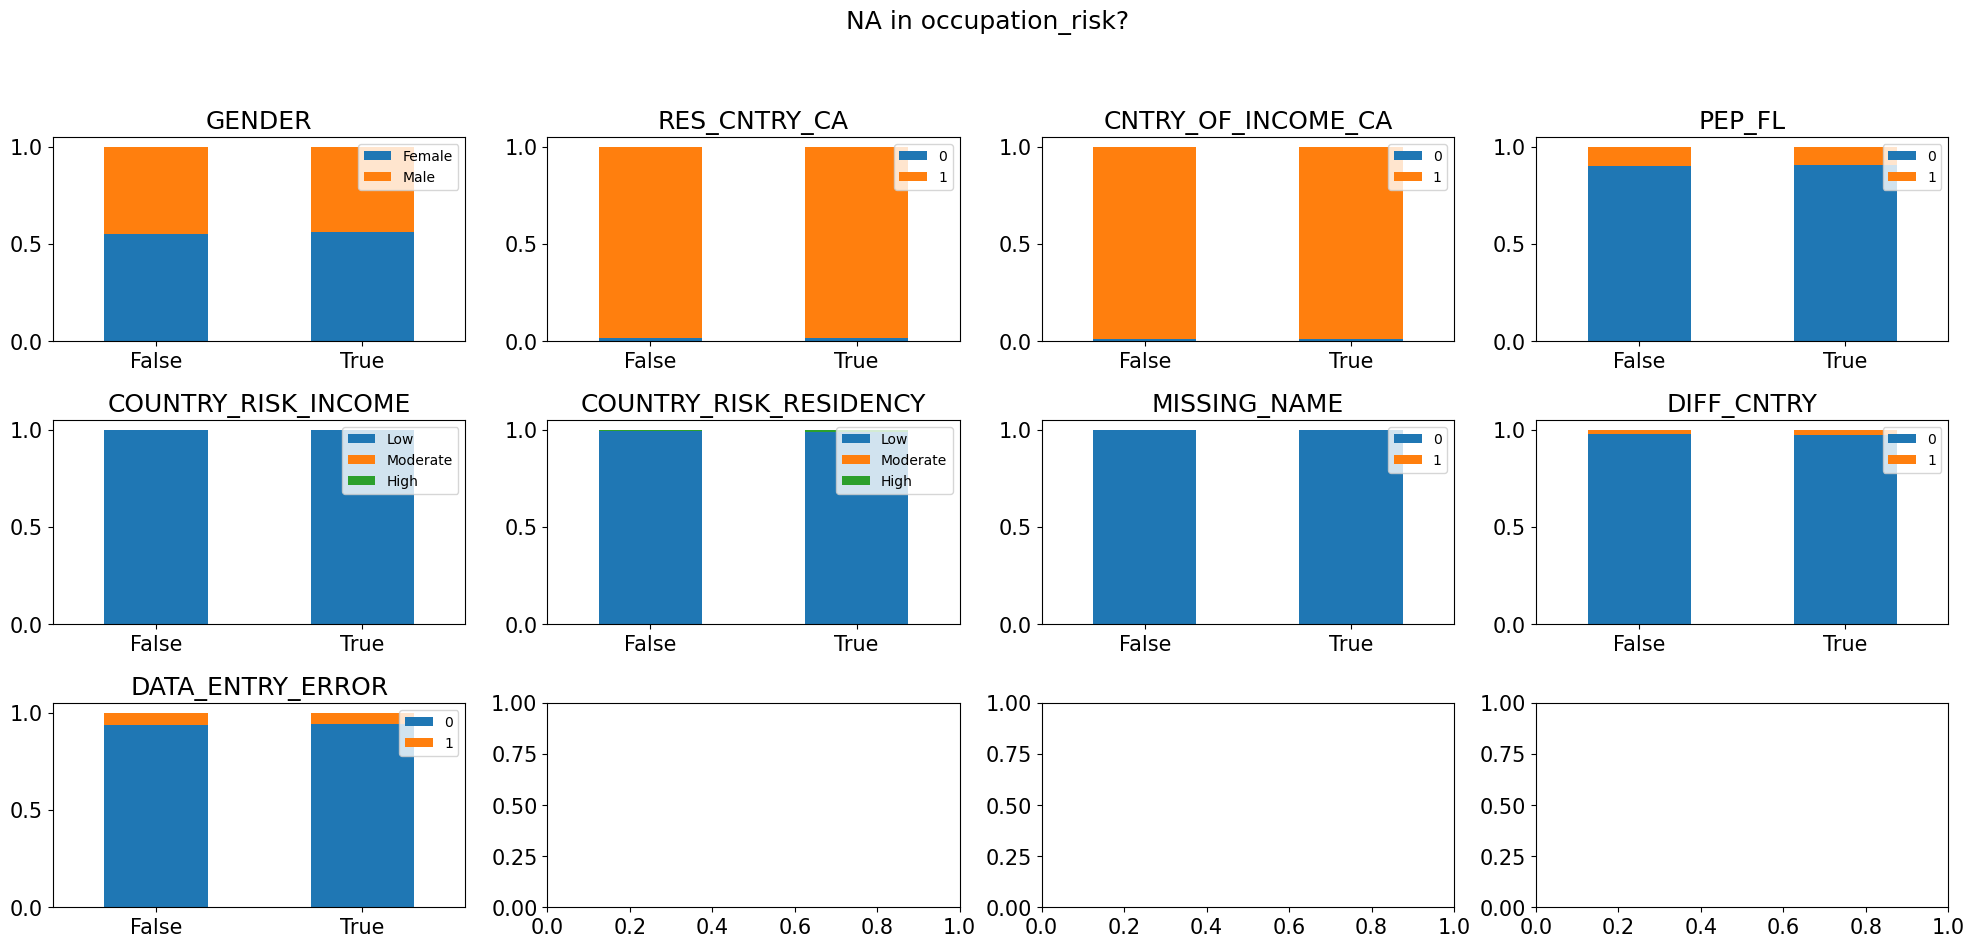

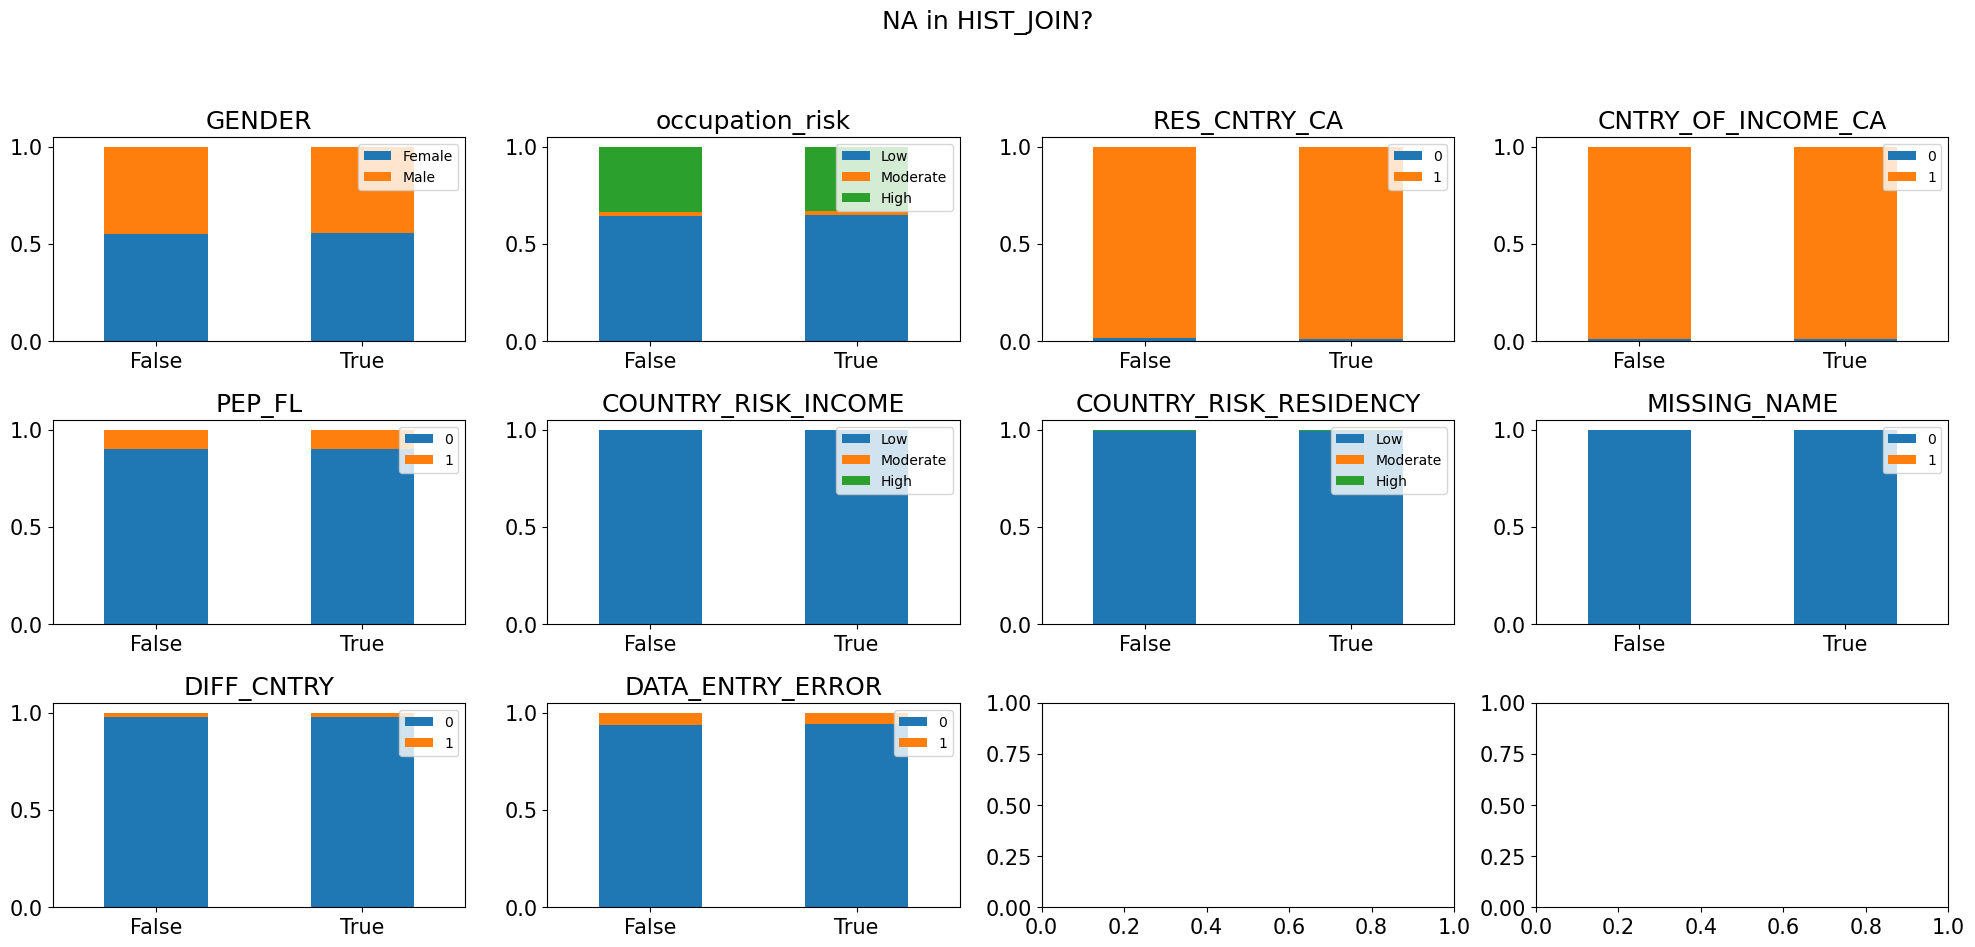

In [ ]:
# relationship in missing GENDER and missing name
for na_col in X_train.columns[X_train.isna().sum() != 0]:
  fig, axes = plt.subplots(3,4, figsize = (20,10))
  for col, ax in zip(X_train.drop(columns=[na_col]).select_dtypes(include = ['category']), axes.flatten()):
    pd.crosstab(X_train[na_col].isna(), X_train[col], normalize = 'index').plot(kind = 'bar', stacked = True, title = col, legend=True, ax = ax)
    ax.set_xlabel('')
    ax.set_xticklabels(['False', 'True'], rotation = 0)
    ax.legend(loc = 'upper right', prop={'size': 10})
  plt.subplots_adjust(hspace=1, wspace=0.3)
  plt.suptitle(f'NA in {na_col}?')
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [ ]:
# if GENDER is missing, then MISSING_NAME must be 1
X_train[X_train.GENDER.isna()].MISSING_NAME.value_counts()

1    526
0      0
Name: MISSING_NAME, dtype: int64

### correlation among missingness

<AxesSubplot:>

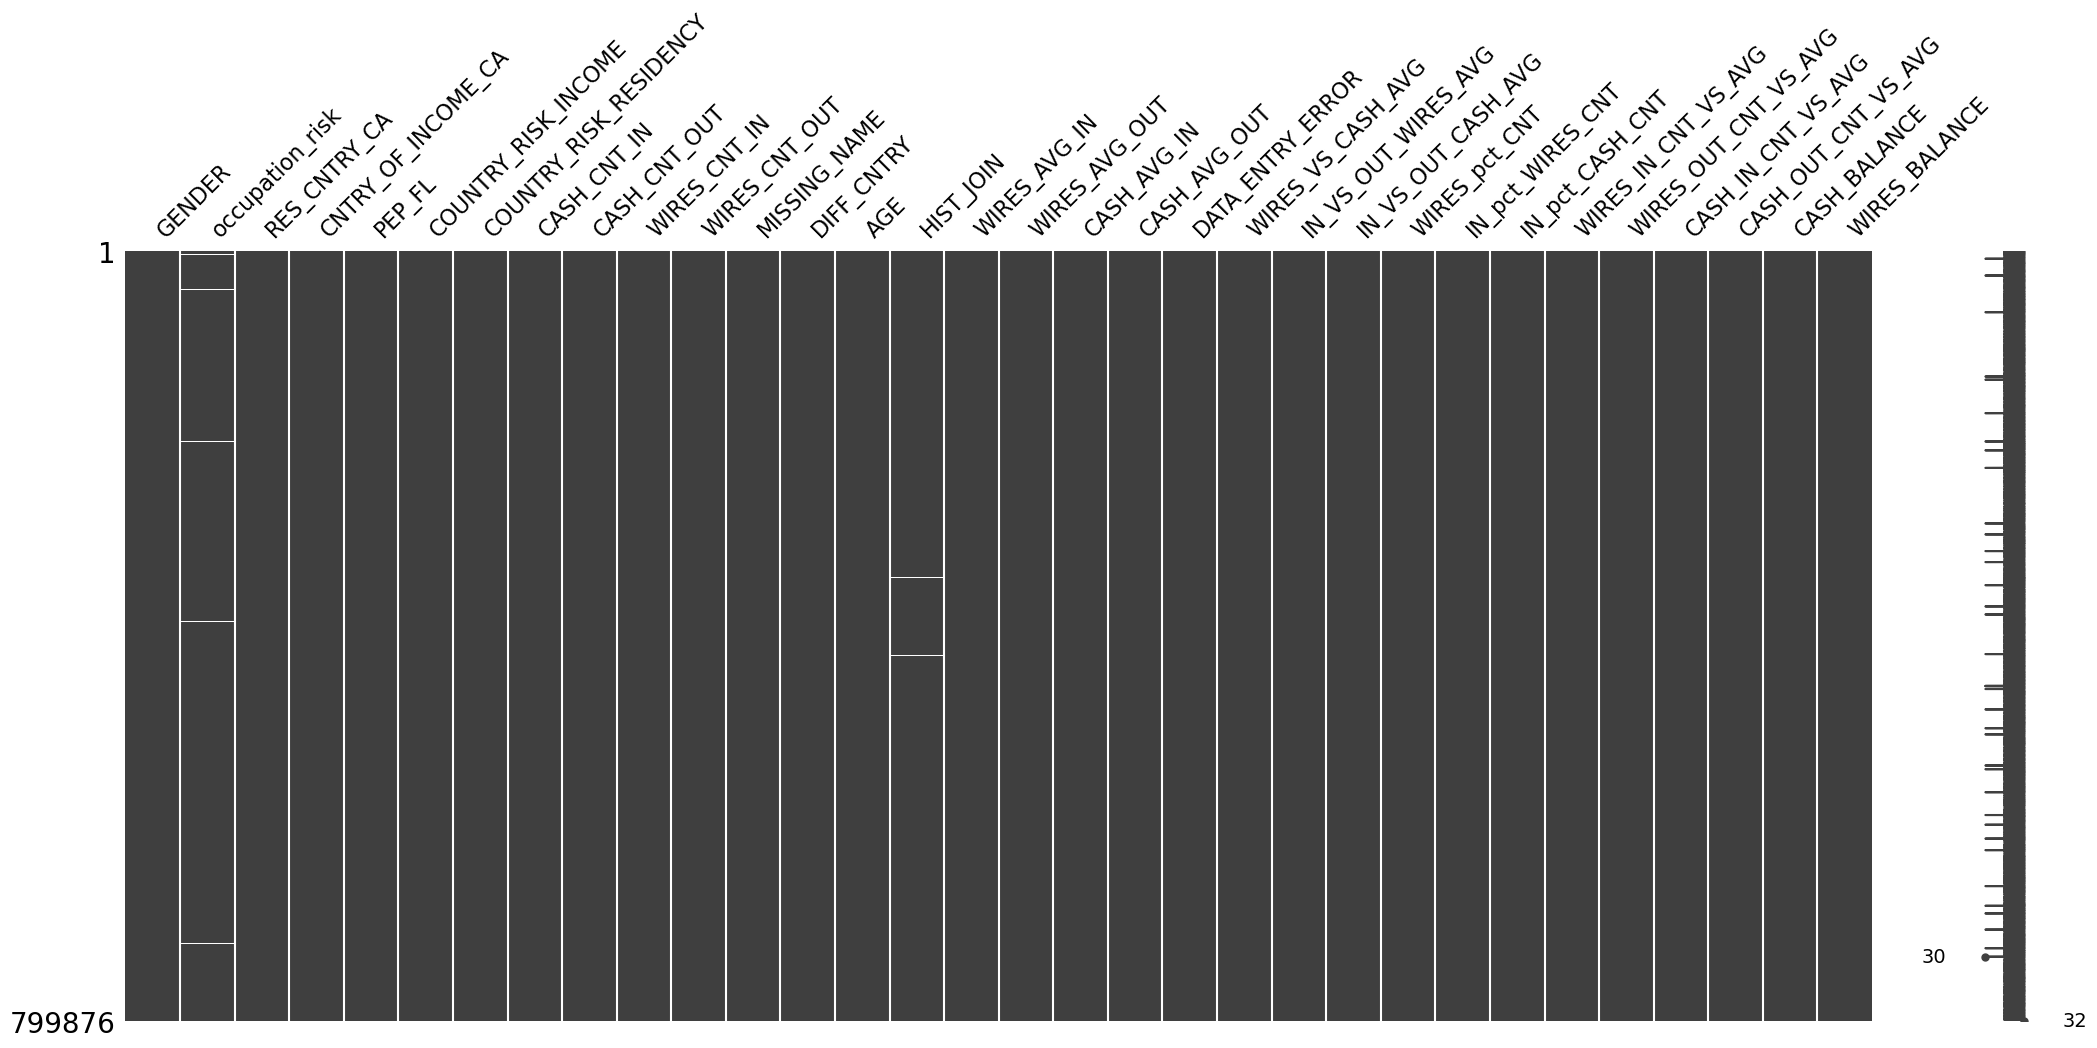

In [ ]:
msno.matrix(X_train)

<AxesSubplot:>

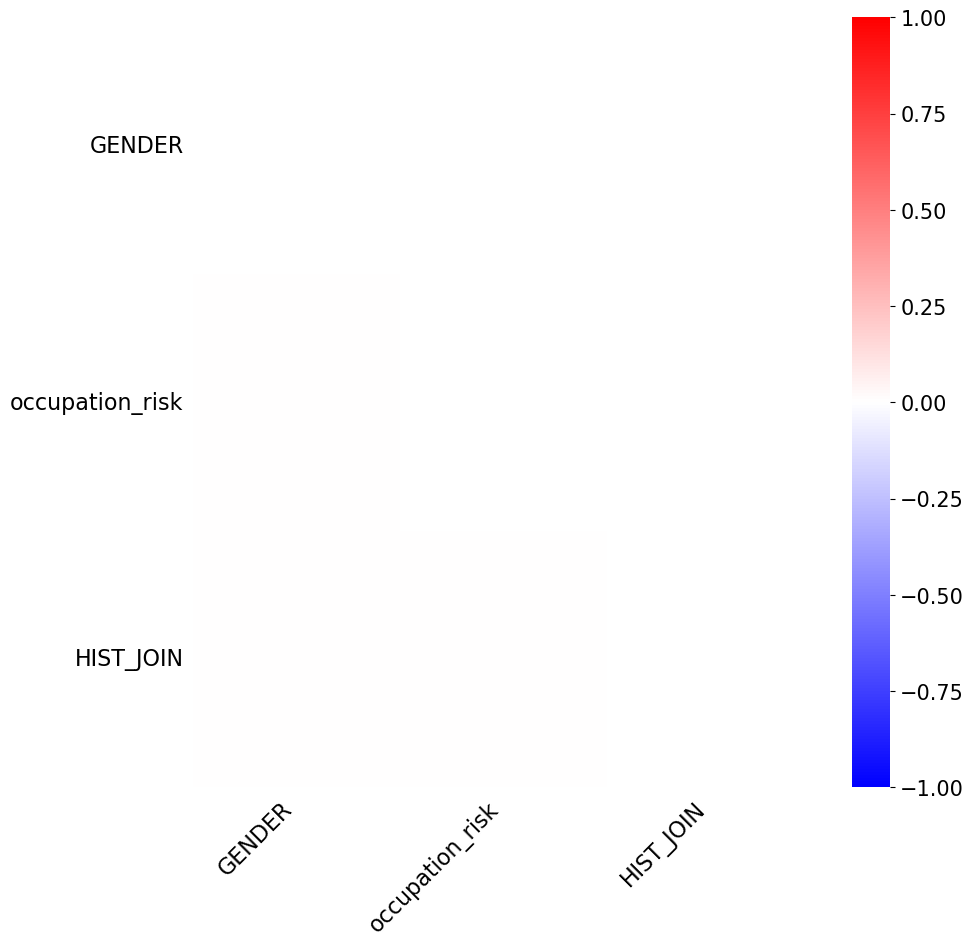

In [ ]:
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 
# 0 (variables appearing or not appearing have no effect on one another) to 
# 1 (if one variable appears the other definitely also does).
msno.heatmap(X_train, figsize = (10,10), cmap='bwr')

### RandomImputer or MySimpleImputer
- impute occupation_risk and HIST_JOIN at random to maintain the spread of distribution
- impute GENDER with random values when MISSING_NAME == 1

In [ ]:
X_train.isna().sum().sum()

8912

In [ ]:
X_clean = RandomImputer().fit_transform(X_train)

In [ ]:
X_clean.isna().sum().sum()

0

## data_preparation pipeline for X
- numerical
  - Non-linear transformation to normal distribution
- categorical
  - unordered
    - OneHotEncoder:
      - no need to collapse infrequent categories -> infrequent class could represent minority class in target variable
  - ordered
    - ThermometerEncoder
    - [(2012) Evaluating the Impact of Categorical Data Encoding and Scaling on Neural Network Classification Performance: The Case of Repeat Consumption of Identical Cultural Goods (Elena Fitkov-Norris, Samireh Vahid, and Chris Hand from Kingston University London)](https://www.researchgate.net/publication/262173733_Evaluating_the_Impact_of_Categorical_Data_Encoding_and_Scaling_on_Neural_Network_Classification_Performance_The_Case_of_Repeat_Consumption_of_Identical_Cultural_Goods)
  - MinMaxScaler to rescale to -2 to +2 (95% confidence interval of normal distribution)
  - alternative: bin counting (prone to data leakage)

### !Increase n_quantiles in QuantileTransformer

In [ ]:
num_pipeline = make_pipeline(
    # Impute missing values
    RandomImputer(),
    # MySimpleImputer(strategy='mean'),
    # transformation
    MyQuantileTransformer(output_distribution = 'normal', random_state=42)
)

cat_pipeline = make_pipeline(
    # Impute missing values instead of treating as additional category (only a small portion is missing)
    RandomImputer(),
    # MySimpleImputer(strategy='most_frequent'),
    # transform with dummy variables
    MyOneHotEncoder(drop = 'if_binary', sparse = False),
    # scale to -2 and +2 to match 95% CI
    MyMinMaxScaler(feature_range=(-2, 2))
)

ordinal_pipeline = make_pipeline(
    # Impute missing values instead of treating as additional category (only a small portion is missing)
    RandomImputer(),
    # MySimpleImputer(strategy='most_frequent'),
    # transform with thermometer scaling
    ThermometerEncoder(),
    # scale to -2 and +2 to match 95% CI
    MyMinMaxScaler(feature_range=(-2, 2))
)

data_preparation = make_pipeline(
    # data transformation
    ColumnTransformer([
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
        ("cat", cat_pipeline, ['GENDER', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'MISSING_NAME', 'DIFF_CNTRY', 'DATA_ENTRY_ERROR']),
        ("ord", ordinal_pipeline, ['occupation_risk', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY']),
      ], 
      # drop remaining columns if any
      remainder="drop",
      # drop column prefix
      verbose_feature_names_out = False, 
    )
)

### X_train -> X_prep

In [ ]:
X_train.select_dtypes('category').columns

Index(['GENDER', 'occupation_risk', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA',
       'PEP_FL', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY',
       'MISSING_NAME', 'DIFF_CNTRY', 'DATA_ENTRY_ERROR'],
      dtype='object')

In [ ]:
X_prep = pd.DataFrame(data_preparation.fit_transform(X_train), columns = data_preparation.get_feature_names_out())
X_prep

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT     AGE  \
0           -0.0063        0.0289        0.5880         0.6165 -0.7846   
1            1.5713        0.0289       -1.2448        -0.3203  1.1673   
2           -5.1993        0.0289       -0.9979        -1.7219 -1.3347   
3            0.8179       -0.1549       -0.0439        -0.0804  0.3734   
4            0.1486       -1.3130       -1.2049        -1.3621  2.5169   
...             ...           ...           ...            ...     ...   
799871      -0.9071       -0.0301        0.0326        -0.3005 -1.8125   
799872       0.8179        1.2613        1.3160        -0.1321  0.9961   
799873       0.4170       -0.5909       -0.2381        -0.5452  1.1276   
799874      -0.9071       -1.1449        0.0628        -0.0628 -1.5093   
799875      -0.6150        0.0289       -0.7530        -0.4570 -0.6187   

        HIST_JOIN  WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  CASH_AVG_OUT  \
0         -0.5650       -0.3982        -0.4592      -0.9479       -0.2399   
1         -0.2945        2.0193         1.6964       0.9722        1.1116   
2         -1.2479       -0.9716        -1.4480      -5.1993       -0.6068   
3         -0.8377        0.6215         0.9722       0.6561        1.6905   
4          1.7601        0.7153         1.9097       0.8300        0.3375   
...           ...           ...            ...          ...           ...   
799871    -0.2820       -0.5510        -0.2961      -1.5241        0.0544   
799872     1.9962        0.3511         0.3710       0.5290        0.3472   
799873     1.6171       -0.3273        -0.2788       0.1355       -0.2621   
799874    -0.1670       -1.3472        -1.5617      -1.6689       -1.1626   
799875    -1.3532       -0.2108        -0.0786      -0.0834       -0.7856   

        WIRES_VS_CASH_AVG  IN_VS_OUT_WIRES_AVG  IN_VS_OUT_CASH_AVG  \
0                 -0.3398              -0.2850             -0.2696   
1                  1.4983               1.4144             -0.5730   
2                 -0.3015              -0.0214             -5.1993   
3                  0.5767              -0.0331             -1.1804   
4                  1.2651              -1.6199              0.7269   
...                   ...                  ...                 ...   
799871            -0.3221              -0.6899             -1.1573   
799872             0.5536               0.3454              0.2281   
799873            -0.8387              -0.3835              0.8548   
799874            -0.4936              -0.3905             -1.2607   
799875             0.0121              -0.4849              0.9528   

        WIRES_pct_CNT  IN_pct_WIRES_CNT  IN_pct_CASH_CNT  WIRES_IN_CNT_VS_AVG  \
0              0.7120           -0.0274          -0.0489               0.7966   
1             -1.3377           -1.4743           1.1888              -1.9242   
2             -1.6370            1.5086          -5.1993               0.1510   
3             -0.2255            0.0633           0.8232              -0.6941   
4             -0.9674            0.4047           1.5175              -1.3361   
...               ...               ...              ...                  ...   
799871         0.1374            0.4785          -0.9614               0.5795   
799872        -0.6640            1.2938          -0.2875               0.0437   
799873        -0.1549            0.5085           0.9476               0.3391   
799874         1.6782            0.1765           0.3415               1.0889   
799875        -0.5478           -0.5054          -0.6879               0.0522   

        WIRES_OUT_CNT_VS_AVG  CASH_IN_CNT_VS_AVG  CASH_OUT_CNT_VS_AVG  \
0                     0.9240              0.6062               0.4533   
1                    -1.3860              0.7554              -0.8093   
2                    -0.4776             -5.1993               0.6315   
3                    -0.9227              0.1561              -1.1136   
4              

In [ ]:
X_prep.describe(percentiles = [0.025, 0.5, 0.975])

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT          AGE  \
count 799,876.0000  799,876.0000  799,876.0000   799,876.0000 799,876.0000   
mean       -0.1413       -0.0413       -0.0103        -0.0021       0.0022   
std         1.4227        1.1442        1.0319         1.0152       1.0020   
min        -5.1993       -5.1993       -5.1993        -5.1993      -5.1993   
2.5%       -5.1993       -1.8659       -1.9859        -1.9511      -1.9593   
50%        -0.0063       -0.0301        0.0025         0.0050       0.0018   
97.5%       1.9595        1.9595        1.9595         1.9595       1.9657   
max         5.1993        5.1993        5.1993         5.1993       5.1993   

         HIST_JOIN  WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  CASH_AVG_OUT  \
count 799,876.0000  799,876.0000   799,876.0000 799,876.0000  799,876.0000   
mean       -0.0012       -0.0073        -0.0066      -0.1473       -0.0438   
std         0.9967        1.0320         1.0144       1.4223        1.1512   
min        -5.1993       -5.1993        -5.1993      -5.1993       -5.1993   
2.5%       -1.9492       -1.9510        -1.9529      -5.1993       -1.9721   
50%        -0.0028        0.0045        -0.0033       0.0000       -0.0036   
97.5%       1.9593        1.9553         1.9598       1.9381        1.9571   
max         5.1993        5.1993         5.1993       5.1993        5.1993   

       WIRES_VS_CASH_AVG  IN_VS_OUT_WIRES_AVG  IN_VS_OUT_CASH_AVG  \
count       799,876.0000         799,876.0000        799,876.0000   
mean             -0.0061              -0.0141             -0.1863   
std               1.0304               1.0476              1.5197   
min              -5.1993              -5.1993             -5.1993   
2.5%             -1.9614              -1.9548             -5.1993   
50%               0.0063               0.0000              0.0052   
97.5%             1.9627               1.9631              1.9648   
max               5.1993               5.1993              5.1993   

       WIRES_pct_CNT  IN_pct_WIRES_CNT  IN_pct_CASH_CNT  WIRES_IN_CNT_VS_AVG  \
count   799,876.0000      799,876.0000     799,876.0000         799,876.0000   
mean          0.0077           -0.0053          -0.1110              -0.0049   
std           1.0266            1.0467           1.5116               1.0374   
min          -5.1993           -5.1993          -5.1993              -5.1993   
2.5%         -1.9510           -1.9665          -5.1993              -1.9590   
50%           0.0046            0.0022           0.0025               0.0051   
97.5%         1.9521            1.9517           1.9595               1.9701   
max           5.1993            5.1993           5.1993               5.1993   

       WIRES_OUT_CNT_VS_AVG  CASH_IN_CNT_VS_AVG  CASH_OUT_CNT_VS_AVG  \
count          799,876.0000        799,876.0000         799,876.0000   
mean                -0.0024             -0.1415              -0.0401   
std                  1.0179              1.4226               1.1469   
min                 -5.1993             -5.1993              -5.1993   
2.5%                -1.9649             -5.1993              -1.9597   
50%                  0.0015              0.0018               0.0031   
97.5%                1.9695              1.9626               1.9574   
max                  5.1993              5.1993               5.1993   

       CASH_BALANCE  WIRES_BALANCE  GENDER_Male  RES_CNTRY_CA_1  \
count  799,876.0000   799,876.0000 799,876.0000    799,876.0000   
mean        -0.0033         0.0003      -0.1967          1.9428   
std          0.9968         1.0033       1.9903          0.4749   
min         -5.1993        -5.1993      -2.0000         -2.0000   
2.5%        -1.9581        -1.9682      -2.0000          2.0000   
50%         -0.0045         0.0020      -2.0000          2.0000   
97.5%        1.9453         1.9645       2.0000          2.0000   
max          5.1993         5.1993       2.0000          2.0000   

     

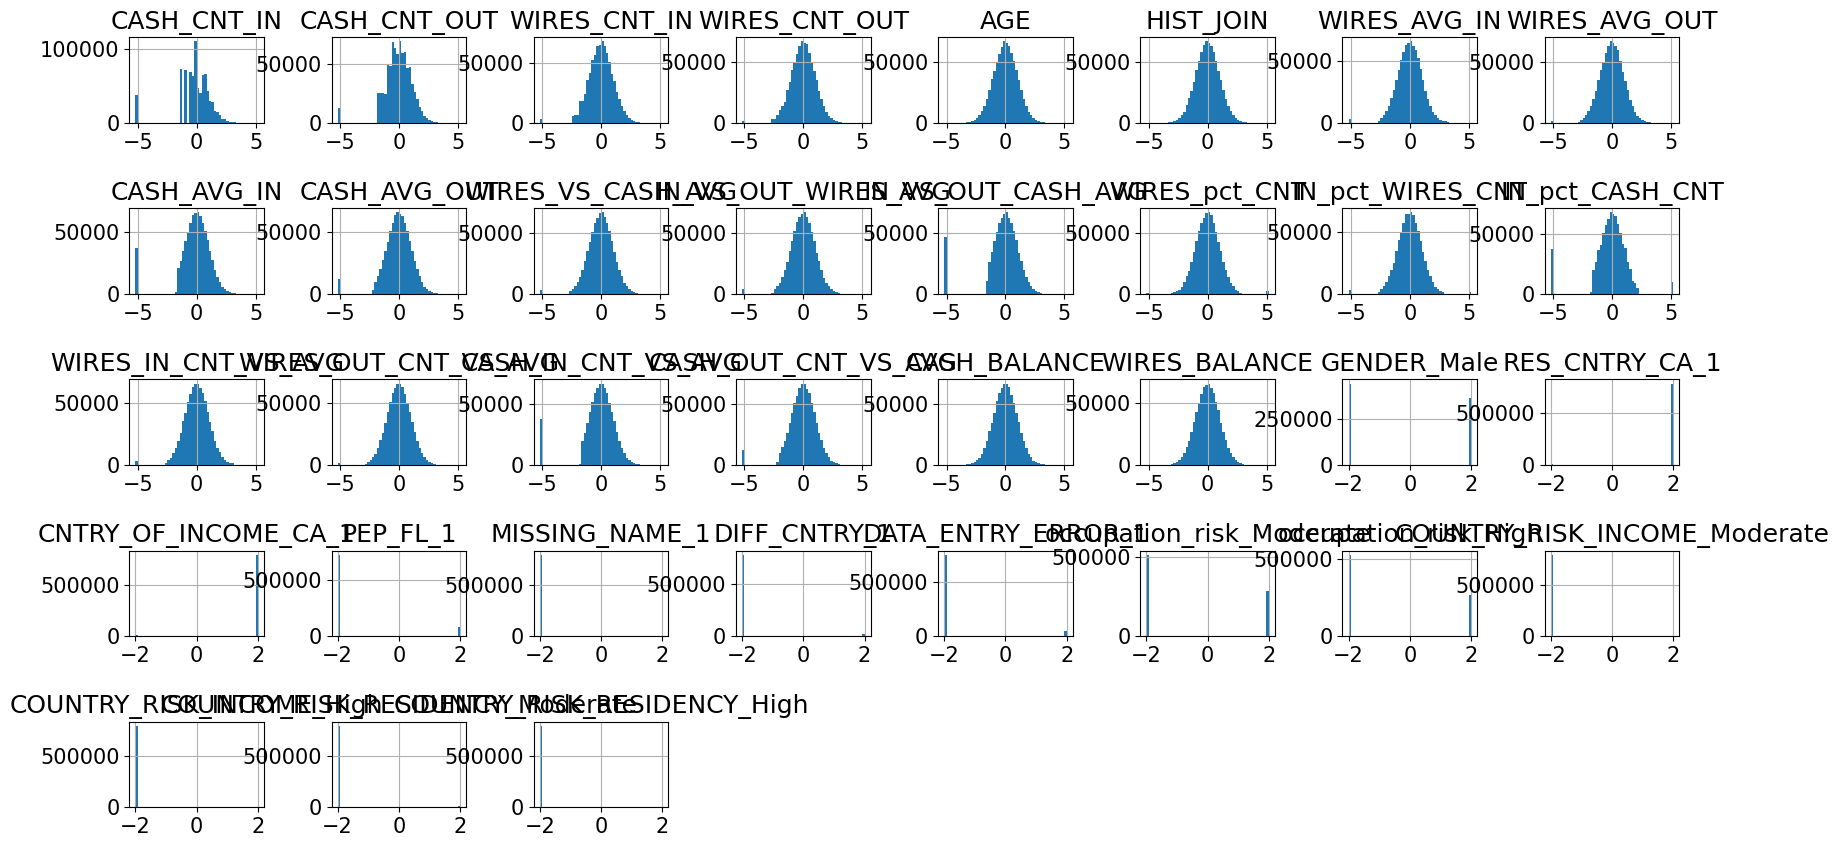

In [ ]:
X_prep.hist(bins = 50, layout = (5, int(X_prep.select_dtypes(include = np.number).shape[1] / 5) + 1), figsize= (20,10))
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

### y_train -> y_prep 0,1,2

In [ ]:
# multiclass
y_prep = y_train.replace({'low': 0, 'medium': 1, 'high': 2}).to_numpy() 

# Ordinal Classification

Main paper: (2015) [Ordinal Regression Methods: Survey and Experimental Study](https://ieeexplore.ieee.org/abstract/document/7161338)
- "It is important to note that naïve approaches and ordinal binary decompositions can be applied using almost any base binary classifier or regressor."
- “assessed ordered categorical variables” = variables where a user provides his/her judgement on the grade of the ordered categorical variable

Options to implement and compare:
- Baseline: Multi-class (nominal classification)
  - easy but lost information about ranking
- K-1 binary classification
  - (2001, Frank and Hall) [A simple approach to ordinal classification](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf)
    - k-class ordinal problem is converted into k-1 binary class problem
    - [code](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c)
    - issue: rank inconsistency
      - e.g. output [0.9, 0.9, 0.49, 0.72, 0.1]. Iterating from left to right would result in a prediction label of 2 (since 0.49 < 0.5), even though the right answer might just as well be 4 (since 0.72 > 0.5).

- Extended binary classification
  - (2007, Li and Lin) [Ordinal Regression by Extended Binary Classification](https://papers.nips.cc/paper/2006/file/019f8b946a256d9357eadc5ace2c8678-Paper.pdf)
  - C x C cost matrix with each row = V-shaped with higher costs at the two ends
  - (2007 Cardoso, Costa) [Learning to Classify Ordinal Data: The Data Replication Method](https://www.jmlr.org/papers/volume8/cardoso07a/cardoso07a.pdf)
  
- Evaluation metrics
  - Our approach
    - (2009, Furnkranz, Eyke Hullermeier, Stijn Vanderlooy) [Binary Decomposition Methods for Multipartite Ranking](https://link.springer.com/content/pdf/10.1007/978-3-642-04180-8_41.pdf)
      - Multiclass AUC for multipartite ranking
      - AUROC ovo macro weighted
  - Others
    - (2009, Baccianella, Andrea Esuli and Fabrizio Sebastiani) [Evaluation Measures for Ordinal Regression](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5364825)
      - average = 'macro' instead of 'micro' for class imbalance
      - MAE , i.e. the average deviation between predicted and actual targets in number of categories
      - squared loss or cross entropy loss
      - should use average precision instead?
    - (2022) [Class distance weighted cross-entropy loss](https://arxiv.org/pdf/2202.05167.pdf)

- Others
  - https://towardsdatascience.com/how-to-perform-ordinal-regression-classification-in-pytorch-361a2a095a99
  - https://towardsai.net/p/l/from-classification-to-ordinal-regression
  - from coarse-grained to fine-grained https://www.nature.com/articles/s41598-020-79007-5#Abs1
  - Thermometer scaling (aka label extension)
  - (2007, Cheng) [A Neural Network Approach to Ordinal Regression](https://arxiv.org/pdf/0704.1028.pdf)
    - loss = squared error in rank
    - issue: rank inconsistency

- CORAL framework for rank consistency
  - (2020, Cao, Mirjalili, Raschka) [Rank consistent ordinal regression for neural networks with application to age estimation](https://arxiv.org/pdf/1901.07884.pdf)
  - label extension + weight sharing at penultimate layer

## MAE and AUC scorer
- macro_avg_MAE(), multipartite_AUC()

## 5-fold custom CV iterator Stratified Shuffle Split()

In [ ]:
cv_split = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)

In [ ]:
# check class balance is maintained in CV folds
# CV_train_index, CV_test_index = next(cv_split.split(X_prep, y_train))
# class_label, class_balance = np.unique(y_train, return_counts=True, axis = 0)
# print(f"Original class balance = \n{class_label}, \n{class_balance / class_balance.sum()}")
# class_label, class_balance = np.unique(y_train[CV_test_index,:], return_counts=True, axis = 0)
# print(f"CV-fold class balance = \n{class_label}, \n{class_balance / class_balance.sum()}")

## X,y_train -> X_subset, y_subset for 100k rows to test

In [ ]:
first_n = None
X_subset = X_prep[:first_n]
y_subset = y_prep[:first_n]

In [ ]:
np.unique(y_subset, return_counts=True)

(array([0, 1, 2], dtype=int64), array([479876, 280000,  40000], dtype=int64))

## Binary decomposition implementation
- ExtendedBinary() vs Frank&Hall()

### Significant improvement for linear models

### testing (11min for all 700k rows)
- SGDClassifier with loss = 'log_loss'

In [ ]:
def test_performance(estimator, y_target, custom_scorer, sample_weight = None):
  print(f"Score for Classes: {np.unique(y_target)}")
  start = time.time()
  # if sample_weight == 'balanced':
  #   sample_weight = 1/pd.Series(y_target).replace({key: value for key, value in zip(*np.unique(y_target, return_counts = True))}).to_numpy()
  estimator.fit(X_subset, y_target, sample_weight = sample_weight)
  output = {'model': estimator, 'scores': cross_val_score(estimator, X_subset, y_target, scoring = custom_scorer, cv=cv_split)}
  end = time.time()
  print(f"Time taken = {end - start:0.1f} seconds")
  return output

In [ ]:
test_params = {
    'baseline': (
        SGDClassifier(loss='log', penalty='elasticnet'),
        y_subset,
        multipartite_AUC_scorer,
        None),
    'multinomial\nclass_balanced': (
        SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'ExtendedBinary_OrderedPartitions': (
        ExtendedBinary(SGDClassifier(loss='log', penalty='elasticnet'), decomposition_method='OrderedPartitions'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'ExtendedBinary_OrderedPartitions\nclass_balanced': (
        ExtendedBinary(SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'), decomposition_method='OrderedPartitions'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'ExtendedBinary_OneVsFollowers': (
        ExtendedBinary(SGDClassifier(loss='log', penalty='elasticnet'), decomposition_method='OneVsFollowers'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'ExtendedBinary_OneVsFollowers\nclass_balanced': (
        ExtendedBinary(SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'), decomposition_method='OneVsFollowers'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'ExtendedBinary_OneVsPrevious': (
        ExtendedBinary(SGDClassifier(loss='log', penalty='elasticnet'), decomposition_method='OneVsPrevious'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'ExtendedBinary_OneVsPrevious\nclass_balanced': (
        ExtendedBinary(SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'), decomposition_method='OneVsPrevious'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'Frank&Hall_OrderedPartitions': (
        FnHClassifier(
            SGDClassifier(loss='log', penalty='elasticnet'),
            SGDClassifier(loss='log', penalty='elasticnet'),
            decomposition_method='OrderedPartitions'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'Frank&Hall_OrderedPartitions_class_balanced': (
        FnHClassifier(
            SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'),
            SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'),
            decomposition_method='OrderedPartitions'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'Frank&Hall_OneVsFollowers': (
        FnHClassifier(
            SGDClassifier(loss='log', penalty='elasticnet'),
            SGDClassifier(loss='log', penalty='elasticnet'),
            decomposition_method='OneVsFollowers'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'Frank&Hall_OneVsFollowers_class_balanced': (
        FnHClassifier(
            SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'),
            SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'),
            decomposition_method='OneVsFollowers'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'Frank&Hall_OneVsPrevious': (
        FnHClassifier(
            SGDClassifier(loss='log', penalty='elasticnet'),
            SGDClassifier(loss='log', penalty='elasticnet'),
            decomposition_method='OneVsPrevious'), 
        y_subset,
        multipartite_AUC_scorer,
        None),
    'Frank&Hall_OneVsPrevious_class_balanced': (
        FnHClassifier(
            SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'),
            SGDClassifier(loss='log', penalty='elasticnet',class_weight='balanced'),
            decomposition_method='OneVsPrevious'), 
        y_subset,
        multipartite_AUC_scorer,
        None)
}

test_result = {}

for key, value in tqdm(test_params.items()):
  print(key)
  test_result[key] = test_performance(*value)

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

baseline
Score for Classes: [0 1 2]
1.00, 2.00
1.00, 1.96
0.78, 1.52
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.77']
1.00, 2.00
1.00, 1.95
0.77, 1.51
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.76']
1.00, 2.00
1.00, 1.95
0.77, 1.51
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.76']
1.00, 2.00
1.00, 1.96
0.77, 1.52
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.76']


  7%|█████▉                                                                             | 1/14 [00:39<08:34, 39.56s/it]

1.00, 2.00
1.00, 1.95
0.78, 1.52
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.77']
Time taken = 39.5 seconds
multinomial
class_balanced
Score for Classes: [0 1 2]
1.00, 2.00
1.00, 1.97
0.78, 1.54
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.78']
1.00, 2.00
1.00, 1.98
0.78, 1.53
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.77']
1.00, 2.00
1.00, 1.97
0.78, 1.53
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.77']
1.00, 2.00
1.00, 1.98
0.79, 1.55
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.78']


 14%|███████████▊                                                                       | 2/14 [01:29<09:08, 45.68s/it]

1.00, 2.00
1.00, 1.97
0.78, 1.54
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.77']
Time taken = 49.9 seconds
ExtendedBinary_OrderedPartitions
Score for Classes: [0 1 2]
1.00, 2.00
1.00, 2.00
0.51, 0.82
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.44']
1.00, 2.00
1.00, 2.00
0.51, 0.81
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.44']
1.00, 2.00
1.00, 2.00
0.49, 0.79
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.43']
1.00, 2.00
1.00, 2.00
0.51, 0.82
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.44']


 21%|█████████████████▊                                                                 | 3/14 [02:02<07:17, 39.81s/it]

1.00, 2.00
1.00, 2.00
0.51, 0.78
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.43']
Time taken = 32.8 seconds
ExtendedBinary_OrderedPartitions
class_balanced
Score for Classes: [0 1 2]
1.00, 1.97
1.00, 2.00
0.49, 0.92
['Classes 0, 1: 0.99', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.47']
1.00, 1.96
1.00, 2.00
0.48, 0.91
['Classes 0, 1: 0.99', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.46']
1.00, 1.97
1.00, 2.00
0.46, 0.87
['Classes 0, 1: 0.99', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.44']
1.00, 1.98
1.00, 2.00
0.48, 0.90
['Classes 0, 1: 0.99', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.46']


 29%|███████████████████████▋                                                           | 4/14 [02:37<06:21, 38.16s/it]

1.00, 1.92
1.00, 2.00
0.46, 0.89
['Classes 0, 1: 0.97', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.45']
Time taken = 35.6 seconds
ExtendedBinary_OneVsFollowers
Score for Classes: [0 1 2]
1.00, 2.00
1.00, 2.00
0.50, 0.81
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.43']
1.00, 2.00
1.00, 2.00
0.53, 0.82
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.45']
1.00, 2.00
1.00, 2.00
0.49, 0.79
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.43']
1.00, 2.00
1.00, 2.00
0.52, 0.81
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.44']


 36%|█████████████████████████████▋                                                     | 5/14 [03:01<04:56, 32.96s/it]

1.00, 2.00
1.00, 2.00
0.53, 0.81
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.45']
Time taken = 23.7 seconds
ExtendedBinary_OneVsFollowers
class_balanced
Score for Classes: [0 1 2]
1.00, 1.99
1.00, 2.00
0.49, 0.88
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.46']
1.00, 1.99
1.00, 2.00
0.48, 0.87
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.45']
1.00, 1.99
1.00, 2.00
0.49, 0.87
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.45']
1.00, 1.98
1.00, 2.00
0.47, 0.88
['Classes 0, 1: 0.99', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.45']


 43%|███████████████████████████████████▌                                               | 6/14 [03:26<04:02, 30.35s/it]

1.00, 1.98
1.00, 2.00
0.46, 0.83
['Classes 0, 1: 0.99', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.43']
Time taken = 25.3 seconds
ExtendedBinary_OneVsPrevious
Score for Classes: [0 1 2]
1.00, 2.00
1.00, 2.00
0.52, 0.80
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.44']
1.00, 2.00
1.00, 2.00
0.49, 0.76
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.42']
1.00, 2.00
1.00, 2.00
0.50, 0.77
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.42']
1.00, 2.00
1.00, 2.00
0.51, 0.78
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.43']


 50%|█████████████████████████████████████████▌                                         | 7/14 [03:58<03:35, 30.84s/it]

1.00, 2.00
1.00, 2.00
0.50, 0.78
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.43']
Time taken = 31.8 seconds
ExtendedBinary_OneVsPrevious
class_balanced
Score for Classes: [0 1 2]
1.00, 1.90
1.00, 2.00
0.46, 0.89
['Classes 0, 1: 0.97', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.45']
1.00, 1.93
1.00, 2.00
0.45, 0.88
['Classes 0, 1: 0.98', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.45']
1.00, 1.96
1.00, 2.00
0.46, 0.87
['Classes 0, 1: 0.98', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.44']
1.00, 1.94
1.00, 2.00
0.45, 0.87
['Classes 0, 1: 0.98', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.44']


 57%|███████████████████████████████████████████████▍                                   | 8/14 [04:33<03:12, 32.16s/it]

1.00, 1.92
1.00, 2.00
0.46, 0.88
['Classes 0, 1: 0.97', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.44']
Time taken = 35.0 seconds
Frank&Hall_OrderedPartitions
Score for Classes: [0 1 2]
1.00, 2.00
1.00, 1.93
0.72, 1.40
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.71']
1.00, 2.00
1.00, 1.92
0.73, 1.41
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.97', 'Classes 1, 2: 0.71']
1.00, 2.00
1.00, 1.94
0.72, 1.39
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.70']
1.00, 2.00
1.00, 1.92
0.72, 1.41
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.97', 'Classes 1, 2: 0.71']


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [05:00<02:32, 30.58s/it]

1.00, 2.00
1.00, 1.94
0.71, 1.39
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.70']
Time taken = 27.1 seconds
Frank&Hall_OrderedPartitions_class_balanced
Score for Classes: [0 1 2]
1.00, 1.99
1.00, 1.98
0.67, 1.32
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.67']
1.00, 2.00
1.00, 1.96
0.70, 1.37
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.69']
1.00, 1.99
1.00, 1.98
0.66, 1.30
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.65']
1.00, 1.99
1.00, 1.98
0.67, 1.32
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.66']


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [05:51<02:26, 36.66s/it]

1.00, 1.99
1.00, 1.98
0.67, 1.31
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.66']
Time taken = 50.3 seconds
Frank&Hall_OneVsFollowers
Score for Classes: [0 1 2]
1.00, 2.00
1.00, 1.99
0.86, 1.71
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.85']
1.00, 2.00
1.00, 1.99
0.86, 1.72
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.86']
1.00, 2.00
1.00, 1.99
0.85, 1.69
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.85']
1.00, 2.00
1.00, 1.99
0.86, 1.71
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.86']


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [06:13<01:36, 32.17s/it]

1.00, 2.00
1.00, 1.99
0.86, 1.70
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.85']
Time taken = 22.0 seconds
Frank&Hall_OneVsFollowers_class_balanced
Score for Classes: [0 1 2]
1.00, 2.00
1.00, 2.00
0.86, 1.72
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.86']
1.00, 2.00
1.00, 2.00
0.87, 1.73
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.87']
1.00, 2.00
1.00, 2.00
0.87, 1.72
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.86']
1.00, 2.00
1.00, 1.99
0.87, 1.72
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.86']


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [06:44<01:03, 31.82s/it]

1.00, 2.00
1.00, 2.00
0.87, 1.72
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.86']
Time taken = 31.0 seconds
Frank&Hall_OneVsPrevious
Score for Classes: [0 1 2]
1.00, 2.00
1.00, 1.94
0.71, 1.38
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.70']
1.00, 2.00
1.00, 1.94
0.72, 1.39
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.70']
1.00, 2.00
1.00, 1.93
0.72, 1.39
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.71']
1.00, 2.00
1.00, 1.94
0.73, 1.40
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.71']


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [07:11<00:30, 30.39s/it]

1.00, 2.00
1.00, 1.94
0.72, 1.38
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.98', 'Classes 1, 2: 0.70']
Time taken = 27.1 seconds
Frank&Hall_OneVsPrevious_class_balanced
Score for Classes: [0 1 2]
1.00, 1.99
1.00, 1.97
0.68, 1.34
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.67']
1.00, 1.99
1.00, 1.97
0.68, 1.34
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.67']
1.00, 2.00
1.00, 1.97
0.68, 1.34
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.67']
1.00, 1.99
1.00, 1.97
0.68, 1.35
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.68']


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [07:58<00:00, 34.14s/it]

1.00, 1.99
1.00, 1.98
0.66, 1.30
['Classes 0, 1: 1.00', 'Classes 0, 2: 0.99', 'Classes 1, 2: 0.65']
Time taken = 46.7 seconds


### results

In [ ]:
sorted(test_result, key = lambda x: np.median(test_result.get(x)['scores']))

['ExtendedBinary_OneVsPrevious\nclass_balanced',
 'ExtendedBinary_OneVsPrevious',
 'ExtendedBinary_OrderedPartitions',
 'ExtendedBinary_OneVsFollowers',
 'ExtendedBinary_OneVsFollowers\nclass_balanced',
 'ExtendedBinary_OrderedPartitions\nclass_balanced',
 'Frank&Hall_OrderedPartitions_class_balanced',
 'Frank&Hall_OneVsPrevious_class_balanced',
 'Frank&Hall_OneVsPrevious',
 'Frank&Hall_OrderedPartitions',
 'baseline',
 'multinomial\nclass_balanced',
 'Frank&Hall_OneVsFollowers',
 'Frank&Hall_OneVsFollowers_class_balanced']

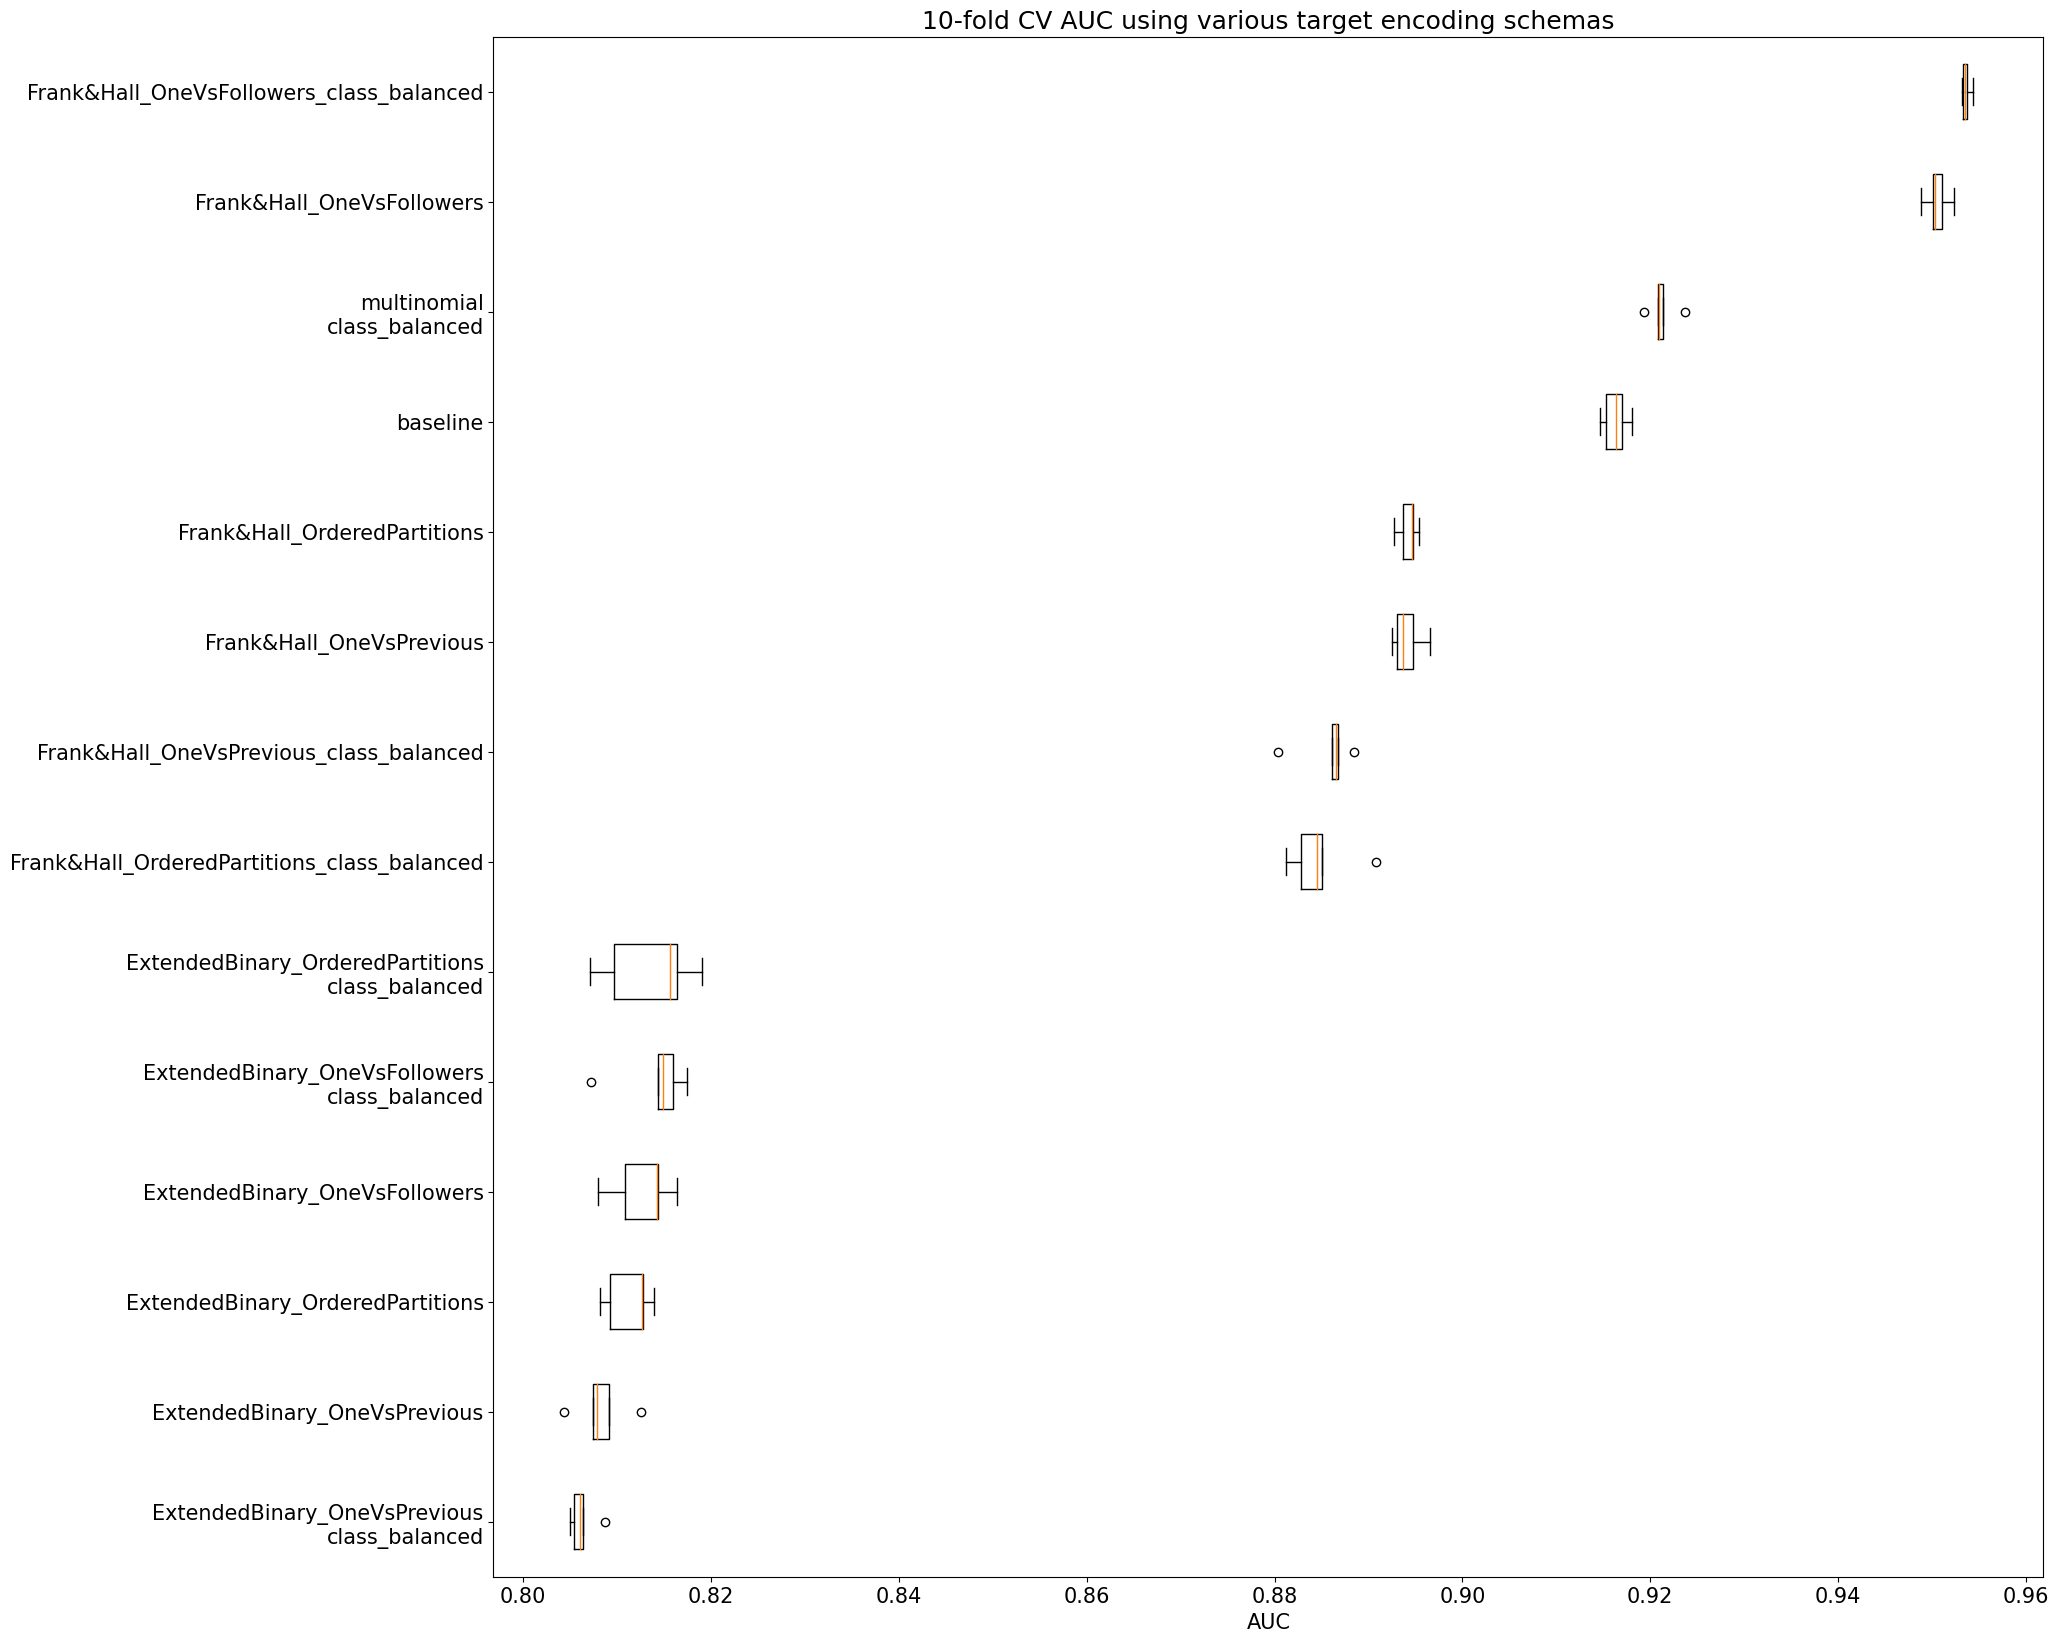

In [ ]:
sorted_labels = sorted(test_result, key = lambda x: np.median(test_result.get(x)['scores']))
cv_scores = [test_result.get(label)['scores'] for label in sorted_labels]
fig, ax = plt.subplots(1,1, figsize = (20,20))
plt.boxplot(cv_scores, vert = False)
plt.yticks(ticks = np.arange(1,len(cv_scores)+1), 
           labels=sorted_labels)
plt.xlabel('AUC')
plt.title('10-fold CV AUC using various target encoding schemas')
plt.show()

In [ ]:
pd.DataFrame(test_result)[sorted_labels].T['scores'].explode().reset_index(drop = False).groupby('index').scores.agg(['mean', 'std']).sort_values('mean', ascending=False)

mean    std
index                                                         
Frank&Hall_OneVsFollowers_class_balanced         0.9536 0.0005
Frank&Hall_OneVsFollowers                        0.9505 0.0013
multinomial\nclass_balanced                      0.9212 0.0016
baseline                                         0.9163 0.0014
Frank&Hall_OrderedPartitions                     0.8942 0.0010
...                                                 ...    ...
ExtendedBinary_OrderedPartitions\nclass_balanced 0.8136 0.0050
ExtendedBinary_OneVsFollowers                    0.8128 0.0033
ExtendedBinary_OrderedPartitions                 0.8114 0.0025
ExtendedBinary_OneVsPrevious                     0.8083 0.0030
ExtendedBinary_OneVsPrevious\nclass_balanced     0.8063 0.0015

[14 rows x 2 columns]

## Combine all as data_preparation()

In [ ]:
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('myquantiletransformer',
                                                                   MyQuantileTransformer(output_distribution='normal',
                                                                                         random_state=42))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F81596D520>),
                                                 ('cat',
                                                  Pipeline(steps=[('randomimputer',
                                                                   Ra...
                                                  ['GENDER', 'RES_CNTRY_CA',
                                                   'CNTRY_OF_INCOME_CA',
                                                   'PEP_FL', 'MISSING_NAME',
                                                   'DIFF_CNTRY',
                                                   'DATA_ENTRY_ERROR']),
                                                 ('ord',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('thermometerencoder',
                                                                   ThermometerEncoder()),
                                                                  ('myminmaxscaler',
                                                                   MyMinMaxScaler(feature_range=(-2,
                                                                                                 2)))]),
                                                  ['occupation_risk',
                                                   'COUNTRY_RISK_INCOME',
                                                   'COUNTRY_RISK_RESIDENCY'])],
                                   verbose_feature_names_out=False))])

## runtime: 13min for all 700k rows

In [ ]:
data_preparation.fit(X_train[:None], y_prep[:None])
X_subset_prep = pd.DataFrame(data_preparation.transform(X_train[:None]), columns = data_preparation.get_feature_names_out())
X_subset_prep

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT     AGE  \
0           -0.0063        0.0289        0.5880         0.6165 -0.7846   
1            1.5713        0.0289       -1.2448        -0.3203  1.1673   
2           -5.1993        0.0289       -0.9979        -1.7219 -1.3347   
3            0.8179       -0.1549       -0.0439        -0.0804  0.3734   
4            0.1486       -1.3130       -1.2049        -1.3621  2.5169   
...             ...           ...           ...            ...     ...   
799871      -0.9071       -0.0301        0.0326        -0.3005 -1.8125   
799872       0.8179        1.2613        1.3160        -0.1321  0.9961   
799873       0.4170       -0.5909       -0.2381        -0.5452  1.1276   
799874      -0.9071       -1.1449        0.0628        -0.0628 -1.5093   
799875      -0.6150        0.0289       -0.7530        -0.4570 -0.6187   

        HIST_JOIN  WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  CASH_AVG_OUT  \
0         -0.5650       -0.3982        -0.4592      -0.9479       -0.2399   
1         -0.2945        2.0193         1.6964       0.9722        1.1116   
2         -1.2479       -0.9716        -1.4480      -5.1993       -0.6068   
3         -0.8377        0.6215         0.9722       0.6561        1.6905   
4          1.7601        0.7153         1.9097       0.8300        0.3375   
...           ...           ...            ...          ...           ...   
799871    -0.2820       -0.5510        -0.2961      -1.5241        0.0544   
799872     1.9962        0.3511         0.3710       0.5290        0.3472   
799873     1.6171       -0.3273        -0.2788       0.1355       -0.2621   
799874    -0.1670       -1.3472        -1.5617      -1.6689       -1.1626   
799875    -1.3532       -0.2108        -0.0786      -0.0834       -0.7856   

        WIRES_VS_CASH_AVG  IN_VS_OUT_WIRES_AVG  IN_VS_OUT_CASH_AVG  \
0                 -0.3398              -0.2850             -0.2696   
1                  1.4983               1.4144             -0.5730   
2                 -0.3015              -0.0214             -5.1993   
3                  0.5767              -0.0331             -1.1804   
4                  1.2651              -1.6199              0.7269   
...                   ...                  ...                 ...   
799871            -0.3221              -0.6899             -1.1573   
799872             0.5536               0.3454              0.2281   
799873            -0.8387              -0.3835              0.8548   
799874            -0.4936              -0.3905             -1.2607   
799875             0.0121              -0.4849              0.9528   

        WIRES_pct_CNT  IN_pct_WIRES_CNT  IN_pct_CASH_CNT  WIRES_IN_CNT_VS_AVG  \
0              0.7120           -0.0274          -0.0489               0.7966   
1             -1.3377           -1.4743           1.1888              -1.9242   
2             -1.6370            1.5086          -5.1993               0.1510   
3             -0.2255            0.0633           0.8232              -0.6941   
4             -0.9674            0.4047           1.5175              -1.3361   
...               ...               ...              ...                  ...   
799871         0.1374            0.4785          -0.9614               0.5795   
799872        -0.6640            1.2938          -0.2875               0.0437   
799873        -0.1549            0.5085           0.9476               0.3391   
799874         1.6782            0.1765           0.3415               1.0889   
799875        -0.5478           -0.5054          -0.6879               0.0522   

        WIRES_OUT_CNT_VS_AVG  CASH_IN_CNT_VS_AVG  CASH_OUT_CNT_VS_AVG  \
0                     0.9240              0.6062               0.4533   
1                    -1.3860              0.7554              -0.8093   
2                    -0.4776             -5.1993               0.6315   
3                    -0.9227              0.1561              -1.1136   
4              

## dump data_preparation.joblib

In [ ]:
dump(data_preparation, f'data_preparation.joblib')

['data_preparation.joblib']

## load data_preparation()

In [ ]:
data_preparation = load('data_preparation.joblib')
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('myquantiletransformer',
                                                                   MyQuantileTransformer(output_distribution='normal',
                                                                                         random_state=42))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F81596A5B0>),
                                                 ('cat',
                                                  Pipeline(steps=[('randomimputer',
                                                                   Ra...
                                                  ['GENDER', 'RES_CNTRY_CA',
                                                   'CNTRY_OF_INCOME_CA',
                                                   'PEP_FL', 'MISSING_NAME',
                                                   'DIFF_CNTRY',
                                                   'DATA_ENTRY_ERROR']),
                                                 ('ord',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('thermometerencoder',
                                                                   ThermometerEncoder()),
                                                                  ('myminmaxscaler',
                                                                   MyMinMaxScaler(feature_range=(-2,
                                                                                                 2)))]),
                                                  ['occupation_risk',
                                                   'COUNTRY_RISK_INCOME',
                                                   'COUNTRY_RISK_RESIDENCY'])],
                                   verbose_feature_names_out=False))])

# Shortlist promising models (37min)

In [ ]:
# create a list of models using standard hyperparameters to compare performance
dict_clf = {

    "sgd": SGDClassifier(loss='log', penalty='elasticnet', class_weight = 'balanced'), # SGD solver for logistic regression
    "nb": GaussianNB(),
    "tree": DecisionTreeClassifier(class_weight = 'balanced'),
    "forest": RandomForestClassifier(n_jobs = -1, class_weight = 'balanced'),
    "extree": ExtraTreesClassifier(n_jobs = -1, class_weight = 'balanced'),
    "histgb": HistGradientBoostingClassifier(),
    "bagging": BaggingClassifier(n_jobs = -1),
    "ada": AdaBoostClassifier(),
    "lgbm": LGBMClassifier(class_weight='balanced')
}

In [ ]:
list_clf = []
AUC_CVs = []
AUC_train = []
list_precision = []
list_recall = []
list_thresholds = []
store_clf = []

# fit each classification algorithm and calculate 10-fold CV AUC
for key, item in tqdm(dict_clf.items()):
  print(key)
  clf = FnHClassifier(
      item, copy.deepcopy(item),
      decomposition_method='OneVsFollowers').fit(X_subset_prep, y_prep)
  AUC_train.append(multipartite_AUC(y_prep, clf.predict_proba(X_subset_prep)))
  store_clf.append(clf)
  
  # cross validation score
  AUC_CV = cross_val_score(clf, X_subset_prep, y_prep, cv = cv_split, scoring = multipartite_AUC_scorer, n_jobs = -1)

  list_clf.append(key)
  AUC_CVs.append(AUC_CV)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

sgd
1.00, 2.00
1.00, 2.00
0.86, 1.71
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.86']


 11%|█████████▎                                                                          | 1/9 [00:15<02:03, 15.40s/it]

nb
0.98, 1.97
0.97, 1.93
0.79, 0.87
['Classes 0, 1: 0.99', 'Classes 0, 2: 0.97', 'Classes 1, 2: 0.55']


 22%|██████████████████▋                                                                 | 2/9 [00:22<01:12, 10.31s/it]

tree
1.00, 2.00
1.00, 2.00
1.00, 2.00
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 1.00']


 33%|████████████████████████████                                                        | 3/9 [02:31<06:28, 64.80s/it]

forest
1.00, 2.00
1.00, 2.00
1.00, 2.00
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 1.00']


 44%|████████████████████████████████████▉                                              | 4/9 [09:48<17:37, 211.51s/it]

extree
1.00, 2.00
1.00, 2.00
1.00, 2.00
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 1.00']


 56%|██████████████████████████████████████████████                                     | 5/9 [14:23<15:38, 234.58s/it]

histgb
1.00, 2.00
1.00, 2.00
0.94, 1.88
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.94']


 67%|███████████████████████████████████████████████████████▎                           | 6/9 [15:23<08:45, 175.28s/it]

bagging
1.00, 2.00
1.00, 2.00
1.00, 2.00
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 1.00']


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [20:44<07:25, 222.80s/it]

ada
1.00, 2.00
1.00, 2.00
0.74, 1.28
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.67']


 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [27:05<04:33, 273.09s/it]

lgbm
1.00, 2.00
1.00, 2.00
0.94, 1.88
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.94']


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [27:38<00:00, 184.29s/it]


In [ ]:
# sort the models by AUC but not other performance metrics dependent on decision threshold, e.g. precision and recall
mean_AUC = [np.mean(AUC) for AUC in AUC_CVs]
sd_AUC = [np.std(AUC) for AUC in AUC_CVs]
print("Models sorted by cross validation AUC score")
for mean, sd, clf_name in sorted(zip(mean_AUC, sd_AUC, list_clf), reverse = True):
  print(f"CV AUC: AVG {mean:0.4f} / SD {sd:0.4f} / {clf_name}")

Models sorted by cross validation AUC score
CV AUC: AVG 0.9777 / SD 0.0003 / lgbm
CV AUC: AVG 0.9774 / SD 0.0004 / histgb
CV AUC: AVG 0.9750 / SD 0.0003 / forest
CV AUC: AVG 0.9738 / SD 0.0004 / extree
CV AUC: AVG 0.9556 / SD 0.0007 / bagging
CV AUC: AVG 0.9531 / SD 0.0005 / sgd
CV AUC: AVG 0.8849 / SD 0.0047 / ada
CV AUC: AVG 0.8351 / SD 0.0009 / nb
CV AUC: AVG 0.8263 / SD 0.0009 / tree


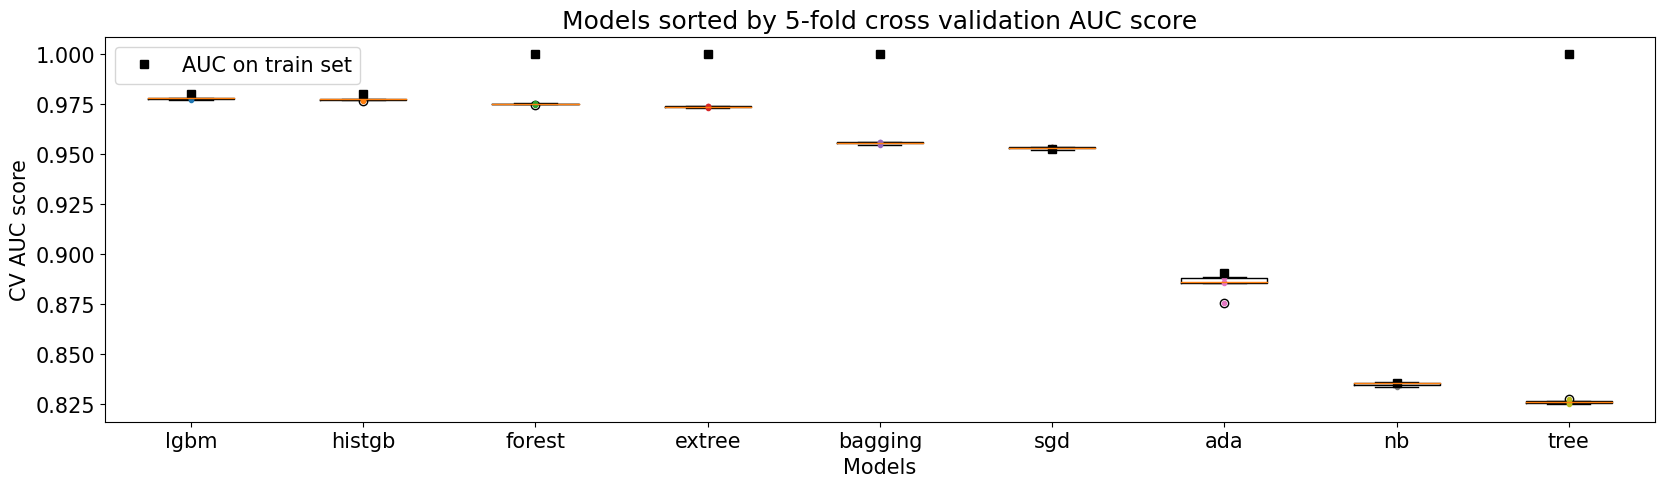

In [ ]:
# sort the models and plot the box plots of CV AUC scores
mean_AUC = [np.mean(AUC) for AUC in AUC_CVs]
sorted_AUC_CV = [i for _, i in [(mean_AUC[i], AUC_CVs[i]) for i in np.argsort(mean_AUC)[::-1]]]
sorted_clf = [i for _, i in [(mean_AUC[i], list_clf[i]) for i in np.argsort(mean_AUC)[::-1]]]
sorted_AUC_train = [i for _, i in [(mean_AUC[i], AUC_train[i]) for i in np.argsort(mean_AUC)[::-1]]]
plt.boxplot(sorted_AUC_CV, labels=sorted_clf)
# add dots for CV AUC scores
for i, AUC in enumerate(sorted_AUC_CV):
  plt.plot([i+1]*len(AUC), AUC, ".")
plt.plot([*range(1,len(sorted_AUC_CV)+1,1)], sorted_AUC_train, "ks", label='AUC on train set')
plt.title(f"Models sorted by {cv_split.get_n_splits()}-fold cross validation AUC score")
plt.xlabel("Models")
plt.ylabel("CV AUC score")
plt.legend()
plt.show()

# Fine-tune hyperparameters of shortlisted models with RandomizedSearchCV

In [ ]:
# create a list of hyperparameters to tune for each shortlisted classifier based on performance and fitting time
shortlisted_clfs = {
    "lgbm": LGBMClassifier(class_weight='balanced'),
    "histgb": HistGradientBoostingClassifier(),    
}

target_scores = {
    "lgbm": 0.9779,
    "histgb": 0.97716}

param_grids = {
    # https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#parameters-tuning
    # https://lightgbm.readthedocs.io/en/v3.3.5/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
    "lgbm": {
        "lgbm__estimator1__learning_rate": loguniform(a = 0.1, b = 0.11),
        "lgbm__estimator1__n_estimators": [100, 125, 150, 175, 200],
        "lgbm__estimator0__learning_rate": loguniform(a = 0.1, b = 0.11),
        "lgbm__estimator0__n_estimators": [100, 125, 150, 175, 200],
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html
    "histgb": {
        "histgb__estimator1__learning_rate": loguniform(a = 0.1, b = 0.11),
        "histgb__estimator0__learning_rate": loguniform(a = 0.1, b = 0.11),
    },
     
    
}

In [ ]:
# testing reasonable range of hyperparameters before RandomizedSearchCV
for clf_name, clf in tqdm(shortlisted_clfs.items()):
  
  # remove transformation and feature selection here from the pipeline to save time (alternative: cache)
  full_pipeline = Pipeline(
      [(clf_name, FnHClassifier(
          clf, copy.deepcopy(clf),
          decomposition_method='OneVsFollowers')
      )]) 

  print(clf)

  param_grid = copy.deepcopy(param_grids[clf_name])

  
  random_search = RandomizedSearchCV(
      full_pipeline, 
      param_grid, 
      cv = cv_split, 
      n_iter= 5, 
      scoring = multipartite_AUC_scorer,
      random_state = 42,
      n_jobs = -1,
      error_score = 'raise')
  random_search.fit(X_subset_prep, y_prep)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

LGBMClassifier(class_weight='balanced')


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:01<00:00, 241.65s/it]


In [ ]:
print(f"target score = {target_scores[clf_name]:0.4f}")
pd.DataFrame(random_search.cv_results_).sort_values(['param_' + list(param_grid.keys())[-1]])[['param_' + x for x in list(param_grid.keys())] + ['mean_test_score', 'mean_fit_time', 'std_test_score']]

target score = 0.9774


param_estimator1__boosting_type param_estimator1__learning_rate  \
1                            dart                          0.1514   
0                            gbdt                          0.1737   
2                            gbdt                          0.1072   
3                            dart                          0.1260   
4                            dart                          0.1040   

  param_estimator1__n_estimators  mean_test_score  mean_fit_time  \
1                            125           0.9767        60.8139   
0                            150           0.9777        40.2828   
2                            150           0.9777        44.4037   
3                            150           0.9765        79.0678   
4                            175           0.9763        75.1354   

   std_test_score  
1          0.0004  
0          0.0004  
2          0.0004  
3          0.0004  
4          0.0004

## Run RandomizedSearchCV

In [ ]:
# Run RandomizedSearchCV to tune shortlisted models
random_clfs = []
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

for clf_name, clf in tqdm(shortlisted_clfs.items()):

  full_pipeline = Pipeline(
      [(clf_name, FnHClassifier(
          clf, copy.deepcopy(clf),
          decomposition_method='OneVsFollowers')
      )]) 

  print(clf_name)
  print(clf)
  
  param_grid = copy.deepcopy(param_grids[clf_name])

  random_search = RandomizedSearchCV(
      full_pipeline, 
      param_grid, 
      cv = cv_split, 
      n_iter= 5, 
      scoring = multipartite_AUC_scorer,
      random_state = 42,
      n_jobs = -1,
      error_score = 'raise')
  random_search.fit(X_subset_prep, y_prep)
  random_clfs.append(random_search)

  # print best scores
  print(f"\nbest_score: {random_search.best_score_}")
  print(f"best_params: {random_search.best_params_}")
  
  # dump the best model
  print(f'{clf_name} dumped at {current_time}')
  dump(random_search, f'{clf_name}_IMI_{current_time}.joblib') 

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

lgbm
LGBMClassifier(class_weight='balanced')


 50%|█████████████████████████████████████████▌                                         | 1/2 [01:55<01:55, 115.07s/it]


best_score: 0.9778821772228856
best_params: {'lgbm__estimator0__learning_rate': 0.10019638376607887, 'lgbm__estimator0__n_estimators': 125, 'lgbm__estimator1__learning_rate': 0.10712367614386822, 'lgbm__estimator1__n_estimators': 125}
lgbm dumped at 20230223_171128
histgb
HistGradientBoostingClassifier()


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [04:18<00:00, 129.25s/it]


best_score: 0.9774616777662422
best_params: {'histgb__estimator0__learning_rate': 0.10149812756350514, 'histgb__estimator1__learning_rate': 0.10149789423057416}
histgb dumped at 20230223_171128


# Check model performance after tuning

In [ ]:
tuned_models = {}
time_list = []
time_diff = []
# specify regex pattern to load latest models
match_pattern = '_IMI_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "IMI loaded", latest)

histgb IMI loaded 20230216_171210
lgbm IMI loaded 20230216_171210


## AUROC

In [ ]:
list_clf = []
auc_CVs = []
auc_train = []
list_precision = []
list_recall = []
list_thresholds = []

# fit each tuned model and calculate CV AUC
for key, item in tqdm(tuned_models.items()):
  clf = item.best_estimator_.fit(X_subset_prep, y_prep)
  auc_CV = cross_val_score(clf, X_subset_prep, y_prep, cv = cv_split, scoring = multipartite_AUC_scorer, n_jobs = -1)  

  list_clf.append(key)
  auc_CVs.append(auc_CV)
  auc_train.append(multipartite_AUC(y_prep, clf.predict_proba(X_subset_prep)))

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

1.00, 2.00


 50%|██████████████████████████████████████████                                          | 1/2 [01:07<01:07, 67.32s/it]

1.00, 2.00
0.94, 1.88
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.94']
1.00, 2.00


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 59.14s/it]

1.00, 2.00
0.94, 1.89
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.94']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.37s/it]


In [ ]:
mean_auc_CVs = [np.mean(auc) for auc in auc_CVs]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_auc_CVs, tuned_models.keys()), reverse = True)]
sorted_tuned_AUC = [i for _, i in sorted(zip(mean_auc_CVs, auc_CVs), reverse = True)]
sorted_train_AUC = [i for _, i in sorted(zip(mean_auc_CVs, auc_train), reverse = True)]

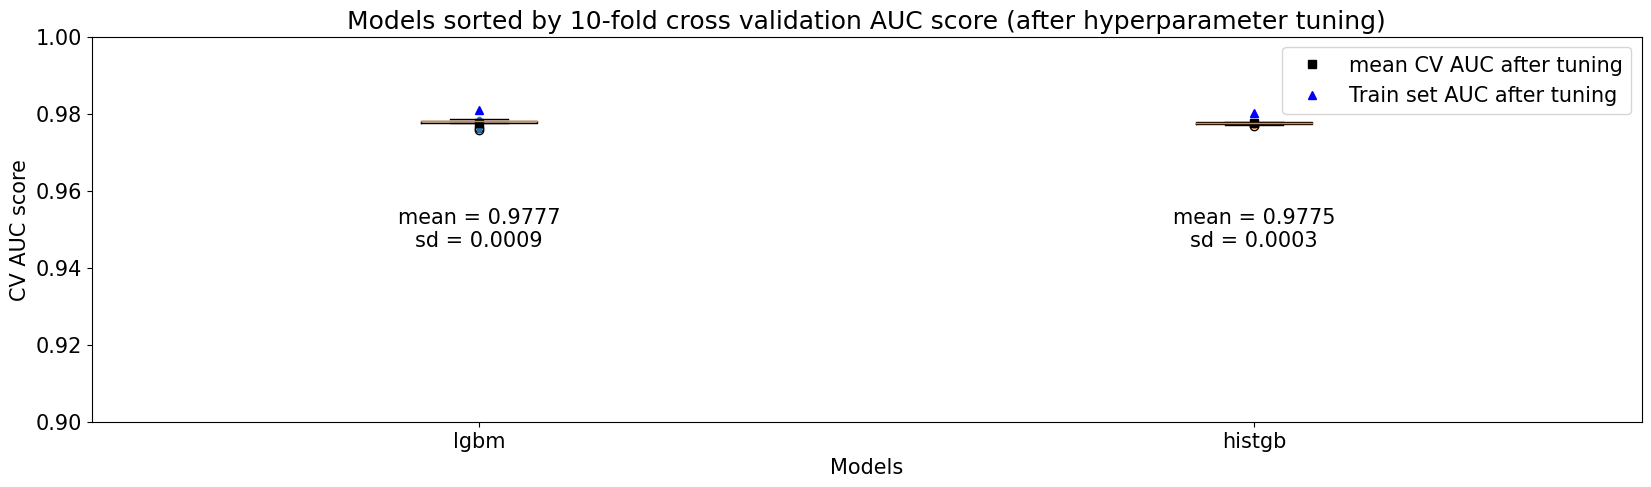

In [ ]:
plt.boxplot(sorted_tuned_AUC, labels=sorted_tuned_clf)
# add dots for CV AUC scores
for i, AUC in enumerate(sorted_tuned_AUC):
  plt.plot([i+1]*len(AUC), AUC, ".")
  plt.annotate(f"mean = {np.mean(AUC):0.4f}\nsd = {np.std(AUC):0.4f}",(i+1, 0.95), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], [np.mean(x) for x in sorted_tuned_AUC], 
         "ks", label = 'mean CV AUC after tuning')
plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], sorted_train_AUC, 
         "b^", label = 'Train set AUC after tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AUC score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0.9,1)
plt.ylabel("CV AUC score")
plt.show()

# Read test set

In [ ]:
test_set = pd.read_pickle("Task_2A_test.pkl")

## load dataset_preparation()

In [ ]:
dataset_preparation = load('dataset_preparation.joblib')
dataset_preparation

Pipeline(steps=[('manualtransformer', ManualTransformer()),
                ('outlierremoval', OutlierRemoval())])

In [ ]:
test_clean = dataset_preparation.transform(test_set)
test_clean

GENDER occupation_risk RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  \
0       Female             Low            1                  1      0   
1         Male            High            1                  1      1   
2       Female            High            1                  1      0   
3       Female             Low            1                  1      0   
4         Male            High            1                  1      0   
...        ...             ...          ...                ...    ...   
199995  Female            High            1                  1      0   
199996  Female             Low            1                  1      0   
199997    Male            High            1                  1      0   
199998  Female             Low            1                  1      0   
199999  Female             Low            1                  1      0   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  CASH_CNT_IN  CASH_CNT_OUT  \
0                      Low                    Low       4.0000       12.0000   
1                      Low                    Low       8.0000       33.0000   
2                      Low                    Low      17.0000       80.0000   
3                      Low                    Low       3.0000        9.0000   
4                      Low                    Low       7.0000       11.0000   
...                    ...                    ...          ...           ...   
199995                 Low                    Low       8.0000       17.0000   
199996                 Low                    Low       7.0000       29.0000   
199997                 Low                    Low       4.0000        8.0000   
199998                 Low                    Low       3.0000        5.0000   
199999                 Low                    Low       7.0000        8.0000   

        WIRES_CNT_IN  WIRES_CNT_OUT    RISK MISSING_NAME DIFF_CNTRY     AGE  \
0            78.0000        38.0000     low            0          0 73.5880   
1            66.0000       124.0000  medium            0          0 53.1526   
2           217.0000       214.0000  medium            0          0 36.8159   
3            89.0000       276.0000     low            0          0 56.9281   
4            51.0000       186.0000     low            0          0 37.0760   
...              ...            ...     ...          ...        ...     ...   
199995       28.0000        15.0000     low            0          0 63.9370   
199996       56.0000        84.0000     low            0          0 44.1533   
199997       62.0000        80.0000     low            0          0 42.6831   
199998      120.0000       190.0000     low            0          0 56.5749   
199999       93.0000       115.0000     low            0          0 42.2040   

        HIST_JOIN  WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  CASH_AVG_OUT  \
0         29.0951    1,639.9744       519.5263   1,098.5725      309.7242   
1         18.8282   74,066.7424     8,875.6694   1,493.8750    1,750.9394   
2         17.3224   51,443.5069    11,500.9112   1,154.6471    1,539.4125   
3         31.4415    2,082.0674     1,526.0978     739.6020      442.0060   
4          7.6578    2,576.0784     1,811.9677     735.0791      213.0379   
...           ...           ...            ...          ...           ...   
199995    23.4305    1,789.9643     1,692.6000     845.1866      136.6502   
199996    14.5161    1,788.5714     1,372.1548     987.0420      345.9280   
199997     5.2676    3,791.8226     1,266.6750     917.6643      298.8404   
199998    30.0671      721.7917       525.2579     541.0740      189.0456   
199999     5.2047    2,122.4731     1,628.7826     745.2519      381.7885   

       DATA_ENTRY_ERROR       TOTAL_SUM  WIRES_VS_CASH_AVG  \
0                     0    155,770.9800             2.5110   
1                     0  6,058,720.0000            18.5332   
2                     0 13,767,218.0000            21.4753   
3                     0    612,703.8600         

## X,y, sample_weights split

In [ ]:
# make a copy and split X and y
X_test = test_clean.drop(columns = ["RISK", "TOTAL_SUM"]).reset_index(drop = True).copy(deep = True)
y_test = test_clean["RISK"].reset_index(drop = True)
sample_weights_test = test_clean["TOTAL_SUM"].reset_index(drop = True)

In [ ]:
# multiclass
y_test_prep = y_test.replace({'low': 0, 'medium': 1, 'high': 2}).to_numpy() 

## load data_preparation()

In [ ]:
data_preparation = load('data_preparation.joblib')
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('myquantiletransformer',
                                                                   MyQuantileTransformer(output_distribution='normal',
                                                                                         random_state=42))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F808A37790>),
                                                 ('cat',
                                                  Pipeline(steps=[('randomimputer',
                                                                   Ra...
                                   verbose_feature_names_out=False)),
                ['RFECV',
                 RFECV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
                       estimator=FnHClassifier(decomposition_method='OneVsFollowers',
                                               estimator0=LGBMClassifier(class_weight='balanced'),
                                               estimator1=LGBMClassifier(class_weight='balanced')),
                       n_jobs=-1,
                       scoring=make_scorer(multipartite_AUC, needs_proba=True))]])

In [ ]:
X_test_prep = pd.DataFrame(data_preparation.transform(X_test), columns=data_preparation.get_feature_names_out())
X_test_prep

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT     AGE  \
0           -0.3790       -0.3562        0.1056        -0.9734  1.2418   
1            0.2887        0.7233       -0.0753        -0.0138  0.1308   
2            1.1047        1.9595        1.6641         0.6487 -0.7504   
3           -0.6150       -0.5909        0.2575         1.0422  0.3338   
4            0.1486       -0.4321       -0.3243         0.4570 -0.7356   
...             ...           ...           ...            ...     ...   
199971       0.2887       -0.0301       -0.8040        -1.5136  0.7181   
199972       0.1486        0.5628       -0.2381        -0.3830 -0.3522   
199973      -0.3790       -0.6784       -0.1384        -0.4239 -0.4313   
199974      -0.6150       -1.0041        0.6472         0.4865  0.3154   
199975       0.1486       -0.6784        0.3111        -0.0892 -0.4577   

        HIST_JOIN  WIRES_AVG_IN  WIRES_AVG_OUT  CASH_AVG_IN  CASH_AVG_OUT  \
0          1.0394       -0.9951        -1.7497       0.1385       -0.7280   
1          0.1088        0.8027         0.4903       0.3607        1.1576   
2         -0.0328        0.6191         0.5946       0.1834        0.9361   
3          1.2441       -0.6921        -0.1858      -0.6142        0.0098   
4         -1.0243       -0.4251        -0.0206      -0.6290       -1.5406   
...           ...           ...            ...          ...           ...   
199971     0.5298       -0.8858        -0.0786      -0.2838       -1.9881   
199972    -0.3021       -0.8866        -0.3226       0.0072       -0.4392   
199973    -1.3519       -0.0642        -0.4422      -0.1124       -0.8224   
199974     1.1236       -1.8099        -1.7373      -1.2461       -1.7065   
199975    -1.3594       -0.6668        -0.1163      -0.5939       -0.2179   

        WIRES_VS_CASH_AVG  IN_VS_OUT_WIRES_AVG  IN_VS_OUT_CASH_AVG  \
0                 -0.9852               0.2861              1.2390   
1                  0.7098               1.4259             -1.1716   
2                  0.8038               0.6955             -1.2708   
3                 -0.6213              -1.0088             -0.3001   
4                 -0.1089              -0.9431              1.1832   
...                   ...                  ...                 ...   
199971            -0.0912              -1.3718              2.1449   
199972            -0.5978              -1.0761              0.7995   
199973            -0.1227               0.2214              0.9483   
199974            -1.3846              -0.9976              0.8059   
199975            -0.5616              -1.0765             -0.0117   

        WIRES_pct_CNT  IN_pct_WIRES_CNT  IN_pct_CASH_CNT  WIRES_IN_CNT_VS_AVG  \
0             -0.0968            1.4905          -0.0489               0.8617   
1             -0.6605           -0.0744          -0.3611              -0.8541   
2             -0.7090            0.7906          -0.4747              -0.2282   
3              1.6258           -0.7461          -0.0489               0.7805   
4              0.6798           -0.9283           0.5628               0.3359   
...               ...               ...              ...                  ...   
199971        -1.6380            1.4040           0.2770               0.2346   
199972        -0.8576            0.2445          -0.3642               0.5766   
199973         0.5415            0.4484           0.3415               0.2522   
199974         1.8449            0.1682           0.5121               2.2333   
199975         0.7440            0.5038           0.8302               0.7997   

        WIRES_OUT_CNT_VS_AVG  CASH_IN_CNT_VS_AVG  CASH_OUT_CNT_VS_AVG  \
0                     0.3173             -0.3742               0.2298   
1                    -0.5117             -0.0290              -0.4053   
2                    -0.3720              1.3278               0.5530   
3                     1.0064             -0.2829              -0.3466   
4              

## load model

In [ ]:
tuned_models = {}
time_list = []
time_diff = []
# specify regex pattern to load latest models
match_pattern = '_IMI_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "IMI loaded", latest)

histgb IMI loaded 20230216_171210
lgbm IMI loaded 20230216_171210


## Pick best model

In [ ]:
best_model = tuned_models['lgbm'].best_estimator_
best_model

Pipeline(steps=[('lgbm',
                 FnHClassifier(decomposition_method='OneVsFollowers',
                               estimator0=LGBMClassifier(class_weight='balanced',
                                                         learning_rate=0.10019638376607887,
                                                         n_estimators=125),
                               estimator1=LGBMClassifier(class_weight='balanced',
                                                         learning_rate=0.10712367614386822,
                                                         n_estimators=125)))])

# Evaluation on test set

# Model performance on test set

## Predicted Probabilities distribution

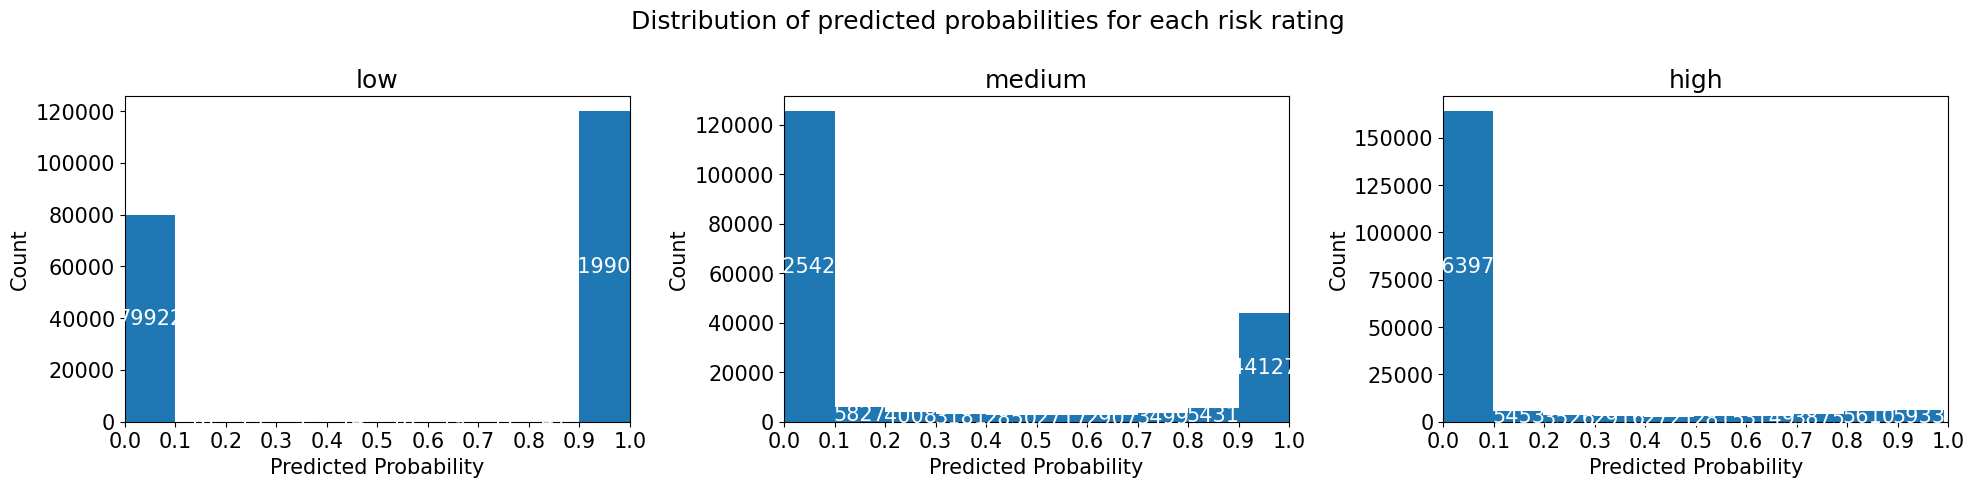

In [ ]:
# prediction
y_score = best_model.predict_proba(X_test_prep)
fig, axes = plt.subplots(1,3)
for i, ax in enumerate(axes.flatten()):
  y_prob = y_score[:,i]
  ax.hist(y_prob, bins = 10)
  for rect in ax.patches:
      height = rect.get_height()
      ax.annotate(f"{height:0.0f}",
                  xy=(rect.get_x() + rect.get_width() / 2, height/2),
                  xytext=(0, 0),  # 3 points vertical offset
                  textcoords="offset points",
                  color = 'white',
                  ha='center', va='center')
  ax.set_xlim(0,1)
  ax.set_xticks(np.arange(0,1.1,0.1))
  ax.set_xlabel("Predicted Probability")
  ax.set_ylabel("Count")
  ax.set_title(f"{y_test.cat.categories[i]}")

plt.suptitle("Distribution of predicted probabilities for each risk rating")
plt.tight_layout()
plt.show()

## Macro OvO ROC and AUROC
- (2009, Baccianella, Andrea Esuli and Fabrizio Sebastiani) [Evaluation Measures for Ordinal Regression](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5364825)
- (2001, Hand and Till) [A Simple Generalisation of the Area Under the ROC Curve for Multiple Class Classification Problems](https://link.springer.com/article/10.1023/A:1010920819831)

1.00, 2.00
1.00, 2.00
0.94, 1.87
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.93']


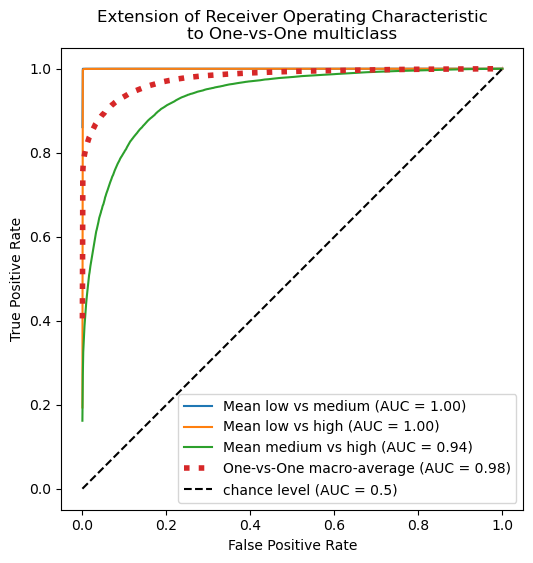

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-all-ovo-roc-curves-together
from sklearn.metrics import auc, RocCurveDisplay
matplotlib.rcParams.update({'font.size': 10})
fpr_grid = np.linspace(0.0, 1.0, 1000)
pair_scores = []
mean_tpr = dict()

macro_roc_auc_ovo = multipartite_AUC(y_test_prep, best_model.predict_proba(X_test_prep))
ovo_tpr = np.zeros_like(fpr_grid)
pair_list = list(combinations(np.unique(y_test_prep), 2))

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
  a_mask = y_test_prep == label_a
  b_mask = y_test_prep == label_b
  ab_mask = np.logical_or(a_mask, b_mask)

  a_true = a_mask[ab_mask]
  b_true = b_mask[ab_mask]

  fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, label_a])
  fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, label_b])

  mean_tpr[ix] = np.zeros_like(fpr_grid)
  mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
  mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
  mean_tpr[ix] /= 2
  mean_score = auc(fpr_grid, mean_tpr[ix])
  pair_scores.append(mean_score)
  
  ovo_tpr += mean_tpr[ix]
  plt.plot(
      fpr_grid,
      mean_tpr[ix],
      label=f"Mean {y_test.cat.categories[label_a]} vs {y_test.cat.categories[label_b]} (AUC = {pair_scores[ix]:.2f})",
  )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-One multiclass")
plt.legend()
plt.show()
matplotlib.rcParams.update({'font.size': 15})

## Lift and gain chart
- in terms of 3 binary comparisons

In [ ]:
temp_dfs = []

         gain   lift
decile              
1      0.2714 2.7140
2      0.5428 2.7139
3      0.8142 2.7139
4      1.0000 2.5000
5      1.0000 2.0000
6      1.0000 1.6667
7      1.0000 1.4286
8      1.0000 1.2500
9      1.0000 1.1111
10     1.0000 1.0000


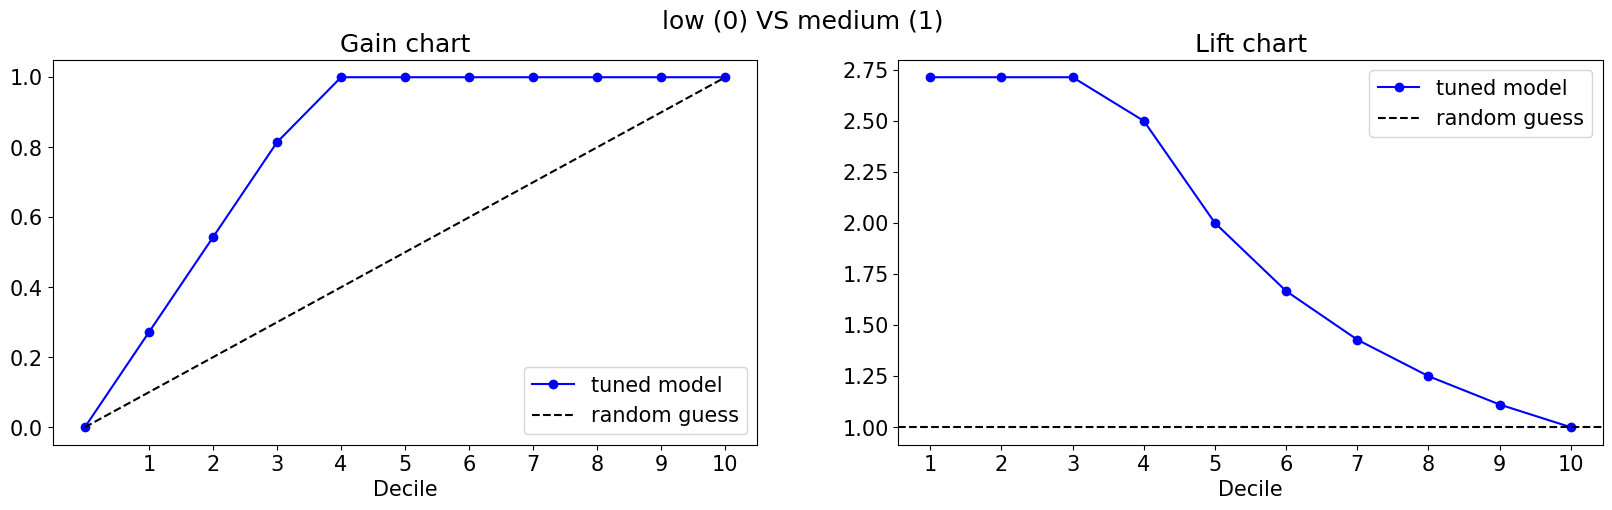

         gain   lift
decile              
1      0.9993 9.9930
2      0.9999 4.9995
3      0.9999 3.3330
4      0.9999 2.4997
5      0.9999 1.9998
6      0.9999 1.6665
7      1.0000 1.4286
8      1.0000 1.2500
9      1.0000 1.1111
10     1.0000 1.0000


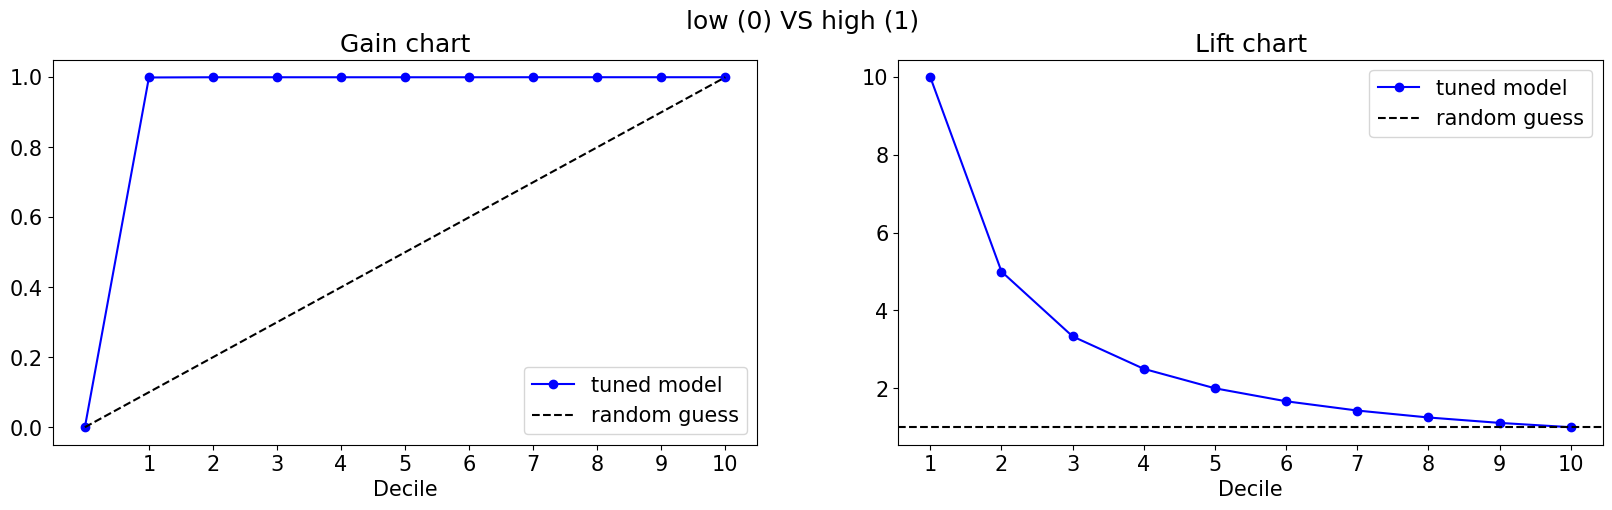

         gain   lift
decile              
1      0.5223 5.2230
2      0.8079 4.0395
3      0.9402 3.1340
4      0.9832 2.4580
5      0.9958 1.9916
6      0.9980 1.6633
7      0.9989 1.4270
8      0.9993 1.2491
9      0.9997 1.1108
10     1.0000 1.0000


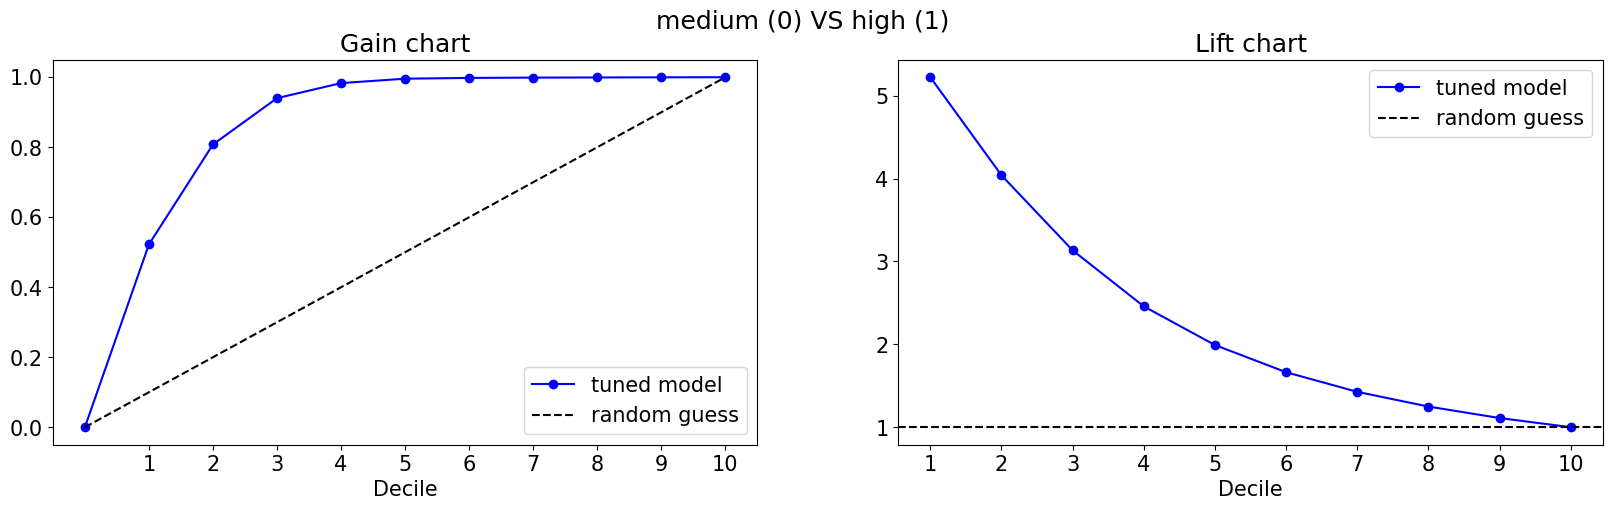

In [ ]:
# fig, axes = plt.subplots(3,1)
for (label_a, label_b) in combinations(np.sort(np.unique(y_test_prep)), 2):
  a_mask = y_test_prep == label_a
  b_mask = y_test_prep == label_b
  ab_mask = np.logical_or(a_mask, b_mask)
  temp_df = pd.DataFrame({
      'y': y_test_prep[ab_mask],
      'prob': y_score[ab_mask, label_b]
  })
  temp_df.sort_values('prob', ascending=False, inplace=True)
  temp_df['decile'] = pd.qcut(temp_df['prob'],10,labels=[i for i in np.arange(10,0,-1)])
  lift_n_gain = temp_df.groupby('decile').agg({'y': lambda x: np.sum(x == label_b)}).sort_index(ascending=False)
  lift_n_gain.columns = ['sum_of_positive_cases_identified']
  lift_n_gain['gain'] = lift_n_gain[['sum_of_positive_cases_identified']].apply(lambda x: x.cumsum() / x.sum())
  lift_n_gain['lift'] = lift_n_gain['gain'] / (lift_n_gain.index.values.astype(int) / 10)
  print(lift_n_gain[['gain', 'lift']])
  temp_dfs.append(lift_n_gain)
  fig2, axes2 = plt.subplots(1,2)
  axes2[0].plot(np.arange(0,11,1), [0] + list(lift_n_gain['gain'].values), 'bo-', label = 'tuned model')
  axes2[0].plot(np.arange(0,11,1), np.arange(0,11,1) / 10, 'k--', label = 'random guess')
  axes2[1].plot(np.arange(1,11,1), lift_n_gain['lift'].values, 'bo-', label = 'tuned model')
  axes2[1].axhline(1, color = 'k', linestyle='--', label = 'random guess')
  axes2[0].set_title('Gain chart')
  axes2[1].set_title('Lift chart')
  plt.suptitle(f'{y_test.cat.categories[label_a]} (0) VS {y_test.cat.categories[label_b]} (1)')
  for ax in axes2:
    ax.set_xticks(np.arange(1,11,1))
    ax.set_xlabel("Decile")
    ax.legend()
  # axes2[1].set_yticks(np.arange(1,11,1))
  plt.show()

In [ ]:
temp_dfs[2]

sum_of_positive_cases_identified   gain   lift
decile                                                
1                                   5223 0.5223 5.2230
2                                   2856 0.8079 4.0395
3                                   1323 0.9402 3.1340
4                                    430 0.9832 2.4580
5                                    126 0.9958 1.9916
6                                     22 0.9980 1.6633
7                                      9 0.9989 1.4270
8                                      4 0.9993 1.2491
9                                      4 0.9997 1.1108
10                                     3 1.0000 1.0000

# Interpretability

## Feature importances and Permutation importance (!increase to n_repeats=30)

Number of features after fitting estimator with regularization: 
28
features = ['WIRES_BALANCE', 'CASH_AVG_OUT', 'WIRES_AVG_OUT', 'CASH_AVG_IN', 'CASH_BALANCE', 'WIRES_CNT_OUT', 'WIRES_AVG_IN', 'IN_VS_OUT_WIRES_AVG', 'AGE', 'CASH_CNT_OUT', 'HIST_JOIN', 'CASH_CNT_IN', 'WIRES_VS_CASH_AVG', 'IN_VS_OUT_CASH_AVG', 'PEP_FL_1', 'WIRES_pct_CNT', 'WIRES_CNT_IN', 'CASH_IN_CNT_VS_AVG', 'IN_pct_WIRES_CNT', 'CASH_OUT_CNT_VS_AVG', 'WIRES_OUT_CNT_VS_AVG', 'WIRES_IN_CNT_VS_AVG', 'IN_pct_CASH_CNT', 'occupation_risk_Moderate', 'RES_CNTRY_CA_1', 'COUNTRY_RISK_RESIDENCY_High', 'COUNTRY_RISK_INCOME_Moderate', 'COUNTRY_RISK_RESIDENCY_Moderate']
coefficient = [350.5, 337.0, 306.5, 294.0, 231.0, 189.0, 184.0, 152.0, 147.5, 145.0, 143.0, 126.5, 119.5, 119.0, 114.5, 112.0, 106.0, 101.0, 92.5, 91.0, 74.5, 73.5, 73.5, 26.5, 17.0, 11.0, 7.5, 5.0]
1.00, 2.00
1.00, 2.00
0.94, 1.87
['Classes 0, 1: 1.00', 'Classes 0, 2: 1.00', 'Classes 1, 2: 0.94']
1.00, 2.00
1.00, 1.99
0.94, 1.87
['Classes 0, 1: 1.00', 'Classes 0, 2:

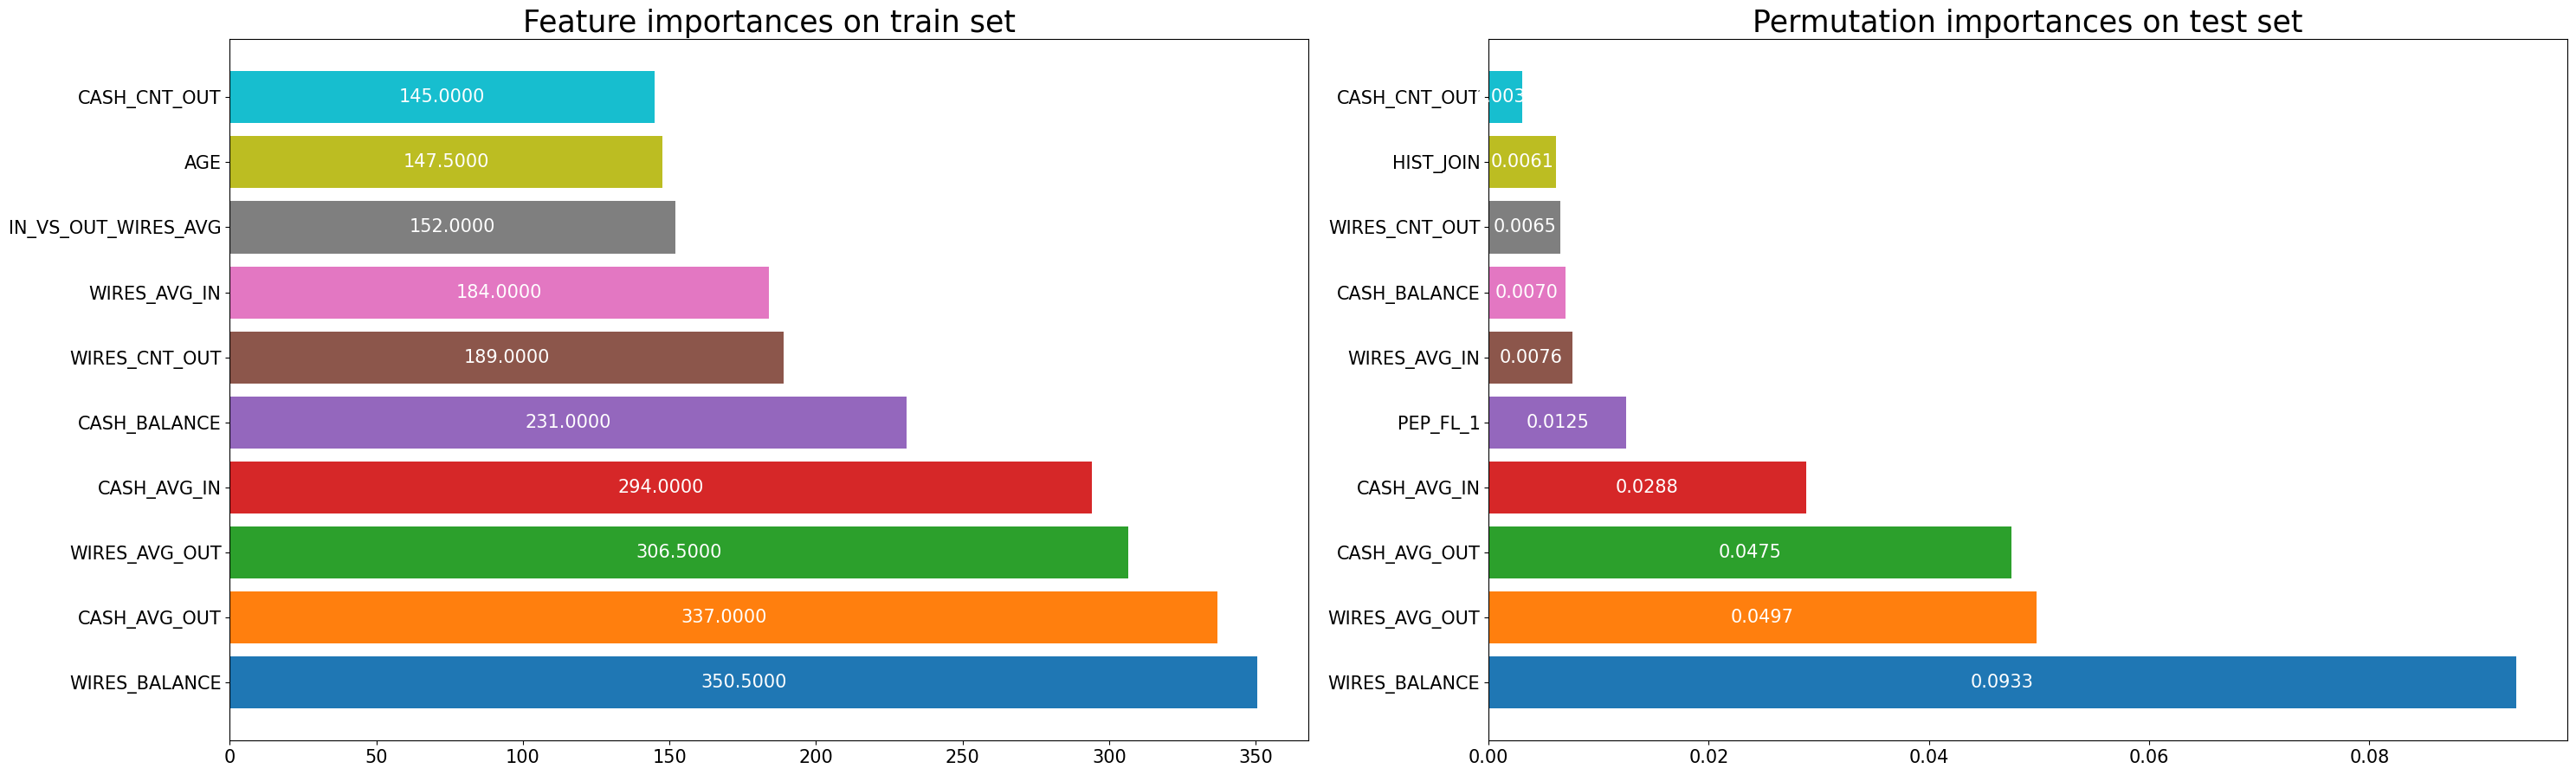

In [ ]:
# non-zero (signficant) features after regularization in fitting estimator
features_out = data_preparation.get_feature_names_out()
top_features = {}

fig, axes = plt.subplots(1,2, figsize = (30,10))

for xyz, ax in zip(range(2), axes.flatten()):

  if xyz == 0:
    try:
      coef = best_model.steps[-1][1].feature_importances_
    except:
      coef = best_model.steps[-1][1].coef_[0]
  elif xyz == 1:
    coef = permutation_importance(best_model.steps[-1][1], X_test_prep, y_test_prep, n_repeats=5, random_state=42, scoring = multipartite_AUC_scorer).importances_mean
  print(f"Number of features after fitting estimator with regularization: \n{np.count_nonzero(coef)}")
  features_non_zero = [features_out[loc] for loc in np.nonzero(coef)[0]]
  coef_non_zero = [np.around(coef[loc], decimals=4) for loc in np.nonzero(coef)[0]]
  print(f"features = {[feature_ for _, feature_ in sorted(zip(np.abs(coef_non_zero), features_non_zero), reverse=True)]}")
  print(f"coefficient = {[coef_ for _, coef_ in sorted(zip(np.abs(coef_non_zero), coef_non_zero), reverse=True)]}")

  abs_coef = np.abs(coef)
  top_n = 10
  top_features[xyz] = sorted(zip(abs_coef, coef, features_out), reverse=True)[:top_n]
  for i, (_, coef, name) in enumerate(top_features[xyz]):
    ax.barh(name, coef)
  for rect in ax.patches:
      width = rect.get_width()
      if xyz == 0:
        annot_txt = f"{width:0.4f}"
      else:
        annot_txt = f"{width:0,.4f}"
      ax.annotate(annot_txt,
                  xy=(width/2, rect.get_y() + rect.get_height() / 2),
                  xytext=(0, 0),  # 3 points vertical offset
                  textcoords="offset points",
                  fontsize = 15,
                  color = 'white',
                  ha='center', va='center')
  ax.tick_params(axis='both', which='major', labelsize=15)
  if xyz == 0:
    ax.set_title(f"Feature importances on train set", size = 25)
  else:
    ax.set_title(f"Permutation importances on test set", size = 25)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### EDA of top features

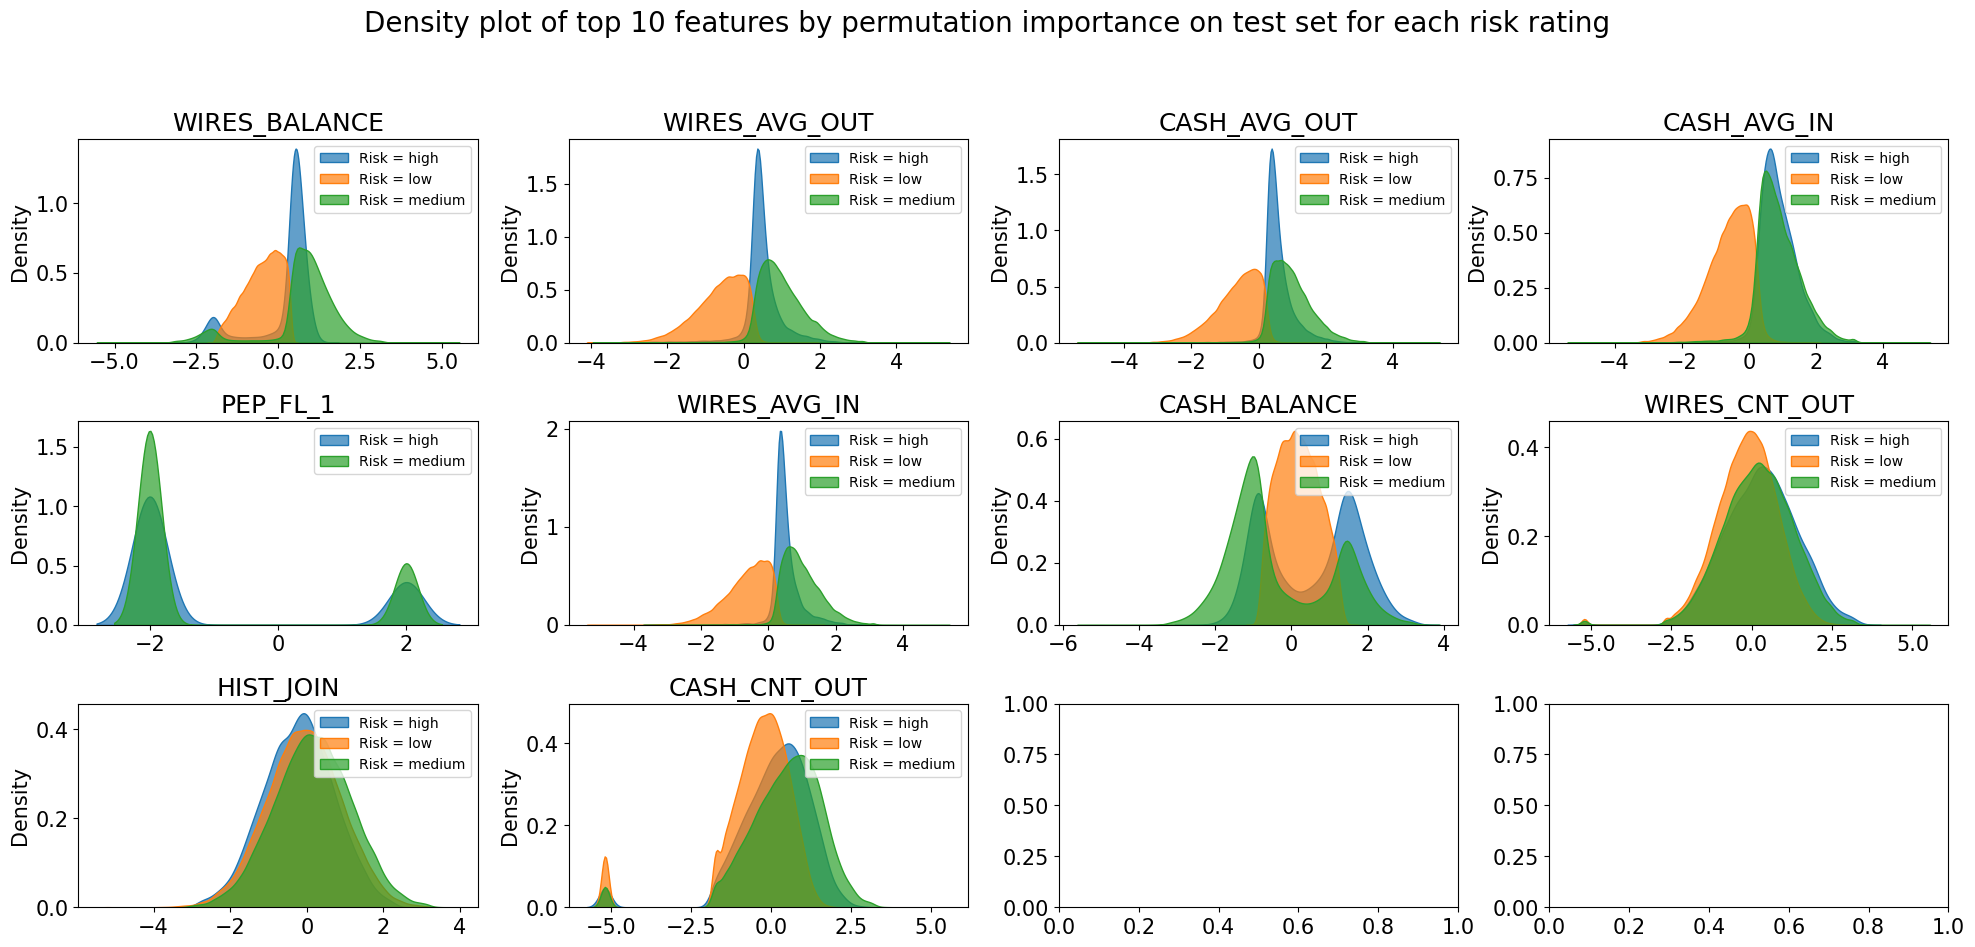

In [ ]:
# Univariate density plot by RISK rating
fig, axes = plt.subplots(3,int(top_n // 3) + 1,figsize=(20,10))

norm_clean = pd.concat([
    X_test_prep,
    y_test], axis = 1)

for ax, col in zip(axes.flatten(), [x[2] for x in top_features[1]]):
  for risk in sorted(y_test.unique()):
    try:
      sns.kdeplot(norm_clean.loc[norm_clean['RISK'] == risk, col], fill=True, label=f"Risk = {risk}", alpha=.7, ax=ax, warn_singular=False, 
                  gridsize=200, legend = True)
    except LinAlgError:
      print(f"only 1 unique value of {norm_clean.loc[norm_clean['cluster'] == risk, col].unique()[0]:0.3f} for {col} in risk {risk}")
  ax.set_title(col)
  ax.legend(loc = 'upper right', prop={'size': 10})
  ax.set_xlabel('')

fig.suptitle('Density plot of top 10 features by permutation importance on test set for each risk rating', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Shapley values

In [ ]:
explainer = shap.Explainer(lambda x: best_model.predict_proba(x), X_test_prep.median().values.reshape(1,-1))
shap_values = explainer(X_test_prep.sample(10_000, replace=True)) # sample 10k (runtime = 1 minute)

Permutation explainer: 10001it [02:23, 63.86it/s]                                                                                                                                                                 


In [ ]:
shap_values.shape

(10000, 28, 3)

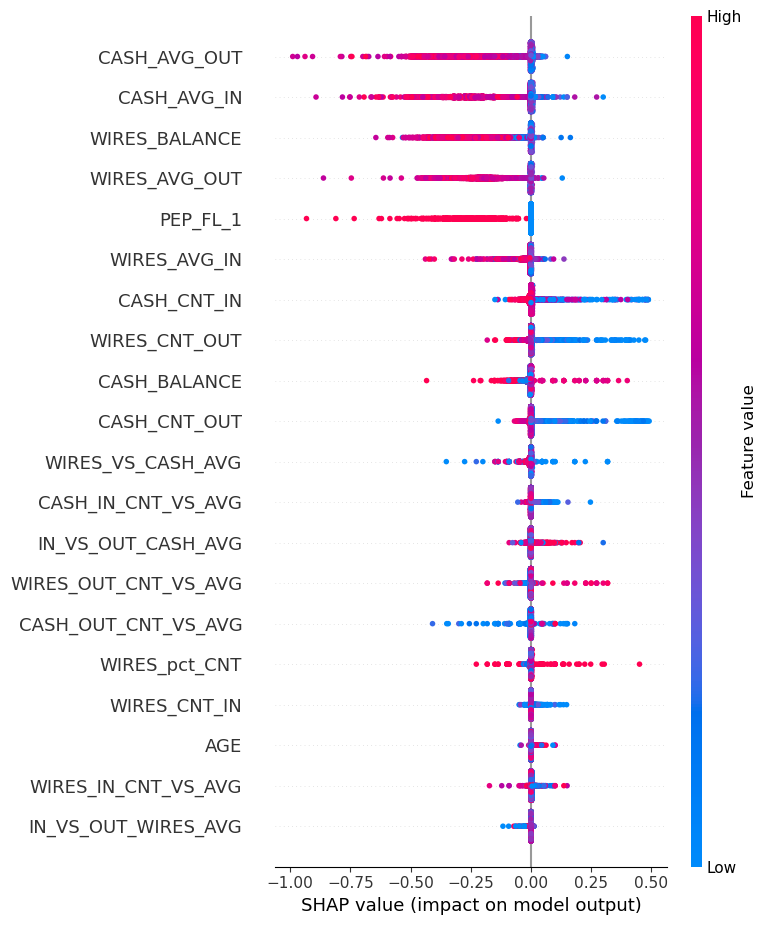

In [ ]:
# low risk
shap.summary_plot(shap_values[:,:,0], plot_type = "dot", title="SHAP Data")

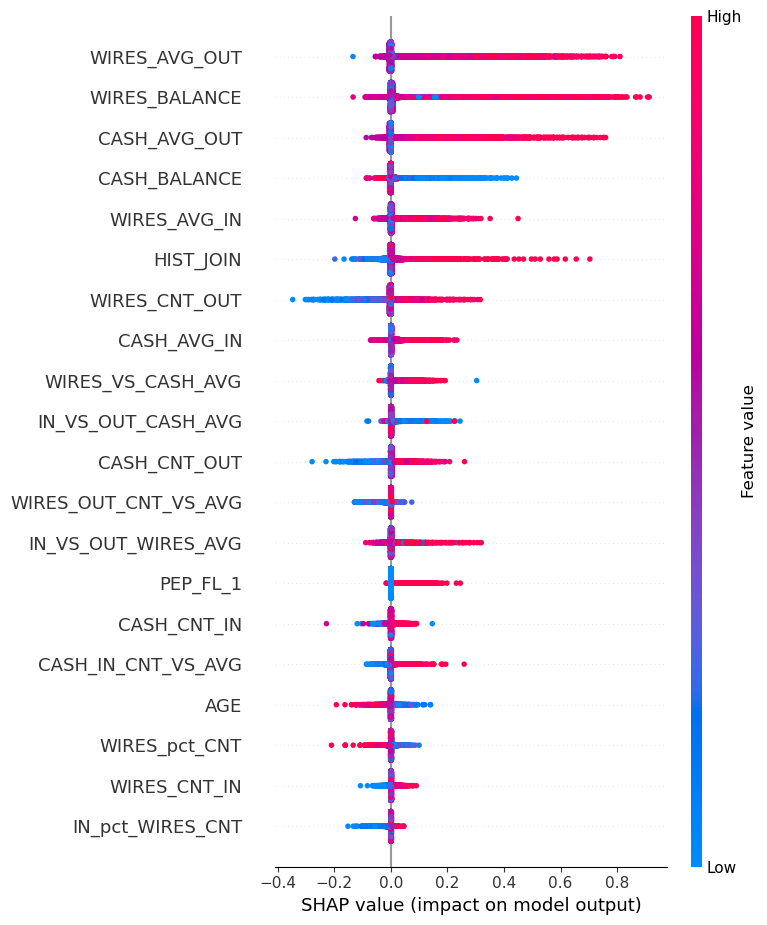

In [ ]:
# medium risk
shap.summary_plot(shap_values[:,:,1], plot_type = "dot", title="SHAP Data")

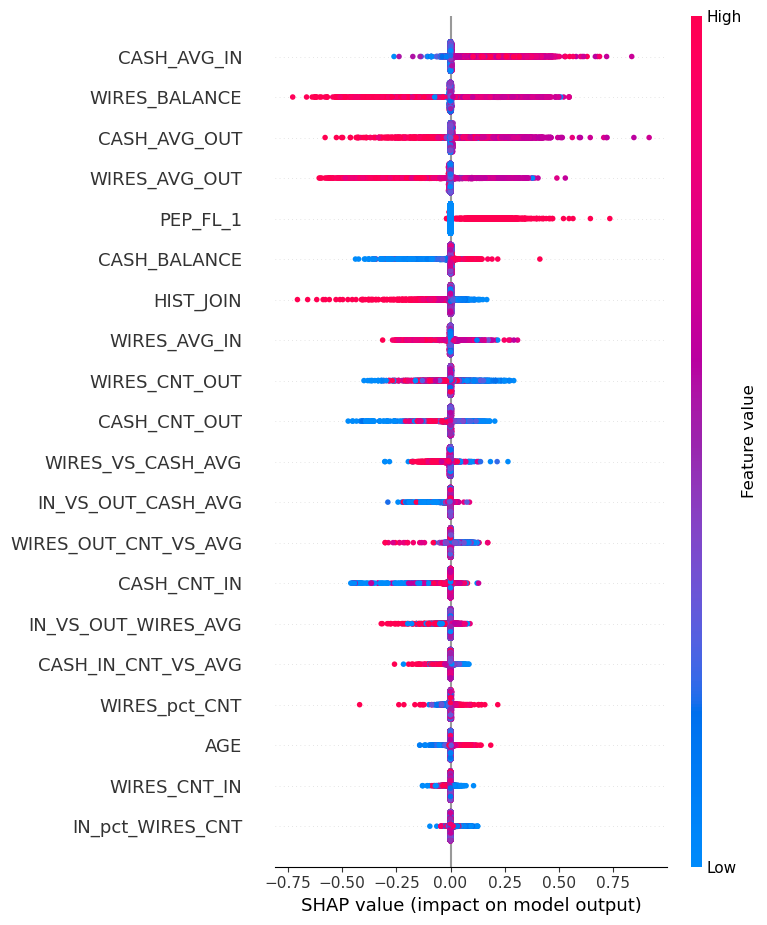

In [ ]:
# high risk
shap.summary_plot(shap_values[:,:,2], plot_type = "dot", title="SHAP Data")

## Partial dependence plots

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

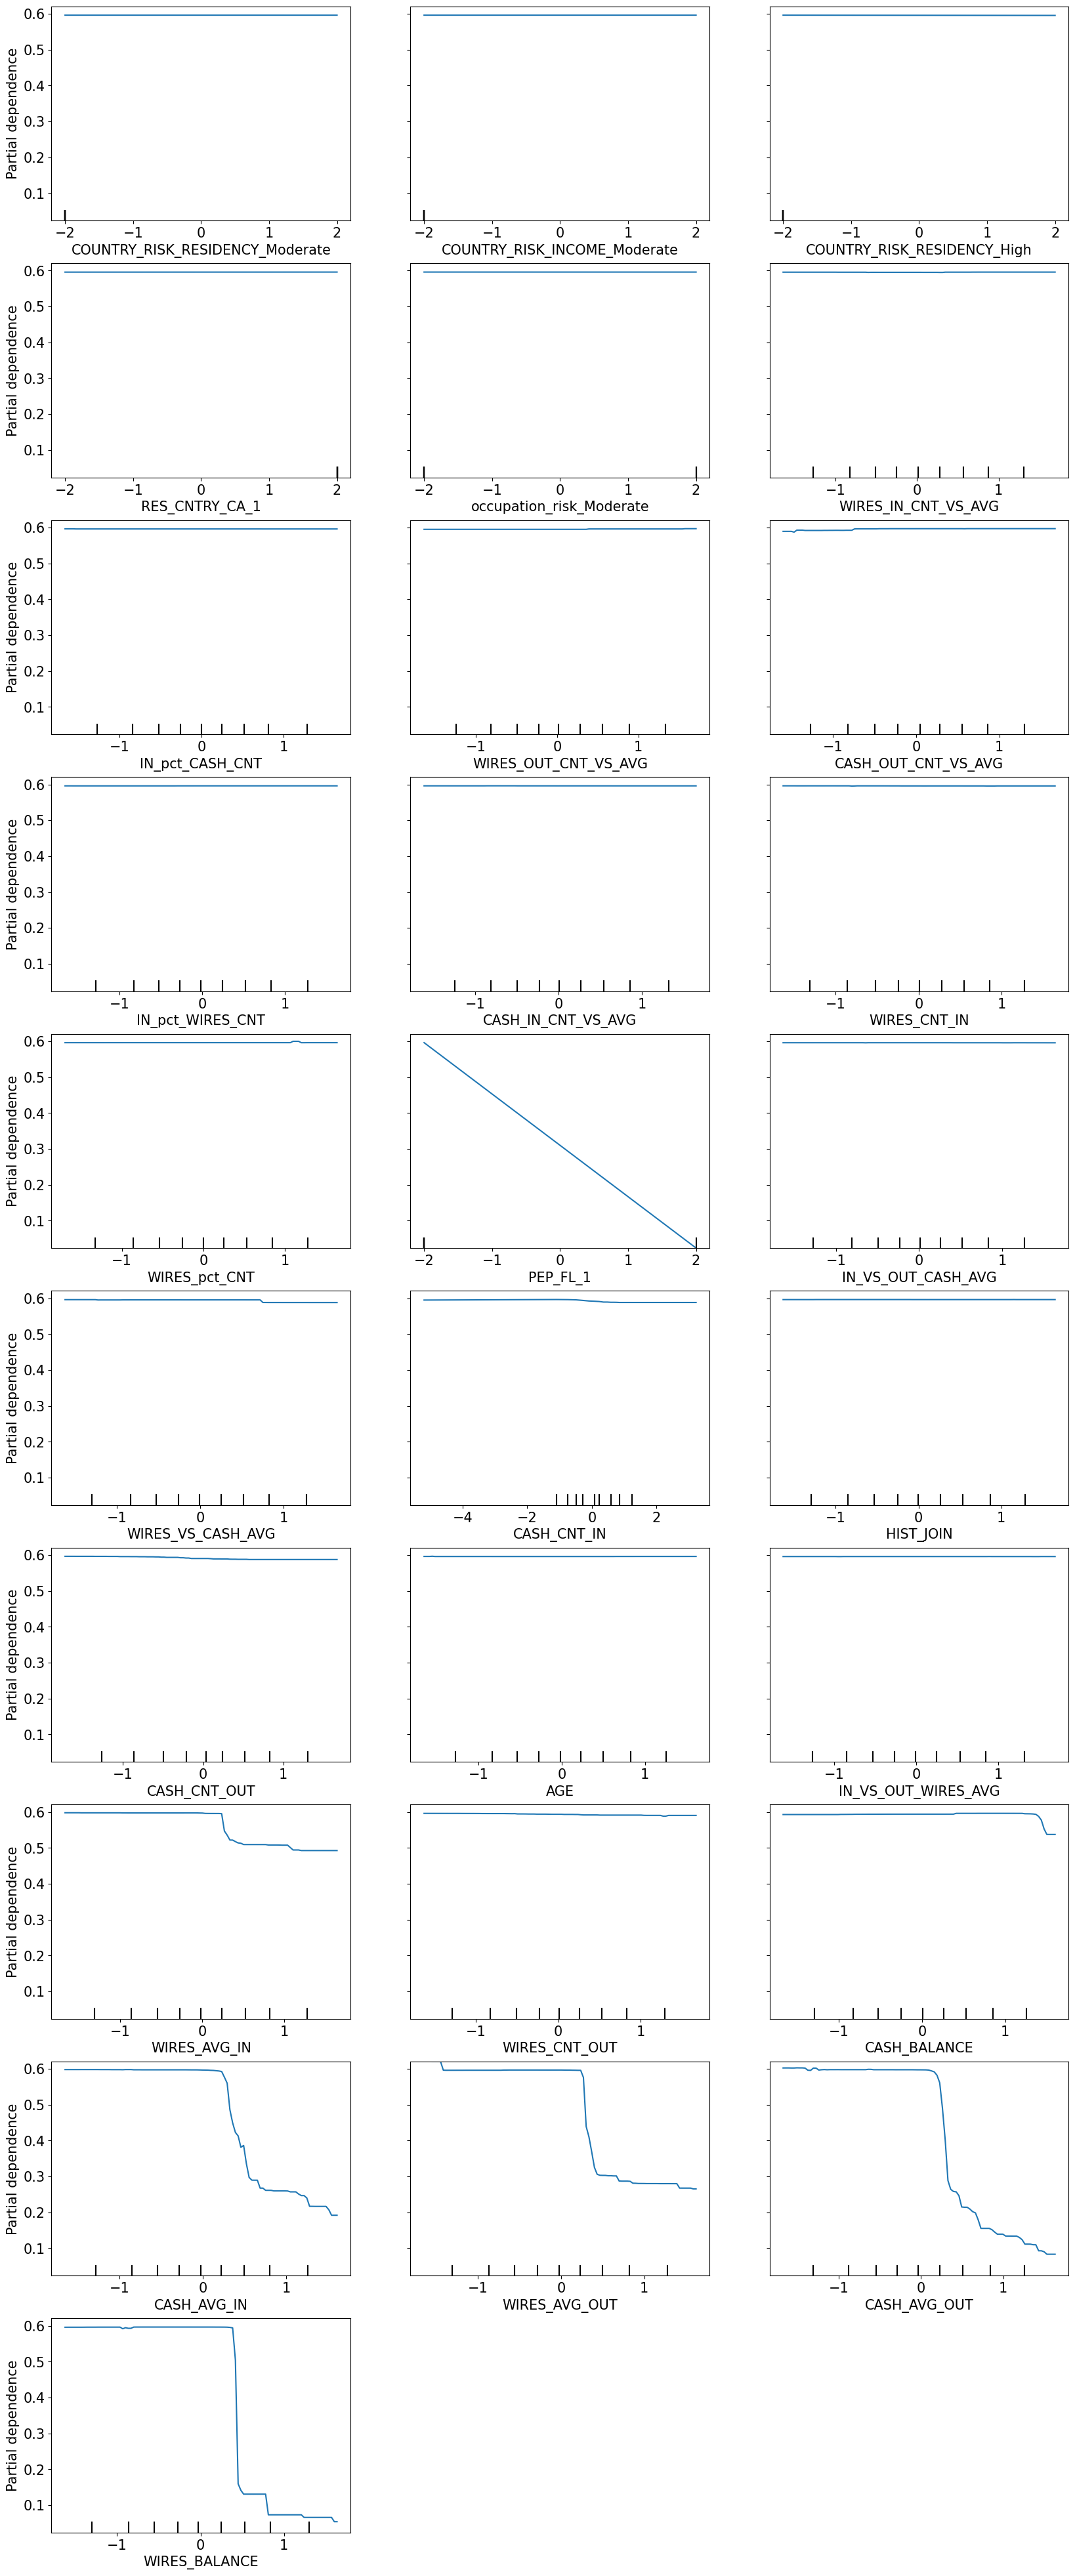

In [ ]:
# low risk
fig, ax = plt.subplots(1,1, figsize = (20,50))
PartialDependenceDisplay.from_estimator(
    best_model, 
    X_test_prep.sample(10_000, replace=True), 
    features = X_test_prep.columns[best_model[0].feature_importances_.argsort()].values, 
    feature_names = X_test_prep.columns, 
    target=0, 
    kind='average',
    response_method='predict_proba', 
    n_jobs=-1,
    ax=ax)

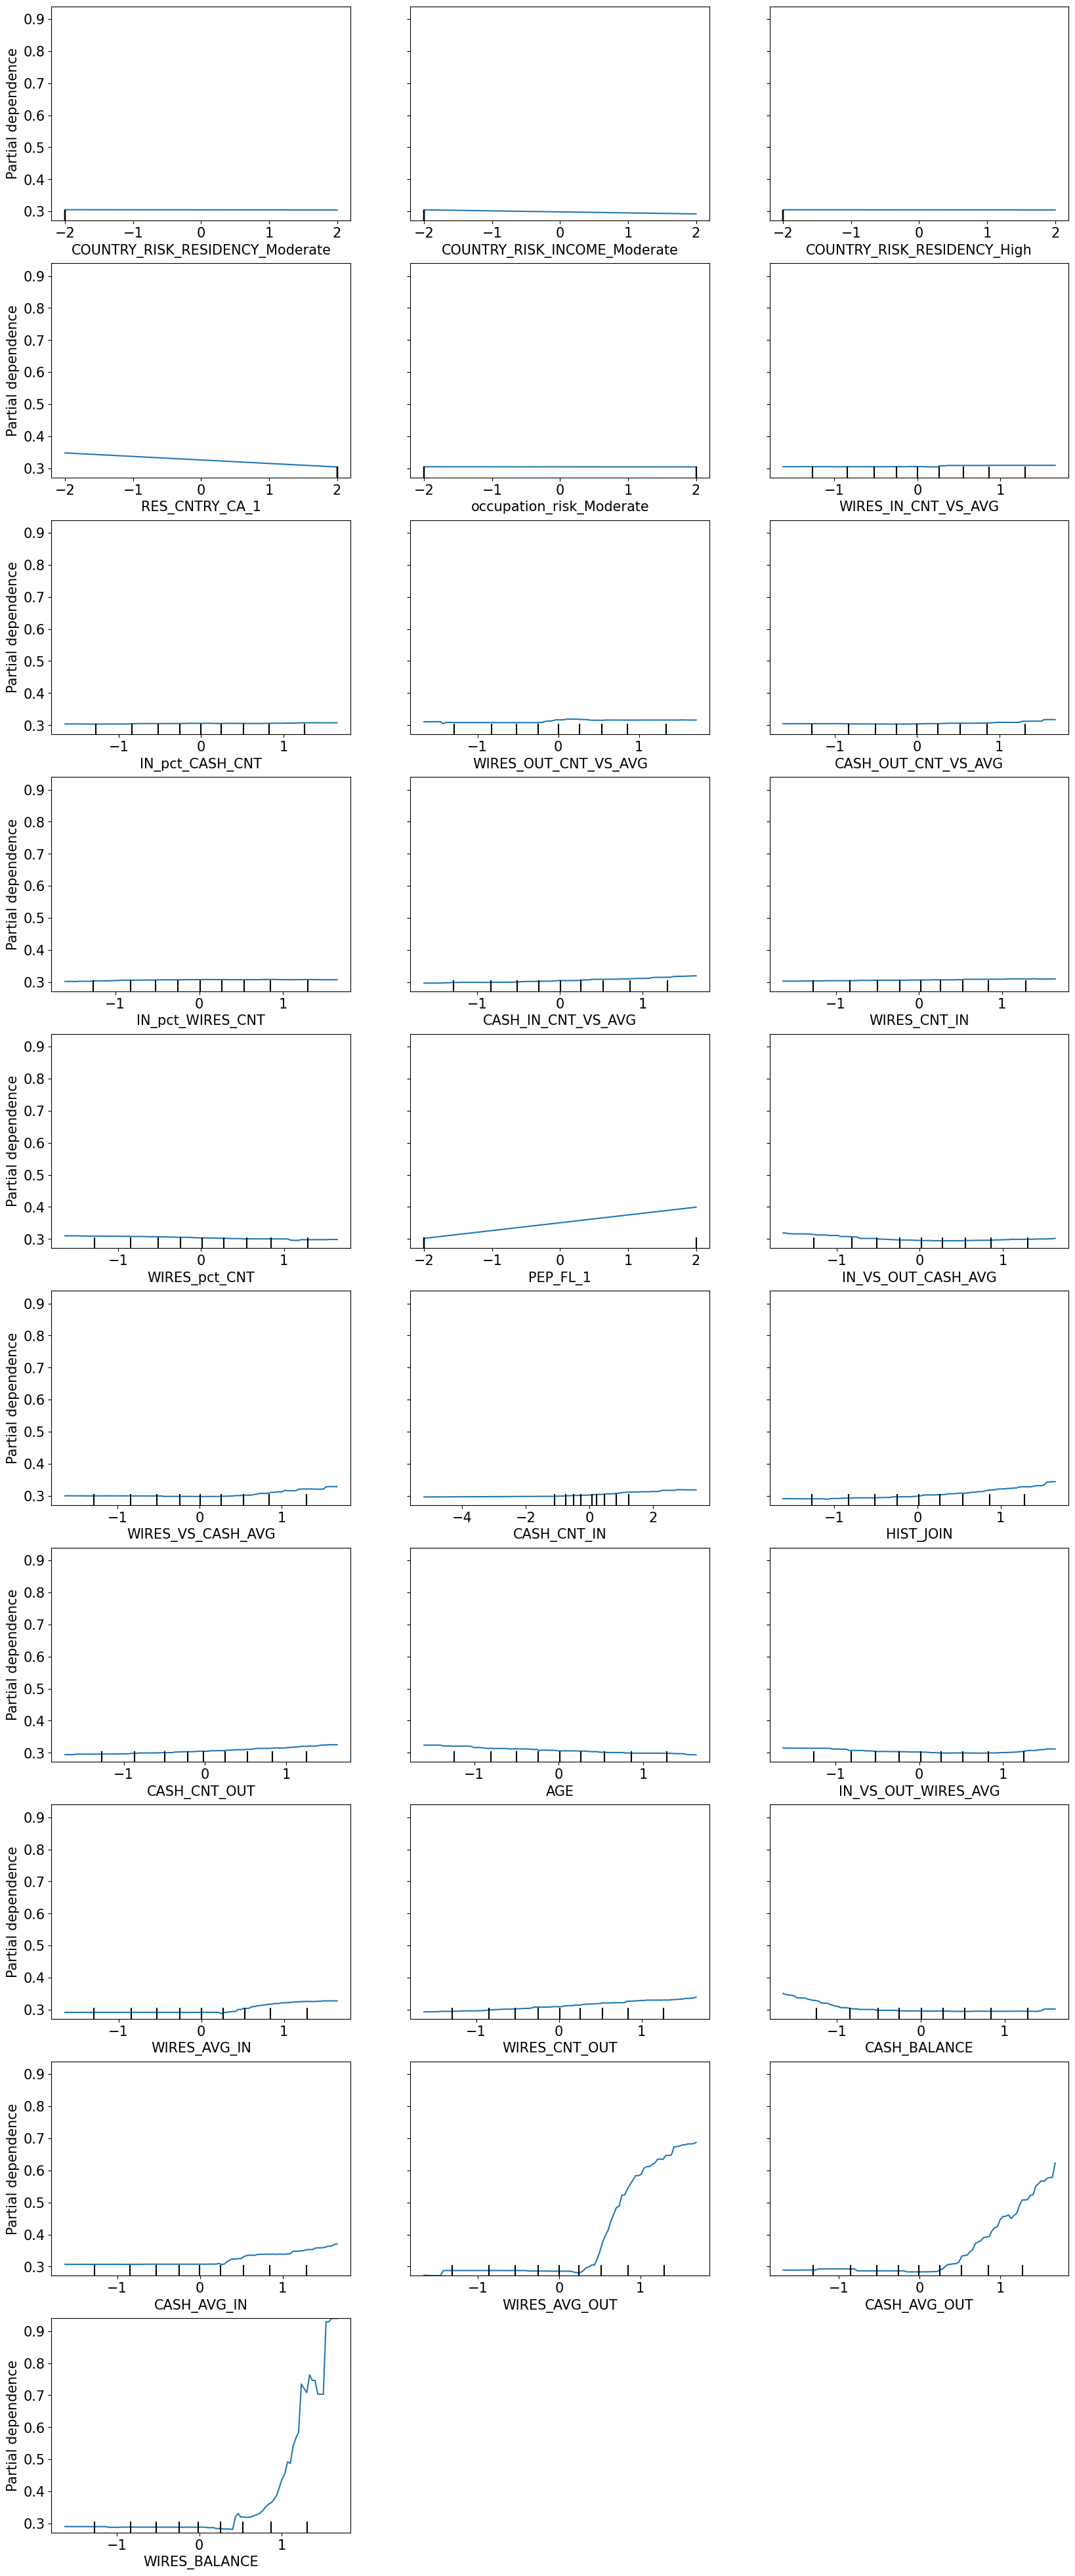

In [ ]:
# medium risk
fig, ax = plt.subplots(1,1, figsize = (20,50))
PartialDependenceDisplay.from_estimator(
    best_model, 
    X_test_prep.sample(10_000, replace=True), 
    features = X_test_prep.columns[best_model[0].feature_importances_.argsort()].values, 
    feature_names = X_test_prep.columns, 
    target=1, 
    kind='average',
    response_method='predict_proba', 
    n_jobs=-1,
    ax=ax)

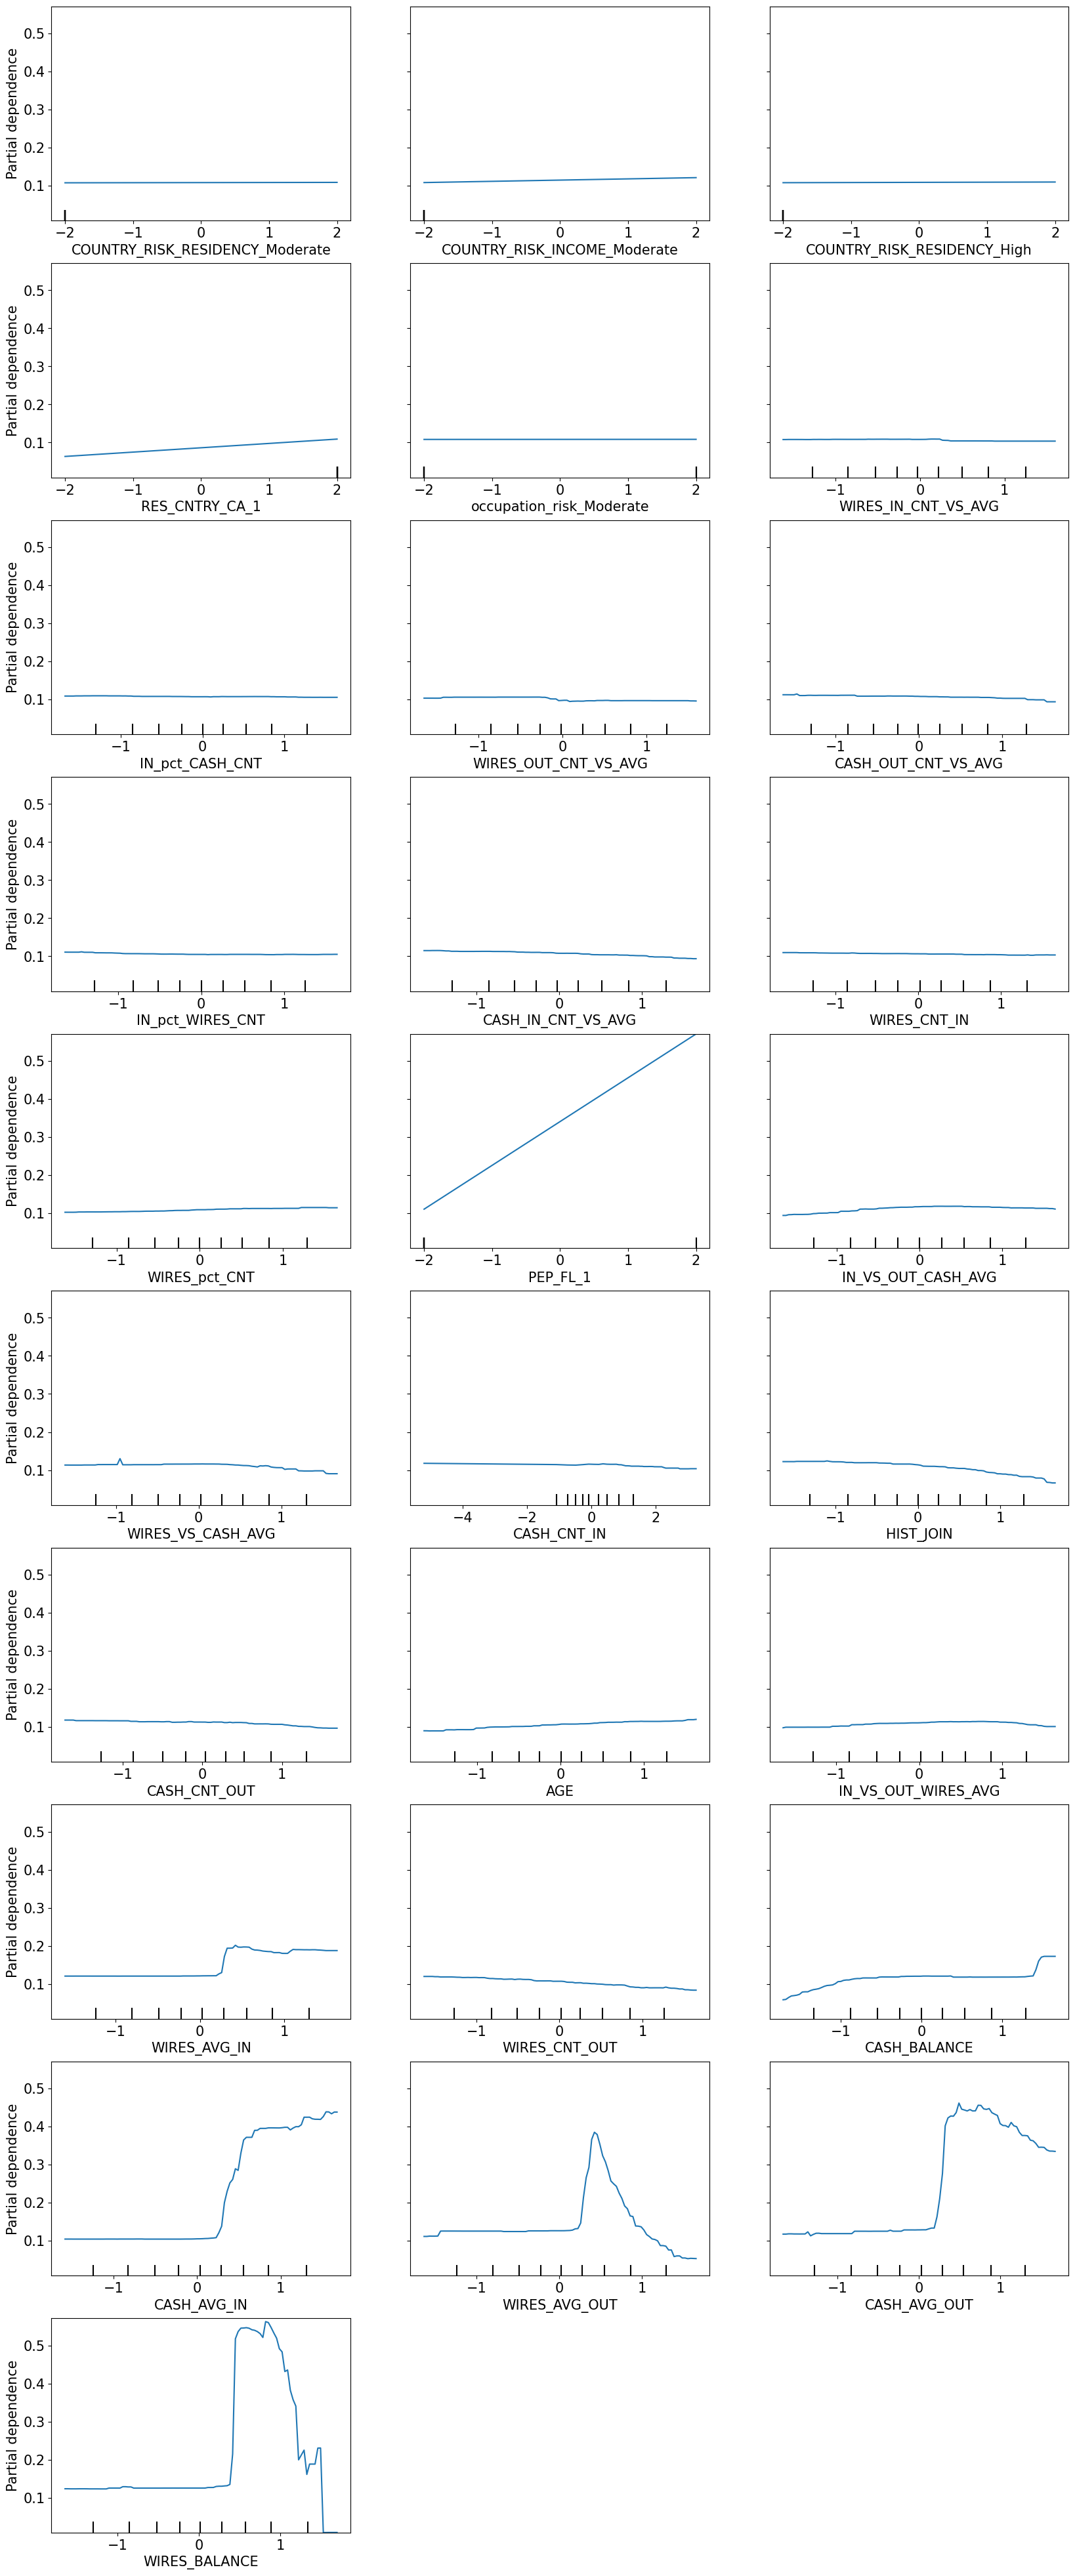

In [ ]:
# high risk
fig, ax = plt.subplots(1,1, figsize = (20,50))
PartialDependenceDisplay.from_estimator(
    best_model, 
    X_test_prep.sample(10_000, replace=True), 
    features = X_test_prep.columns[best_model[0].feature_importances_.argsort()].values, 
    feature_names = X_test_prep.columns, 
    target=2, 
    kind='average',
    response_method='predict_proba', 
    n_jobs=-1,
    ax=ax)

# Probability cutoff

## Precision Recall Curve

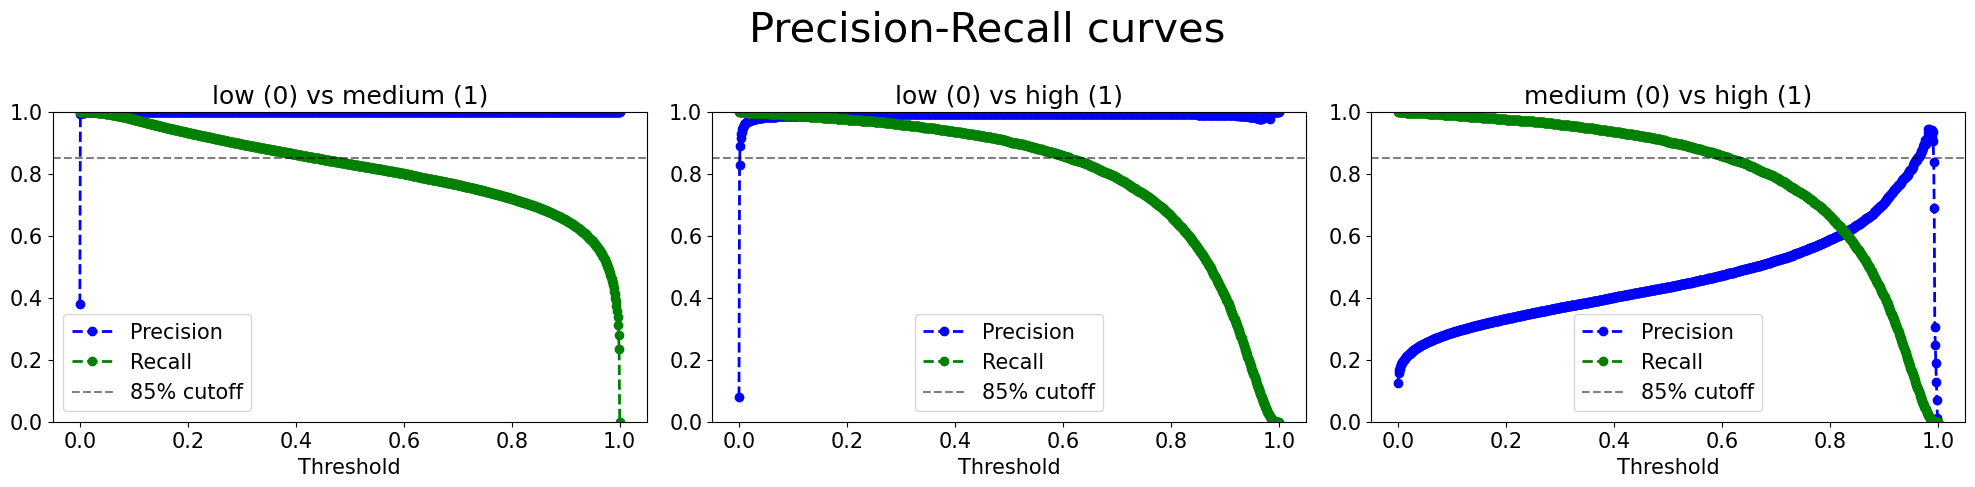

In [ ]:
fig, axes = plt.subplots(1,3)
pair_list = list(combinations(np.unique(y_test_prep), 2))
threshold_grid = np.linspace(0.0, 1.0, 1000)

for ax, (label_a, label_b) in zip(axes.flatten(), pair_list):
  a_mask = y_test_prep == label_a
  b_mask = y_test_prep == label_b
  ab_mask = np.logical_or(a_mask, b_mask)

  a_true = a_mask[ab_mask]
  b_true = b_mask[ab_mask]

  precision_b, recall_b, thresholds = precision_recall_curve(b_true, y_score[ab_mask, label_b])
  recall_interpolated = np.zeros_like(threshold_grid)
  recall_interpolated += np.interp(threshold_grid, thresholds, recall_b[:-1])
  precision_interpolated = np.zeros_like(threshold_grid)
  precision_interpolated += np.interp(threshold_grid, thresholds, precision_b[:-1])

  ax.plot(threshold_grid, precision_interpolated, 'b--o', label = "Precision", linewidth = 2)
  ax.plot(threshold_grid, recall_interpolated, "g--o", label = "Recall", linewidth = 2)
  ax.axhline(0.85, ls='--', c='k', alpha=0.5, label = '85% cutoff')
  ax.set_xlabel("Threshold")
  ax.set_ylim(0,1)
  ax.set_title(f"{y_test.cat.categories[label_a]} (0) vs {y_test.cat.categories[label_b]} (1)")
  ax.legend()

plt.suptitle("Precision-Recall curves", size = 30)
plt.tight_layout()
plt.show()

## Cost sensitive cutoff
- average cutoff of low vs high and medium vs high 
  - cost of misclassifying high risk as low risk != cost of misclassifying high risk as medium risk
- you won't know the priori when deployed

### misclassification loss = 0 to 100%

In [ ]:
# as a % of revenue per customer
misclassification_matrix = np.array([
    [0.0, 0.1, 0.5],
    [0.2, 0.0, 0.3],
    [1.0, 0.6, 0.0]])

In [ ]:
def plot_misclassification_losses(y_pred, cutoff = None):
  # y_pred, cutoff
  fig, axes = plt.subplots(1,3)
  ConfusionMatrixDisplay(
      misclassification_matrix,
      display_labels=y_test.cat.categories).plot(cmap = 'Blues', ax = axes[0], values_format='.0%')
  axes[0].set_title('Asymmetric loss matrix\n(misclassification loss as %)', fontsize = 14)

  confusion_mat = confusion_matrix(y_test_prep, y_pred)

  ConfusionMatrixDisplay(
      confusion_mat,
      display_labels=y_test.cat.categories).plot(cmap = 'Blues', ax = axes[1], values_format=',.0f')
  axes[1].set_title(f"Confusion matrix\n({np.sum(confusion_mat):,.0f} customers)", fontsize = 14)

  rev_per_customer = 100
  total_loss = confusion_mat * misclassification_matrix * rev_per_customer
  ConfusionMatrixDisplay(
      total_loss,
      display_labels=y_test.cat.categories).plot(cmap = 'Blues', ax = axes[2], values_format=',.0f')
  axes[2].set_title(f'Total misclassification losses\n(${rev_per_customer} from each customer)', fontsize = 14)

  plt.tight_layout(rect=[0, 0.03, 1, 0.85])
  if cutoff is None:
    plt.suptitle(f"""Total misclassification losses = {np.sum(total_loss) / rev_per_customer / np.sum(confusion_mat):,.2%} with cutoff = argmax(probabilities)
    (or \${np.sum(total_loss):,.0f} in total for {np.sum(confusion_mat):,.0f} customers)""")
  else:
    plt.suptitle(f"""Total misclassification losses = {np.sum(total_loss) / rev_per_customer / np.sum(confusion_mat):,.2%} with cutoff = [{cutoff[0]:0.2f} for medium, {cutoff[1]:0.2f} for high]
    (or \${np.sum(total_loss):,.0f} in total for {np.sum(confusion_mat):,.0f} customers)""")
  plt.show()

### default threshold

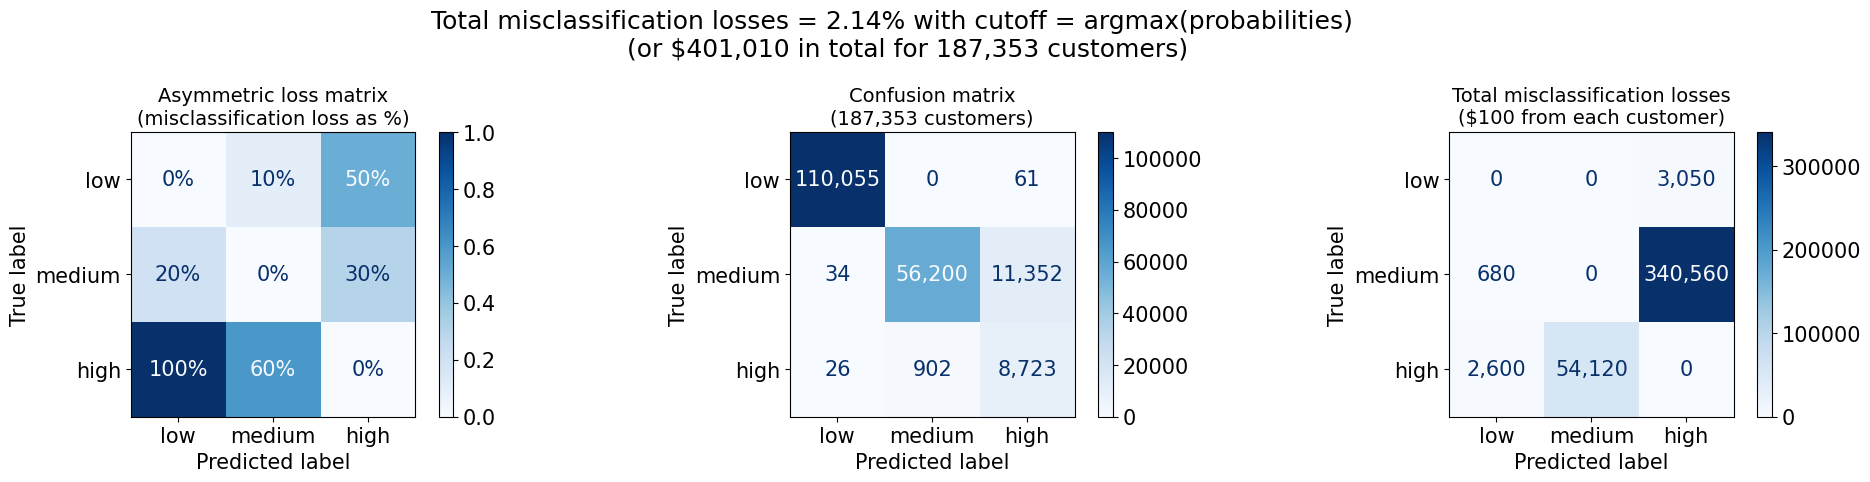

In [ ]:
plot_misclassification_losses(best_model.predict(X_test_prep), None)

In [ ]:
print(classification_report(y_test_prep, best_model.predict(X_test_prep)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110116
           1       0.98      0.83      0.90     67586
           2       0.43      0.90      0.59      9651

    accuracy                           0.93    187353
   macro avg       0.81      0.91      0.83    187353
weighted avg       0.96      0.93      0.94    187353



### optimized threshold

In [ ]:
threshold_grid2 = np.linspace(0.0, 1.0, 100)
total_loss_optimized = np.zeros((threshold_grid2.size, threshold_grid2.size))

for i, threshold_i in enumerate(tqdm(threshold_grid2)):
  a_mask = (y_score[:,1] >= threshold_i)
  for j, threshold_j in enumerate(threshold_grid2):
    b_mask = (y_score[:,2] >= threshold_j)
    y_pred_custom = a_mask.astype(int) + b_mask.astype(int)
    total_loss_optimized[i,j] = np.sum(confusion_matrix(y_test_prep, y_pred_custom) * misclassification_matrix)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.77s/it]


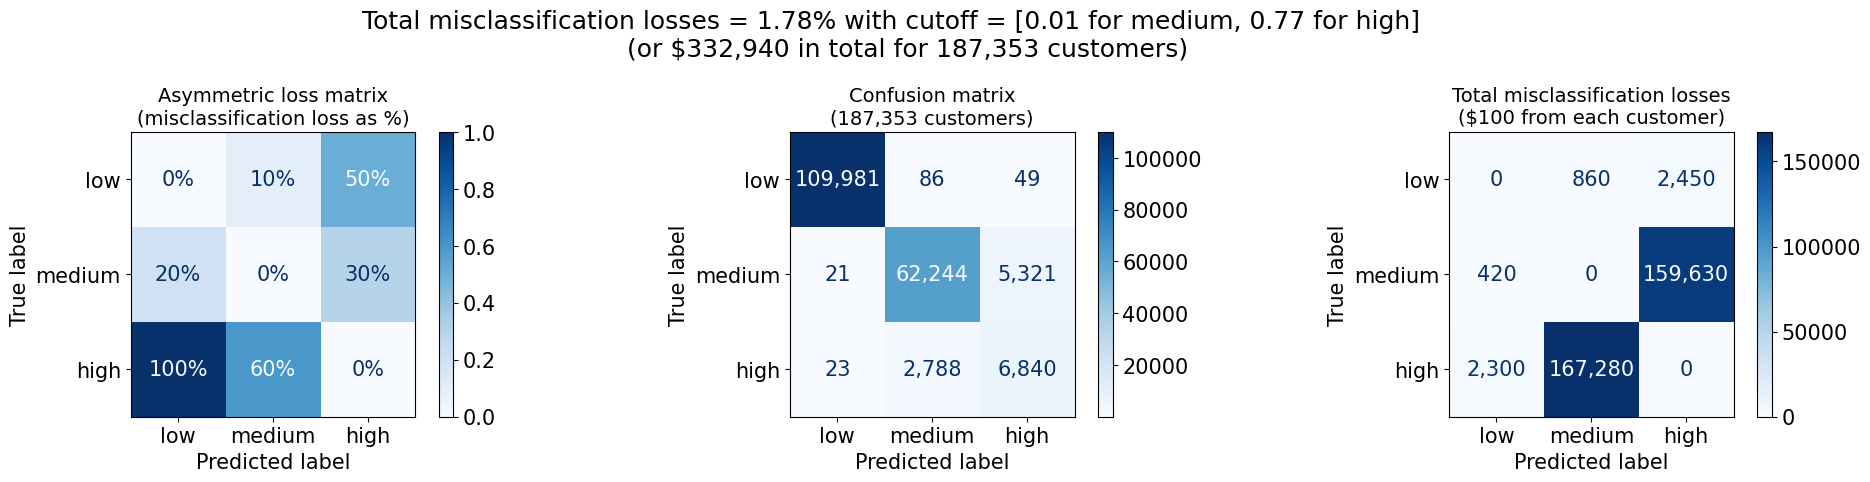

In [ ]:
cutoff_best = [threshold_grid2[k] for k in np.unravel_index(total_loss_optimized.argmin(), total_loss_optimized.shape)]
y_pred_best = (y_score[:,1] >= cutoff_best[0]).astype(int) + (y_score[:,2] >= cutoff_best[1]).astype(int)

plot_misclassification_losses(y_pred_best, cutoff_best)

In [ ]:
print(classification_report(y_test_prep, y_pred_best))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110116
           1       0.96      0.92      0.94     67586
           2       0.56      0.71      0.63      9651

    accuracy                           0.96    187353
   macro avg       0.84      0.88      0.85    187353
weighted avg       0.96      0.96      0.96    187353



## MAE ranking loss

In [ ]:
# default cutoff
macro_avg_MAE(y_test_prep, best_model.predict(X_test_prep))

['0.00', '0.17', '0.10']


0.0894748749726517

In [ ]:
# cost sensitive
macro_avg_MAE(y_test_prep, y_pred_best)

['0.00', '0.08', '0.29']


0.12478644321331861

# Resources AML
- https://fintrac-canafe.canada.ca/guidance-directives/guidance-directives-eng